# Lithology Classification
1. [Introduction](#introduction)<br>
2. [Exploratory Data Analysis](#eda)<br>
    2.1 [Data Description](#datadescription)<br>
    2.2 [Data visualization](#datavisualization)<br>
    2.3 [Feature correlation check](#featurecorrelationcheck)
3. [Feature selection and feature engineer](#featureselectionandfeatureengineer)
4. [Build Machine Learning Models](#buildMachineLearningmodels)<br>
    4.1 [SVM](#SVM)<br>
    4.2 [Gradient Boosting Tree](#gradientboostingtree)<br>
6. [Model Validation with Blind Data](#modelvalidationwithblinddata)
7. [Summary](#Summary)

In [75]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn import impute

import xgboost as xgb
from xgboost.sklearn import  XGBClassifier

## 1. Introduction <a name="introduction"></a>
In this project, I am going to demonstrate using the machine learning algorithms to identify lithofacies based on well-log measurements. A supervised-learning algorithm Gradient Boosting Tree is trained by 9 well-log data. These wells have already had lithofacies classes assigned. Once the classifier is trained, I'll use it to assign facies to wells that have not been described.

## 2. Exploratory Data Analysis<a name="eda"></a>

### 2.1 Data Description<a name="datadescription"></a>
The demo data set was from Univeristy of Kansas and they were collected on the Hugoton and Panoma gas fields. For more on the origin of the data, see Dubois et al. (2007) and the Jupyter notebook that accompanies this tutorial at [http://github.com/seg](http://github.com/seg).

The data set included 9 wells data, and there were 3232 observations. There are 9 columns in the data table, including 5 wireline log measurements, 2 indicator variables derived from geologic knowledge, a facies lable at half foot intervals, and a relative position. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8


In [2]:
#load the training data
filename = 'training_data.csv'
training_data = pd.read_csv(filename)
training_data

Facies Formation        Well Name   Depth      GR  ILD_log10  DeltaPHI  \
0          3     A1 SH        SHRIMPLIN  2793.0  77.450      0.664     9.900   
1          3     A1 SH        SHRIMPLIN  2793.5  78.260      0.661    14.200   
2          3     A1 SH        SHRIMPLIN  2794.0  79.050      0.658    14.800   
3          3     A1 SH        SHRIMPLIN  2794.5  86.100      0.655    13.900   
4          3     A1 SH        SHRIMPLIN  2795.0  74.580      0.647    13.500   
...      ...       ...              ...     ...     ...        ...       ...   
3227       5      C LM  CHURCHMAN BIBLE  3120.5  46.719      0.947     1.828   
3228       5      C LM  CHURCHMAN BIBLE  3121.0  44.563      0.953     2.241   
3229       5      C LM  CHURCHMAN BIBLE  3121.5  49.719      0.964     2.925   
3230       5      C LM  CHURCHMAN BIBLE  3122.0  51.469      0.965     3.083   
3231       5      C LM  CHURCHMAN BIBLE  3122.5  50.031      0.970     2.609   

       PHIND     PE  NM_M  RELPOS  
0     11.915  4.600     1   1.000  
1     12.565  4.100     1   0.979  
2     13.050  3.600     1   0.957  
3     13.115  3.500     1   0.936  
4     13.300  3.400     1   0.915  
...      ...    ...   ...     ...  
3227   7.254  3.617     2   0.685  
3228   8.013  3.344     2   0.677  
3229   8.013  3.190     2   0.669  
3230   7.708  3.152     2   0.661  
3231   6.668  3.295     2   0.653  

[3232 rows x 11 columns]

In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (8, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [4]:
training_data.describe()


Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  3232.000000  3232.000000  3232.000000  3232.000000  3232.000000   
mean      4.422030  2875.824567    66.135769     0.642719     3.559642   
std       2.504243   131.006274    30.854826     0.241845     5.228948   
min       1.000000  2573.500000    13.250000    -0.025949   -21.832000   
25%       2.000000  2791.000000    46.918750     0.492750     1.163750   
50%       4.000000  2893.500000    65.721500     0.624437     3.500000   
75%       6.000000  2980.000000    79.626250     0.812735     6.432500   
max       9.000000  3122.500000   361.150000     1.480000    18.600000   

             PHIND           PE         NM_M       RELPOS  
count  3232.000000  3232.000000  3232.000000  3232.000000  
mean     13.483213     3.725014     1.498453     0.520287  
std       7.698980     0.896152     0.500075     0.286792  
min       0.550000     0.200000     1.000000     0.010000  
25%       8.346750     3.100000     1.000000     0.273000  
50%      12.150000     3.551500     1.000000     0.526000  
75%      16.453750     4.300000     2.000000     0.767250  
max      84.400000     8.094000     2.000000     1.000000

The quick view of the statistics of the numerical features of the training data. There are 3232 observations. The statistics indicate that these dataset had been preprocessed since not many stranged values observed as in the regular well logs.

### 2.1 Data Visualization<a name="datavisualization"></a>

In [5]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [6]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
#     cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
#                                 'SiSh', ' MS ', ' WS ', ' D  ', 
#                                 ' PS ', ' BS ']))
#     cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

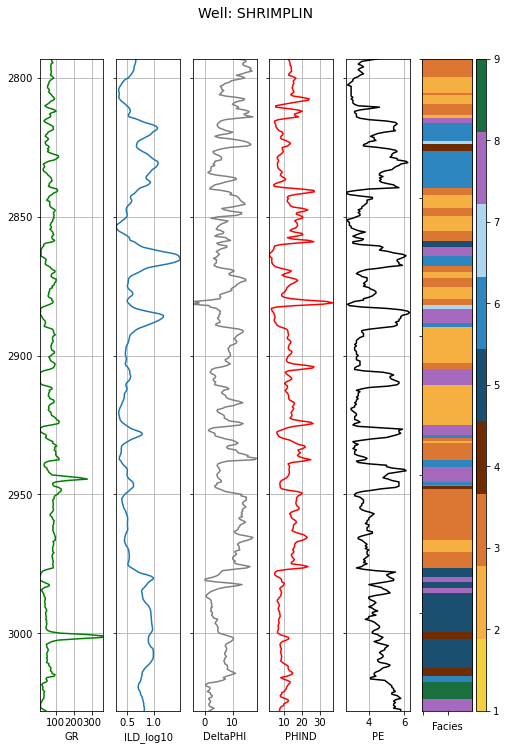

In [7]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

The Y axis is the depth and the x axis is the feature value. This is a typical visualizaiton of the well log data. The Stratigraphic formation of rocks was also presented in this figure.

SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

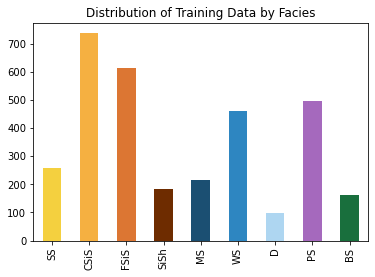

In [8]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

We can observed some degree of data imbalance in the training dataset. 

### 2.3 Feature correlation check<a name="featurecorrelationcheck"></a>

C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Hugo\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key

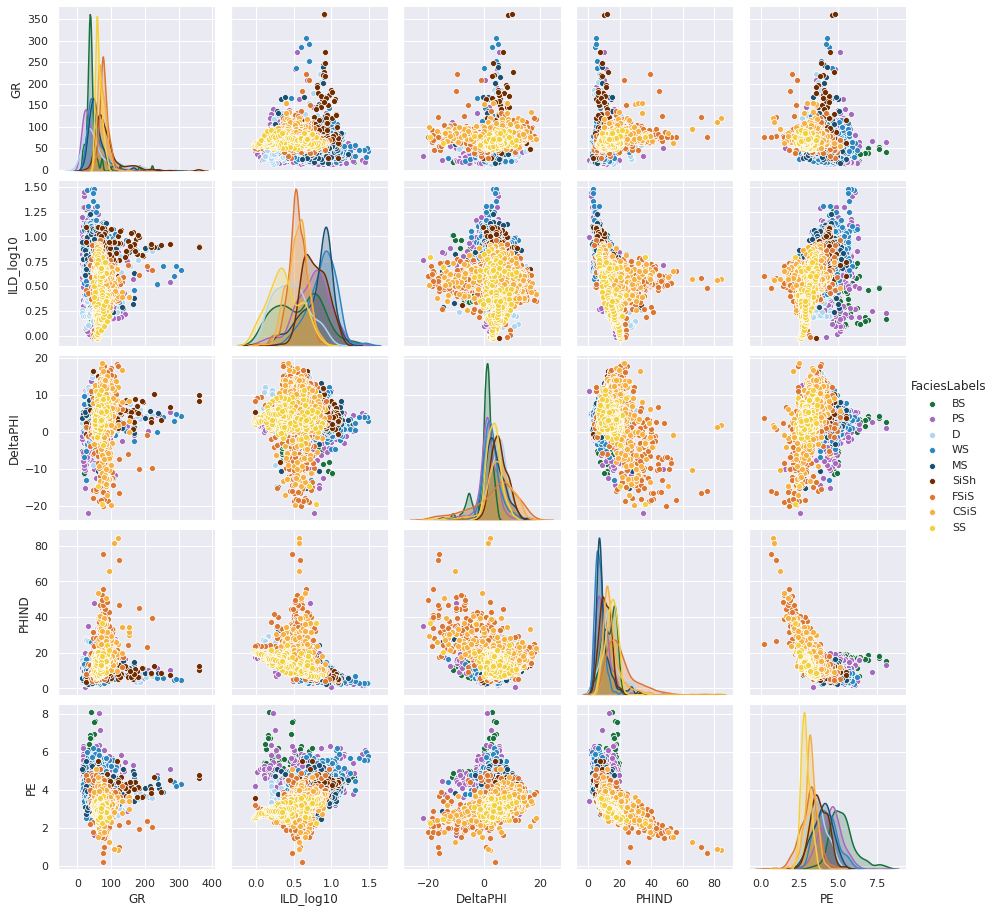

In [9]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

The crossplots are used to visualize how tow features vary with rock type. We created a matrix of crossplots to visualize the variation between log measurements in the data set.

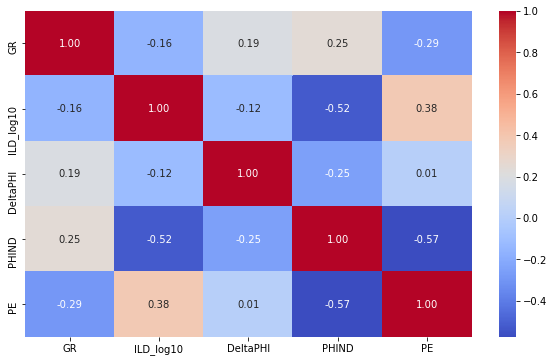

In [10]:
fig, ax = plt.subplots(figsize = (10,6))
cm_df = sns.heatmap(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1).corr(), annot = True, fmt = ".2f", cmap = 'coolwarm', ax = ax)

Combining the pairplot and the correlation heat map, we can exam the highly correlated features. In these data set, we did not observe highly correlated feature pairs.

## 3. Feature selection and feature engineer<a name=" Featureselectionandfeatureengineer"></a>

The relationship between the well-log features and the lithofacies is complicated. In the training dataset, we only have 5 well-log features and 2 derived features. To reveal the underline relationship, we proposed the following feature augmentation.
1. neighboring value
2. gradient
3. quadratic expansion

In [11]:
# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

In [12]:
# Store features and labels
X = training_data[feature_names].values 
y = training_data['Facies'].values 

In [13]:
# Store well labels and depths
well = training_data['Well Name'].values
depth = training_data['Depth'].values

# Fill 'PE' missing values with mean
imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)

In [14]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [15]:
X_aug, padded_rows = augment_features(X, well, depth)

In [16]:
deg = 2
poly = preprocessing.PolynomialFeatures(deg, interaction_only=False)
X_aug2 = poly.fit_transform(X_aug)

In [76]:
X_aug.shape

(3232, 28)

In [77]:
X_aug2.shape

(3232, 435)

## 4.Build Machine Learning Models <a name=" buildmachinelearningmodels"></a>

To evaluate the accuracy of the classifier, we will remove one well from the training set. We will compare the predicted facies with the pre-labeled value.

In [17]:
#leave a well for blind test later 
blind = X_aug2[training_data['Well Name'] == 'CHURCHMAN BIBLE']

In [18]:
blind_y = y[training_data['Well Name'] == 'CHURCHMAN BIBLE']

In [19]:
blind.shape

(404, 435)

In [20]:
X_aug_tr = X_aug2[training_data['Well Name'] != 'CHURCHMAN BIBLE']

In [21]:
y_tr = y[training_data['Well Name'] != 'CHURCHMAN BIBLE']

In [22]:
X_aug_tr.shape

(2828, 435)

Many machine-learning algorithms assume the feature data are normally distributed (i.e., Gaussian distributed with zero mean and unit variance). We will apply the python package SandardScaler to the predictor features, thus they'll have the property.

In [23]:
scaler = preprocessing.StandardScaler().fit(X_aug_tr)
X_aug_scaled = scaler.transform(X_aug_tr)
blind_scaled = scaler.transform(blind)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        X_aug_scaled, y_tr, test_size=0.2, random_state=42)

### 4.1 SVM <a name=" SVM"></a>

In [25]:
from sklearn import svm

clf = svm.SVC()

In [26]:
clf.fit(X_train,y_train)

SVC()

In [27]:
predicted_labels = clf.predict(X_test)

In [28]:
from importlib import reload
from sklearn.metrics import confusion_matrix
import classification_utilities
reload(classification_utilities)
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    27    23     2                                        52
     CSiS     4    97    24                                       125
     FSiS          26    81                 1           2         110
     SiSh           1     3    20     1    16           1          42
       MS           1     2     4     3    23     1     8          42
       WS                 3     4          53          12          72
        D                 1                       9     4          14
       PS                 6           2    12     1    56     6    83
       BS                                               9    17    26


In [29]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [30]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [31]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.641343
Adjacent facies classification accuracy = 0.904594


In [32]:
clf = svm.SVC(C=10)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.70
Optimized adjacent facies classification accuracy = 0.92


In [33]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    37    14     1                                        52
     CSiS     6    96    23                                       125
     FSiS     2    30    76                             2         110
     SiSh     1           3    26     3     7           2          42
       MS           1     2     2    24     7     2     4          42
       WS                 2     4     8    47          11          72
        D                 1     1                 9     3          14
       PS           1     4           7     8     2    57     4    83
       BS                                               3    23    26

Precision  0.80  0.68  0.68  0.79  0.57  0.68  0.69  0.70  0.85  0.70
   Recall  0.71  0.77  0.69  0.62  0.57  0.65  0.64  0.69  0.88  0.70
       F1  0.76  0.72  0.68  0.69  0.57  0.67  0.67  0.69  0.87  0.70


In [34]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    51           1                                        52
     CSiS         125                                             125
     FSiS     2         106                             2         110
     SiSh     1           3    29           7           2          42
       MS           1     2          33           2     4          42
       WS                 2     4          66                      72
        D                 1     1                12                14
       PS           1     4           7                71          83
       BS                                                    26    26

Precision  0.94  0.98  0.89  0.85  0.82  0.90  0.86  0.90  1.00  0.92
   Recall  0.98  1.00  0.96  0.69  0.79  0.92  0.86  0.86  1.00  0.92
       F1  0.96  0.99  0.93  0.76  0.80  0.91  0.86  0.88  1.00  0.92


In [35]:
cv_conf = confusion_matrix(blind_y, clf.predict(blind_scaled))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.52
Optimized adjacent facies classification accuracy = 0.83


In [36]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS           7     1                                         8
     CSiS          22    33     1                                  56
     FSiS           6    39     2           2           2          51
     SiSh                       7           6                      13
       MS                 2     2     1    21           4          30
       WS                      11     7    60           9          87
        D                 1     4     5     1     3    18     2    34
       PS           1     7     4    10    19          32     2    75
       BS           1                       1           2    46    50

Precision  0.00  0.59  0.47  0.23  0.04  0.55  1.00  0.48  0.92  0.56
   Recall  0.00  0.39  0.76  0.54  0.03  0.69  0.09  0.43  0.92  0.52
       F1  0.00  0.47  0.58  0.32  0.04  0.61  0.16  0.45  0.92  0.49


D:\03_Github\06_facies_classification\lithology_classification\classification_utilities.py:11: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')


In [37]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     7           1                                         8
     CSiS          55           1                                  56
     FSiS                45     2           2           2          51
     SiSh                       7           6                      13
       MS                 2          24                 4          30
       WS                      11          76                      87
        D                 1     4     5          22           2    34
       PS           1     7     4    10                53          75
       BS           1                       1                48    50

Precision  1.00  0.96  0.80  0.24  0.62  0.89  1.00  0.90  0.96  0.87
   Recall  0.88  0.98  0.88  0.54  0.80  0.87  0.65  0.71  0.96  0.83
       F1  0.93  0.97  0.84  0.33  0.70  0.88  0.79  0.79  0.96  0.84


### 4.2 Gradient Boosting Tree <a name="gradientboostingtree"></a>

The implementation of the Gradient Boosting Tree (GBT) takes a number of important parameters. We will be using cross-validation to select the best values for the following parameters used in the XGBoost classifier:
1. "max depth": Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
2. "n_estimators": the number of the boosting trees.  
3. "learning_rate": It is also called "eta". Step size shrinkage used in update to prevents overfitting. 
4. "min_child_weight": Minimum sum of instance weight (hessian) needed in a child. 
5. "subsample": Subsample ratio of the training instances. 
6. "colsample_bytree": Subsample ratio of columns when constructing each tree. 
More details about the parameters of XGBoost can be found at: [https://xgboost.readthedocs.io/en/latest/parameter.html#](https://xgboost.readthedocs.io/en/latest/parameter.html#)


The parameter tuning was conducted using python package [hyperopt](http://hyperopt.github.io/hyperopt/).  <br>
The hyperopt packages uses the parameter search algorithm based on the Bayesian theory. The previously used parameter $\Theta$1 will create a expected post-loss function F, and the new parameter $\Theta$2 is derived to maximum the post-loss function. The $\Theta$2 is used to fit the data and if the score is better, $\Theta$2 would be used to update post-loss function F, and $\Theta$3 will be derived from maximizing the new F, and the process goes on until the number of iteration reached.


#### hyperpot parameter tunning

In [44]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [45]:
space={
    'max_depth': hp.quniform("max_depth", 1, 5, 1),
    'n_estimators': hp.quniform("n_estimators", 100, 1100,200),
    'learning_rate': hp.quniform("learning_rate", 0.05,0.2,0.03),
    'min_child_weight': hp.quniform("min_child_weight", 1,15,5),
    'subsample': hp.quniform("subsample", 0.7,1,0.1),
    'colsample_bytree':hp.quniform("colsample_bytree", 0.7,1,0.1)    
    }

In [46]:
def objective(space):
    clf = xgb.XGBClassifier(max_depth = int(space['max_depth']),
                            n_estimators = int(space['n_estimators']),
                           learning_rate = float(space['learning_rate']),
                            min_child_weight = int(space['min_child_weight']), 
                            subsample = float(space['subsample']),
                            colsample_bytree = float(space['colsample_bytree']),
                           tree_method='gpu_hist', gpu_id=0, nthread=-1)
    eval_set = [(X_test,y_test)]
    clf.fit(X_train, y_train,eval_set=eval_set, 
        eval_metric="mlogloss", early_stopping_rounds=30,verbose=True)

    pred = clf.predict(X_test)
    cv_conf = confusion_matrix(y_test, pred)
    
    print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))

    return{'loss':1-accuracy(cv_conf), 'status': STATUS_OK }

In [298]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=300,
            trials=trials)

print(best)

[0]	validation_0-mlogloss:1.87082                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.66928                                                                                      

[2]	validation_0-mlogloss:1.51633                                                                                      

[3]	validation_0-mlogloss:1.40291                                                                                      

[4]	validation_0-mlogloss:1.30991                                                                                      

[5]	validation_0-mlogloss:1.23168                                                                                      

[6]	validation_0-mlogloss:1.16865                                                                                      

[7]	validation_0-mlogloss:1.1175

[133]	validation_0-mlogloss:0.64816                                                                                    

[134]	validation_0-mlogloss:0.64739                                                                                    

[135]	validation_0-mlogloss:0.64751                                                                                    

[136]	validation_0-mlogloss:0.64853                                                                                    

[137]	validation_0-mlogloss:0.64851                                                                                    

[138]	validation_0-mlogloss:0.64858                                                                                    

[139]	validation_0-mlogloss:0.64863                                                                                    

[140]	validation_0-mlogloss:0.64734                                                                                    

[141]	validation_0-mlogloss:0.64

[111]	validation_0-mlogloss:0.70373                                                                                    

[112]	validation_0-mlogloss:0.70285                                                                                    

[113]	validation_0-mlogloss:0.70124                                                                                    

[114]	validation_0-mlogloss:0.70090                                                                                    

[115]	validation_0-mlogloss:0.69964                                                                                    

[116]	validation_0-mlogloss:0.69873                                                                                    

[117]	validation_0-mlogloss:0.69748                                                                                    

[118]	validation_0-mlogloss:0.69661                                                                                    

[119]	validation_0-mlogloss:0.69

[245]	validation_0-mlogloss:0.64986                                                                                    

[246]	validation_0-mlogloss:0.64994                                                                                    

[247]	validation_0-mlogloss:0.64997                                                                                    

[248]	validation_0-mlogloss:0.64976                                                                                    

[249]	validation_0-mlogloss:0.64941                                                                                    

[250]	validation_0-mlogloss:0.64962                                                                                    

[251]	validation_0-mlogloss:0.64915                                                                                    

[252]	validation_0-mlogloss:0.64933                                                                                    

[253]	validation_0-mlogloss:0.64

[115]	validation_0-mlogloss:0.63186                                                                                    

[116]	validation_0-mlogloss:0.63302                                                                                    

[117]	validation_0-mlogloss:0.63195                                                                                    

[118]	validation_0-mlogloss:0.63243                                                                                    

[119]	validation_0-mlogloss:0.63365                                                                                    

[120]	validation_0-mlogloss:0.63345                                                                                    

[121]	validation_0-mlogloss:0.63224                                                                                    

Stopping. Best iteration:                                                                                              
[91]	validation_0-mlogloss:0.6307

[124]	validation_0-mlogloss:0.64118                                                                                    

[125]	validation_0-mlogloss:0.64076                                                                                    

[126]	validation_0-mlogloss:0.64022                                                                                    

[127]	validation_0-mlogloss:0.64113                                                                                    

[128]	validation_0-mlogloss:0.64125                                                                                    

[129]	validation_0-mlogloss:0.64119                                                                                    

[130]	validation_0-mlogloss:0.64141                                                                                    

[131]	validation_0-mlogloss:0.64252                                                                                    

[132]	validation_0-mlogloss:0.64

[98]	validation_0-mlogloss:0.84217                                                                                     

[99]	validation_0-mlogloss:0.84014                                                                                     

[100]	validation_0-mlogloss:0.83761                                                                                    

[101]	validation_0-mlogloss:0.83563                                                                                    

[102]	validation_0-mlogloss:0.83392                                                                                    

[103]	validation_0-mlogloss:0.83262                                                                                    

[104]	validation_0-mlogloss:0.83126                                                                                    

[105]	validation_0-mlogloss:0.82889                                                                                    

[106]	validation_0-mlogloss:0.82

[232]	validation_0-mlogloss:0.73084                                                                                    

[233]	validation_0-mlogloss:0.73047                                                                                    

[234]	validation_0-mlogloss:0.73013                                                                                    

[235]	validation_0-mlogloss:0.72955                                                                                    

[236]	validation_0-mlogloss:0.72903                                                                                    

[237]	validation_0-mlogloss:0.72834                                                                                    

[238]	validation_0-mlogloss:0.72752                                                                                    

[239]	validation_0-mlogloss:0.72730                                                                                    

[240]	validation_0-mlogloss:0.72

[366]	validation_0-mlogloss:0.68815                                                                                    

[367]	validation_0-mlogloss:0.68830                                                                                    

[368]	validation_0-mlogloss:0.68780                                                                                    

[369]	validation_0-mlogloss:0.68744                                                                                    

[370]	validation_0-mlogloss:0.68709                                                                                    

[371]	validation_0-mlogloss:0.68659                                                                                    

[372]	validation_0-mlogloss:0.68613                                                                                    

[373]	validation_0-mlogloss:0.68581                                                                                    

[374]	validation_0-mlogloss:0.68

[500]	validation_0-mlogloss:0.66599                                                                                    

[501]	validation_0-mlogloss:0.66564                                                                                    

[502]	validation_0-mlogloss:0.66560                                                                                    

[503]	validation_0-mlogloss:0.66535                                                                                    

[504]	validation_0-mlogloss:0.66492                                                                                    

[505]	validation_0-mlogloss:0.66465                                                                                    

[506]	validation_0-mlogloss:0.66473                                                                                    

[507]	validation_0-mlogloss:0.66455                                                                                    

[508]	validation_0-mlogloss:0.66

[634]	validation_0-mlogloss:0.65366                                                                                    

[635]	validation_0-mlogloss:0.65348                                                                                    

[636]	validation_0-mlogloss:0.65374                                                                                    

[637]	validation_0-mlogloss:0.65365                                                                                    

[638]	validation_0-mlogloss:0.65382                                                                                    

[639]	validation_0-mlogloss:0.65386                                                                                    

[640]	validation_0-mlogloss:0.65389                                                                                    

[641]	validation_0-mlogloss:0.65385                                                                                    

[642]	validation_0-mlogloss:0.65

[768]	validation_0-mlogloss:0.64829                                                                                    

[769]	validation_0-mlogloss:0.64848                                                                                    

[770]	validation_0-mlogloss:0.64855                                                                                    

[771]	validation_0-mlogloss:0.64862                                                                                    

[772]	validation_0-mlogloss:0.64848                                                                                    

[773]	validation_0-mlogloss:0.64841                                                                                    

[774]	validation_0-mlogloss:0.64836                                                                                    

[775]	validation_0-mlogloss:0.64813                                                                                    

[776]	validation_0-mlogloss:0.64

[100]	validation_0-mlogloss:0.63115                                                                                    

[101]	validation_0-mlogloss:0.62955                                                                                    

[102]	validation_0-mlogloss:0.63040                                                                                    

[103]	validation_0-mlogloss:0.63113                                                                                    

[104]	validation_0-mlogloss:0.63084                                                                                    

[105]	validation_0-mlogloss:0.63115                                                                                    

[106]	validation_0-mlogloss:0.63123                                                                                    

[107]	validation_0-mlogloss:0.63189                                                                                    

[108]	validation_0-mlogloss:0.63

[99]	validation_0-mlogloss:0.65849                                                                                     

[100]	validation_0-mlogloss:0.65794                                                                                    

[101]	validation_0-mlogloss:0.65814                                                                                    

[102]	validation_0-mlogloss:0.65796                                                                                    

[103]	validation_0-mlogloss:0.65678                                                                                    

[104]	validation_0-mlogloss:0.65649                                                                                    

[105]	validation_0-mlogloss:0.65543                                                                                    

[106]	validation_0-mlogloss:0.65490                                                                                    

[107]	validation_0-mlogloss:0.65

[233]	validation_0-mlogloss:0.64060                                                                                    

[234]	validation_0-mlogloss:0.64065                                                                                    

Stopping. Best iteration:                                                                                              
[204]	validation_0-mlogloss:0.63789


Optimized facies classification accuracy = 0.78                                                                        
[0]	validation_0-mlogloss:1.87344                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.67553                                                                                      

[2]	validation_0-mlogloss:1.53236                                                                                    

[129]	validation_0-mlogloss:0.66591                                                                                    

[130]	validation_0-mlogloss:0.66631                                                                                    

[131]	validation_0-mlogloss:0.66689                                                                                    

[132]	validation_0-mlogloss:0.66651                                                                                    

[133]	validation_0-mlogloss:0.66589                                                                                    

[134]	validation_0-mlogloss:0.66591                                                                                    

[135]	validation_0-mlogloss:0.66592                                                                                    

[136]	validation_0-mlogloss:0.66572                                                                                    

[137]	validation_0-mlogloss:0.66

[93]	validation_0-mlogloss:0.70871                                                                                     

[94]	validation_0-mlogloss:0.70816                                                                                     

[95]	validation_0-mlogloss:0.70662                                                                                     

[96]	validation_0-mlogloss:0.70479                                                                                     

[97]	validation_0-mlogloss:0.70442                                                                                     

[98]	validation_0-mlogloss:0.70180                                                                                     

[99]	validation_0-mlogloss:0.70021                                                                                     

[100]	validation_0-mlogloss:0.70003                                                                                    

[101]	validation_0-mlogloss:0.69

[227]	validation_0-mlogloss:0.64431                                                                                    

[228]	validation_0-mlogloss:0.64433                                                                                    

[229]	validation_0-mlogloss:0.64371                                                                                    

[230]	validation_0-mlogloss:0.64353                                                                                    

[231]	validation_0-mlogloss:0.64274                                                                                    

[232]	validation_0-mlogloss:0.64302                                                                                    

[233]	validation_0-mlogloss:0.64342                                                                                    

[234]	validation_0-mlogloss:0.64352                                                                                    

[235]	validation_0-mlogloss:0.64

[8]	validation_0-mlogloss:1.19457                                                                                      

[9]	validation_0-mlogloss:1.15624                                                                                      

[10]	validation_0-mlogloss:1.12125                                                                                     

[11]	validation_0-mlogloss:1.08902                                                                                     

[12]	validation_0-mlogloss:1.06151                                                                                     

[13]	validation_0-mlogloss:1.03598                                                                                     

[14]	validation_0-mlogloss:1.01415                                                                                     

[15]	validation_0-mlogloss:0.99593                                                                                     

[16]	validation_0-mlogloss:0.977

[142]	validation_0-mlogloss:0.68494                                                                                    

[143]	validation_0-mlogloss:0.68500                                                                                    

[144]	validation_0-mlogloss:0.68514                                                                                    

[145]	validation_0-mlogloss:0.68418                                                                                    

[146]	validation_0-mlogloss:0.68430                                                                                    

[147]	validation_0-mlogloss:0.68341                                                                                    

[148]	validation_0-mlogloss:0.68376                                                                                    

[149]	validation_0-mlogloss:0.68313                                                                                    

[150]	validation_0-mlogloss:0.68

[2]	validation_0-mlogloss:1.91995                                                                                      

[3]	validation_0-mlogloss:1.84941                                                                                      

[4]	validation_0-mlogloss:1.78467                                                                                      

[5]	validation_0-mlogloss:1.72581                                                                                      

[6]	validation_0-mlogloss:1.67248                                                                                      

[7]	validation_0-mlogloss:1.62298                                                                                      

[8]	validation_0-mlogloss:1.57655                                                                                      

[9]	validation_0-mlogloss:1.53676                                                                                      

[10]	validation_0-mlogloss:1.497

[136]	validation_0-mlogloss:0.73827                                                                                    

[137]	validation_0-mlogloss:0.73737                                                                                    

[138]	validation_0-mlogloss:0.73694                                                                                    

[139]	validation_0-mlogloss:0.73638                                                                                    

[140]	validation_0-mlogloss:0.73607                                                                                    

[141]	validation_0-mlogloss:0.73563                                                                                    

[142]	validation_0-mlogloss:0.73500                                                                                    

[143]	validation_0-mlogloss:0.73433                                                                                    

[144]	validation_0-mlogloss:0.73

[270]	validation_0-mlogloss:0.67640                                                                                    

[271]	validation_0-mlogloss:0.67616                                                                                    

[272]	validation_0-mlogloss:0.67592                                                                                    

[273]	validation_0-mlogloss:0.67580                                                                                    

[274]	validation_0-mlogloss:0.67556                                                                                    

[275]	validation_0-mlogloss:0.67489                                                                                    

[276]	validation_0-mlogloss:0.67462                                                                                    

[277]	validation_0-mlogloss:0.67432                                                                                    

[278]	validation_0-mlogloss:0.67

[404]	validation_0-mlogloss:0.65644                                                                                    

[405]	validation_0-mlogloss:0.65637                                                                                    

[406]	validation_0-mlogloss:0.65638                                                                                    

[407]	validation_0-mlogloss:0.65642                                                                                    

[408]	validation_0-mlogloss:0.65650                                                                                    

[409]	validation_0-mlogloss:0.65642                                                                                    

[410]	validation_0-mlogloss:0.65665                                                                                    

[411]	validation_0-mlogloss:0.65654                                                                                    

[412]	validation_0-mlogloss:0.65

[81]	validation_0-mlogloss:0.66431                                                                                     

[82]	validation_0-mlogloss:0.66350                                                                                     

[83]	validation_0-mlogloss:0.66152                                                                                     

[84]	validation_0-mlogloss:0.65827                                                                                     

[85]	validation_0-mlogloss:0.65660                                                                                     

[86]	validation_0-mlogloss:0.65653                                                                                     

[87]	validation_0-mlogloss:0.65794                                                                                     

[88]	validation_0-mlogloss:0.65736                                                                                     

[89]	validation_0-mlogloss:0.659

[35]	validation_0-mlogloss:0.98067                                                                                     

[36]	validation_0-mlogloss:0.97255                                                                                     

[37]	validation_0-mlogloss:0.96474                                                                                     

[38]	validation_0-mlogloss:0.95783                                                                                     

[39]	validation_0-mlogloss:0.95116                                                                                     

[40]	validation_0-mlogloss:0.94532                                                                                     

[41]	validation_0-mlogloss:0.93851                                                                                     

[42]	validation_0-mlogloss:0.93332                                                                                     

[43]	validation_0-mlogloss:0.928

[169]	validation_0-mlogloss:0.72223                                                                                    

[170]	validation_0-mlogloss:0.72203                                                                                    

[171]	validation_0-mlogloss:0.72147                                                                                    

[172]	validation_0-mlogloss:0.72046                                                                                    

[173]	validation_0-mlogloss:0.72043                                                                                    

[174]	validation_0-mlogloss:0.72006                                                                                    

[175]	validation_0-mlogloss:0.71914                                                                                    

[176]	validation_0-mlogloss:0.71874                                                                                    

[177]	validation_0-mlogloss:0.71

[303]	validation_0-mlogloss:0.67742                                                                                    

[304]	validation_0-mlogloss:0.67745                                                                                    

[305]	validation_0-mlogloss:0.67656                                                                                    

[306]	validation_0-mlogloss:0.67691                                                                                    

[307]	validation_0-mlogloss:0.67633                                                                                    

[308]	validation_0-mlogloss:0.67583                                                                                    

[309]	validation_0-mlogloss:0.67572                                                                                    

[310]	validation_0-mlogloss:0.67564                                                                                    

[311]	validation_0-mlogloss:0.67

[437]	validation_0-mlogloss:0.66131                                                                                    

[438]	validation_0-mlogloss:0.66109                                                                                    

[439]	validation_0-mlogloss:0.66085                                                                                    

[440]	validation_0-mlogloss:0.66046                                                                                    

[441]	validation_0-mlogloss:0.66095                                                                                    

[442]	validation_0-mlogloss:0.66098                                                                                    

[443]	validation_0-mlogloss:0.66052                                                                                    

[444]	validation_0-mlogloss:0.66065                                                                                    

[445]	validation_0-mlogloss:0.66

[7]	validation_0-mlogloss:1.21893                                                                                      

[8]	validation_0-mlogloss:1.16831                                                                                      

[9]	validation_0-mlogloss:1.12805                                                                                      

[10]	validation_0-mlogloss:1.09054                                                                                     

[11]	validation_0-mlogloss:1.05833                                                                                     

[12]	validation_0-mlogloss:1.02951                                                                                     

[13]	validation_0-mlogloss:1.00190                                                                                     

[14]	validation_0-mlogloss:0.97733                                                                                     

[15]	validation_0-mlogloss:0.959

[141]	validation_0-mlogloss:0.65673                                                                                    

[142]	validation_0-mlogloss:0.65760                                                                                    

[143]	validation_0-mlogloss:0.65639                                                                                    

[144]	validation_0-mlogloss:0.65572                                                                                    

[145]	validation_0-mlogloss:0.65507                                                                                    

[146]	validation_0-mlogloss:0.65369                                                                                    

[147]	validation_0-mlogloss:0.65423                                                                                    

[148]	validation_0-mlogloss:0.65443                                                                                    

[149]	validation_0-mlogloss:0.65

[84]	validation_0-mlogloss:0.64881                                                                                     

[85]	validation_0-mlogloss:0.64567                                                                                     

[86]	validation_0-mlogloss:0.64652                                                                                     

[87]	validation_0-mlogloss:0.64714                                                                                     

[88]	validation_0-mlogloss:0.64838                                                                                     

[89]	validation_0-mlogloss:0.64750                                                                                     

[90]	validation_0-mlogloss:0.64725                                                                                     

[91]	validation_0-mlogloss:0.64975                                                                                     

[92]	validation_0-mlogloss:0.648

[114]	validation_0-mlogloss:0.65991                                                                                    

[115]	validation_0-mlogloss:0.66029                                                                                    

[116]	validation_0-mlogloss:0.66124                                                                                    

[117]	validation_0-mlogloss:0.66250                                                                                    

[118]	validation_0-mlogloss:0.66287                                                                                    

[119]	validation_0-mlogloss:0.66233                                                                                    

[120]	validation_0-mlogloss:0.66187                                                                                    

[121]	validation_0-mlogloss:0.66059                                                                                    

[122]	validation_0-mlogloss:0.66

[111]	validation_0-mlogloss:0.68178                                                                                    

[112]	validation_0-mlogloss:0.68196                                                                                    

[113]	validation_0-mlogloss:0.68131                                                                                    

[114]	validation_0-mlogloss:0.68047                                                                                    

[115]	validation_0-mlogloss:0.67925                                                                                    

[116]	validation_0-mlogloss:0.67750                                                                                    

[117]	validation_0-mlogloss:0.67548                                                                                    

[118]	validation_0-mlogloss:0.67551                                                                                    

[119]	validation_0-mlogloss:0.67

[245]	validation_0-mlogloss:0.64041                                                                                    

[246]	validation_0-mlogloss:0.64032                                                                                    

[247]	validation_0-mlogloss:0.63980                                                                                    

[248]	validation_0-mlogloss:0.63951                                                                                    

[249]	validation_0-mlogloss:0.63967                                                                                    

[250]	validation_0-mlogloss:0.63944                                                                                    

[251]	validation_0-mlogloss:0.63972                                                                                    

[252]	validation_0-mlogloss:0.64019                                                                                    

[253]	validation_0-mlogloss:0.64

[75]	validation_0-mlogloss:0.72911                                                                                     

[76]	validation_0-mlogloss:0.72933                                                                                     

[77]	validation_0-mlogloss:0.72748                                                                                     

[78]	validation_0-mlogloss:0.72489                                                                                     

[79]	validation_0-mlogloss:0.72350                                                                                     

[80]	validation_0-mlogloss:0.72212                                                                                     

[81]	validation_0-mlogloss:0.72069                                                                                     

[82]	validation_0-mlogloss:0.71663                                                                                     

[83]	validation_0-mlogloss:0.715

[7]	validation_0-mlogloss:1.58675                                                                                      

[8]	validation_0-mlogloss:1.54594                                                                                      

[9]	validation_0-mlogloss:1.50834                                                                                      

[10]	validation_0-mlogloss:1.47786                                                                                     

[11]	validation_0-mlogloss:1.44666                                                                                     

[12]	validation_0-mlogloss:1.41880                                                                                     

[13]	validation_0-mlogloss:1.39270                                                                                     

[14]	validation_0-mlogloss:1.36868                                                                                     

[15]	validation_0-mlogloss:1.346

[141]	validation_0-mlogloss:0.83427                                                                                    

[142]	validation_0-mlogloss:0.83372                                                                                    

[143]	validation_0-mlogloss:0.83265                                                                                    

[144]	validation_0-mlogloss:0.83240                                                                                    

[145]	validation_0-mlogloss:0.83182                                                                                    

[146]	validation_0-mlogloss:0.83156                                                                                    

[147]	validation_0-mlogloss:0.83068                                                                                    

[148]	validation_0-mlogloss:0.83051                                                                                    

[149]	validation_0-mlogloss:0.82

[275]	validation_0-mlogloss:0.78325                                                                                    

[276]	validation_0-mlogloss:0.78274                                                                                    

[277]	validation_0-mlogloss:0.78259                                                                                    

[278]	validation_0-mlogloss:0.78297                                                                                    

[279]	validation_0-mlogloss:0.78249                                                                                    

[280]	validation_0-mlogloss:0.78248                                                                                    

[281]	validation_0-mlogloss:0.78229                                                                                    

[282]	validation_0-mlogloss:0.78219                                                                                    

[283]	validation_0-mlogloss:0.78

[409]	validation_0-mlogloss:0.75895                                                                                    

[410]	validation_0-mlogloss:0.75913                                                                                    

[411]	validation_0-mlogloss:0.75894                                                                                    

[412]	validation_0-mlogloss:0.75858                                                                                    

[413]	validation_0-mlogloss:0.75894                                                                                    

[414]	validation_0-mlogloss:0.75861                                                                                    

[415]	validation_0-mlogloss:0.75837                                                                                    

[416]	validation_0-mlogloss:0.75832                                                                                    

[417]	validation_0-mlogloss:0.75

[543]	validation_0-mlogloss:0.74831                                                                                    

[544]	validation_0-mlogloss:0.74767                                                                                    

[545]	validation_0-mlogloss:0.74770                                                                                    

[546]	validation_0-mlogloss:0.74785                                                                                    

[547]	validation_0-mlogloss:0.74769                                                                                    

[548]	validation_0-mlogloss:0.74806                                                                                    

[549]	validation_0-mlogloss:0.74791                                                                                    

[550]	validation_0-mlogloss:0.74766                                                                                    

[551]	validation_0-mlogloss:0.74

[677]	validation_0-mlogloss:0.73768                                                                                    

[678]	validation_0-mlogloss:0.73781                                                                                    

[679]	validation_0-mlogloss:0.73800                                                                                    

[680]	validation_0-mlogloss:0.73753                                                                                    

[681]	validation_0-mlogloss:0.73766                                                                                    

[682]	validation_0-mlogloss:0.73763                                                                                    

[683]	validation_0-mlogloss:0.73750                                                                                    

[684]	validation_0-mlogloss:0.73764                                                                                    

[685]	validation_0-mlogloss:0.73

[58]	validation_0-mlogloss:0.70762                                                                                     

[59]	validation_0-mlogloss:0.70494                                                                                     

[60]	validation_0-mlogloss:0.70435                                                                                     

[61]	validation_0-mlogloss:0.70336                                                                                     

[62]	validation_0-mlogloss:0.70216                                                                                     

[63]	validation_0-mlogloss:0.69924                                                                                     

[64]	validation_0-mlogloss:0.69775                                                                                     

[65]	validation_0-mlogloss:0.69624                                                                                     

[66]	validation_0-mlogloss:0.695

[1]	validation_0-mlogloss:2.01587                                                                                      

[2]	validation_0-mlogloss:1.94237                                                                                      

[3]	validation_0-mlogloss:1.87934                                                                                      

[4]	validation_0-mlogloss:1.81990                                                                                      

[5]	validation_0-mlogloss:1.76996                                                                                      

[6]	validation_0-mlogloss:1.72353                                                                                      

[7]	validation_0-mlogloss:1.68173                                                                                      

[8]	validation_0-mlogloss:1.64444                                                                                      

[9]	validation_0-mlogloss:1.6117

[135]	validation_0-mlogloss:0.86546                                                                                    

[136]	validation_0-mlogloss:0.86435                                                                                    

[137]	validation_0-mlogloss:0.86335                                                                                    

[138]	validation_0-mlogloss:0.86155                                                                                    

[139]	validation_0-mlogloss:0.86041                                                                                    

[140]	validation_0-mlogloss:0.85901                                                                                    

[141]	validation_0-mlogloss:0.85765                                                                                    

[142]	validation_0-mlogloss:0.85617                                                                                    

[143]	validation_0-mlogloss:0.85

[269]	validation_0-mlogloss:0.78049                                                                                    

[270]	validation_0-mlogloss:0.78063                                                                                    

[271]	validation_0-mlogloss:0.78074                                                                                    

[272]	validation_0-mlogloss:0.78089                                                                                    

[273]	validation_0-mlogloss:0.78028                                                                                    

[274]	validation_0-mlogloss:0.77921                                                                                    

[275]	validation_0-mlogloss:0.77971                                                                                    

[276]	validation_0-mlogloss:0.77908                                                                                    

[277]	validation_0-mlogloss:0.77

[1]	validation_0-mlogloss:1.54025                                                                                      

[2]	validation_0-mlogloss:1.37083                                                                                      

[3]	validation_0-mlogloss:1.25091                                                                                      

[4]	validation_0-mlogloss:1.15026                                                                                      

[5]	validation_0-mlogloss:1.07553                                                                                      

[6]	validation_0-mlogloss:1.01574                                                                                      

[7]	validation_0-mlogloss:0.97127                                                                                      

[8]	validation_0-mlogloss:0.92870                                                                                      

[9]	validation_0-mlogloss:0.8903

[54]	validation_0-mlogloss:0.71536                                                                                     

[55]	validation_0-mlogloss:0.71283                                                                                     

[56]	validation_0-mlogloss:0.70845                                                                                     

[57]	validation_0-mlogloss:0.70543                                                                                     

[58]	validation_0-mlogloss:0.70142                                                                                     

[59]	validation_0-mlogloss:0.69852                                                                                     

[60]	validation_0-mlogloss:0.69519                                                                                     

[61]	validation_0-mlogloss:0.69284                                                                                     

[62]	validation_0-mlogloss:0.691

Stopping. Best iteration:                                                                                              
[157]	validation_0-mlogloss:0.63173


Optimized facies classification accuracy = 0.79                                                                        
[0]	validation_0-mlogloss:2.01106                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.85862                                                                                      

[2]	validation_0-mlogloss:1.73730                                                                                      

[3]	validation_0-mlogloss:1.63874                                                                                      

[4]	validation_0-mlogloss:1.55091                                                                                    

[131]	validation_0-mlogloss:0.62734                                                                                    

[132]	validation_0-mlogloss:0.62718                                                                                    

[133]	validation_0-mlogloss:0.62721                                                                                    

[134]	validation_0-mlogloss:0.62706                                                                                    

[135]	validation_0-mlogloss:0.62701                                                                                    

[136]	validation_0-mlogloss:0.62748                                                                                    

[137]	validation_0-mlogloss:0.62720                                                                                    

[138]	validation_0-mlogloss:0.62763                                                                                    

[139]	validation_0-mlogloss:0.62

[117]	validation_0-mlogloss:0.64481                                                                                    

[118]	validation_0-mlogloss:0.64474                                                                                    

[119]	validation_0-mlogloss:0.64475                                                                                    

[120]	validation_0-mlogloss:0.64340                                                                                    

[121]	validation_0-mlogloss:0.64256                                                                                    

[122]	validation_0-mlogloss:0.64235                                                                                    

[123]	validation_0-mlogloss:0.64171                                                                                    

[124]	validation_0-mlogloss:0.64157                                                                                    

[125]	validation_0-mlogloss:0.64

[30]	validation_0-mlogloss:0.94458                                                                                     

[31]	validation_0-mlogloss:0.93226                                                                                     

[32]	validation_0-mlogloss:0.92075                                                                                     

[33]	validation_0-mlogloss:0.90853                                                                                     

[34]	validation_0-mlogloss:0.89903                                                                                     

[35]	validation_0-mlogloss:0.88931                                                                                     

[36]	validation_0-mlogloss:0.88021                                                                                     

[37]	validation_0-mlogloss:0.87153                                                                                     

[38]	validation_0-mlogloss:0.863

[164]	validation_0-mlogloss:0.63125                                                                                    

[165]	validation_0-mlogloss:0.63113                                                                                    

[166]	validation_0-mlogloss:0.63082                                                                                    

[167]	validation_0-mlogloss:0.63077                                                                                    

[168]	validation_0-mlogloss:0.63044                                                                                    

[169]	validation_0-mlogloss:0.63004                                                                                    

[170]	validation_0-mlogloss:0.62965                                                                                    

[171]	validation_0-mlogloss:0.62933                                                                                    

[172]	validation_0-mlogloss:0.62

[77]	validation_0-mlogloss:0.69066                                                                                     

[78]	validation_0-mlogloss:0.68840                                                                                     

[79]	validation_0-mlogloss:0.68739                                                                                     

[80]	validation_0-mlogloss:0.68531                                                                                     

[81]	validation_0-mlogloss:0.68403                                                                                     

[82]	validation_0-mlogloss:0.68337                                                                                     

[83]	validation_0-mlogloss:0.68135                                                                                     

[84]	validation_0-mlogloss:0.68068                                                                                     

[85]	validation_0-mlogloss:0.679

[211]	validation_0-mlogloss:0.62749                                                                                    

[212]	validation_0-mlogloss:0.62785                                                                                    

[213]	validation_0-mlogloss:0.62788                                                                                    

[214]	validation_0-mlogloss:0.62764                                                                                    

[215]	validation_0-mlogloss:0.62746                                                                                    

[216]	validation_0-mlogloss:0.62845                                                                                    

[217]	validation_0-mlogloss:0.62846                                                                                    

Stopping. Best iteration:                                                                                              
[187]	validation_0-mlogloss:0.625

[124]	validation_0-mlogloss:0.62516                                                                                    

[125]	validation_0-mlogloss:0.62503                                                                                    

[126]	validation_0-mlogloss:0.62523                                                                                    

[127]	validation_0-mlogloss:0.62567                                                                                    

[128]	validation_0-mlogloss:0.62516                                                                                    

[129]	validation_0-mlogloss:0.62437                                                                                    

[130]	validation_0-mlogloss:0.62442                                                                                    

[131]	validation_0-mlogloss:0.62521                                                                                    

[132]	validation_0-mlogloss:0.62

[107]	validation_0-mlogloss:0.64797                                                                                    

[108]	validation_0-mlogloss:0.64735                                                                                    

[109]	validation_0-mlogloss:0.64659                                                                                    

[110]	validation_0-mlogloss:0.64528                                                                                    

[111]	validation_0-mlogloss:0.64508                                                                                    

[112]	validation_0-mlogloss:0.64411                                                                                    

[113]	validation_0-mlogloss:0.64323                                                                                    

[114]	validation_0-mlogloss:0.64184                                                                                    

[115]	validation_0-mlogloss:0.64

[39]	validation_0-mlogloss:0.76705                                                                                     

[40]	validation_0-mlogloss:0.76192                                                                                     

[41]	validation_0-mlogloss:0.75854                                                                                     

[42]	validation_0-mlogloss:0.75459                                                                                     

[43]	validation_0-mlogloss:0.75029                                                                                     

[44]	validation_0-mlogloss:0.74652                                                                                     

[45]	validation_0-mlogloss:0.74287                                                                                     

[46]	validation_0-mlogloss:0.73979                                                                                     

[47]	validation_0-mlogloss:0.737

[173]	validation_0-mlogloss:0.62238                                                                                    

[174]	validation_0-mlogloss:0.62154                                                                                    

[175]	validation_0-mlogloss:0.62207                                                                                    

[176]	validation_0-mlogloss:0.62212                                                                                    

[177]	validation_0-mlogloss:0.62213                                                                                    

[178]	validation_0-mlogloss:0.62205                                                                                    

[179]	validation_0-mlogloss:0.62248                                                                                    

[180]	validation_0-mlogloss:0.62275                                                                                    

[181]	validation_0-mlogloss:0.62

[105]	validation_0-mlogloss:0.65074                                                                                    

[106]	validation_0-mlogloss:0.64846                                                                                    

[107]	validation_0-mlogloss:0.64797                                                                                    

[108]	validation_0-mlogloss:0.64735                                                                                    

[109]	validation_0-mlogloss:0.64659                                                                                    

[110]	validation_0-mlogloss:0.64528                                                                                    

[111]	validation_0-mlogloss:0.64508                                                                                    

[112]	validation_0-mlogloss:0.64411                                                                                    

[113]	validation_0-mlogloss:0.64

[26]	validation_0-mlogloss:0.87331                                                                                     

[27]	validation_0-mlogloss:0.86207                                                                                     

[28]	validation_0-mlogloss:0.85156                                                                                     

[29]	validation_0-mlogloss:0.84332                                                                                     

[30]	validation_0-mlogloss:0.83483                                                                                     

[31]	validation_0-mlogloss:0.82546                                                                                     

[32]	validation_0-mlogloss:0.81792                                                                                     

[33]	validation_0-mlogloss:0.81088                                                                                     

[34]	validation_0-mlogloss:0.804

[160]	validation_0-mlogloss:0.63394                                                                                    

[161]	validation_0-mlogloss:0.63378                                                                                    

[162]	validation_0-mlogloss:0.63380                                                                                    

[163]	validation_0-mlogloss:0.63386                                                                                    

[164]	validation_0-mlogloss:0.63395                                                                                    

[165]	validation_0-mlogloss:0.63406                                                                                    

[166]	validation_0-mlogloss:0.63456                                                                                    

[167]	validation_0-mlogloss:0.63484                                                                                    

[168]	validation_0-mlogloss:0.63

[103]	validation_0-mlogloss:0.64996                                                                                    

[104]	validation_0-mlogloss:0.65020                                                                                    

[105]	validation_0-mlogloss:0.64860                                                                                    

[106]	validation_0-mlogloss:0.64801                                                                                    

[107]	validation_0-mlogloss:0.64804                                                                                    

[108]	validation_0-mlogloss:0.64769                                                                                    

[109]	validation_0-mlogloss:0.64710                                                                                    

[110]	validation_0-mlogloss:0.64736                                                                                    

[111]	validation_0-mlogloss:0.64

[81]	validation_0-mlogloss:0.64814                                                                                     

[82]	validation_0-mlogloss:0.64956                                                                                     

[83]	validation_0-mlogloss:0.64890                                                                                     

[84]	validation_0-mlogloss:0.64938                                                                                     

[85]	validation_0-mlogloss:0.64846                                                                                     

[86]	validation_0-mlogloss:0.64825                                                                                     

[87]	validation_0-mlogloss:0.64716                                                                                     

[88]	validation_0-mlogloss:0.64816                                                                                     

[89]	validation_0-mlogloss:0.648

[59]	validation_0-mlogloss:0.66971                                                                                     

[60]	validation_0-mlogloss:0.66781                                                                                     

[61]	validation_0-mlogloss:0.66586                                                                                     

[62]	validation_0-mlogloss:0.66557                                                                                     

[63]	validation_0-mlogloss:0.66368                                                                                     

[64]	validation_0-mlogloss:0.66306                                                                                     

[65]	validation_0-mlogloss:0.66276                                                                                     

[66]	validation_0-mlogloss:0.66122                                                                                     

[67]	validation_0-mlogloss:0.660

[47]	validation_0-mlogloss:0.65512                                                                                     

[48]	validation_0-mlogloss:0.65427                                                                                     

[49]	validation_0-mlogloss:0.65391                                                                                     

[50]	validation_0-mlogloss:0.65338                                                                                     

[51]	validation_0-mlogloss:0.64960                                                                                     

[52]	validation_0-mlogloss:0.64801                                                                                     

[53]	validation_0-mlogloss:0.64753                                                                                     

[54]	validation_0-mlogloss:0.64555                                                                                     

[55]	validation_0-mlogloss:0.643

[77]	validation_0-mlogloss:0.65168                                                                                     

[78]	validation_0-mlogloss:0.65062                                                                                     

[79]	validation_0-mlogloss:0.64964                                                                                     

[80]	validation_0-mlogloss:0.65046                                                                                     

[81]	validation_0-mlogloss:0.65007                                                                                     

[82]	validation_0-mlogloss:0.64920                                                                                     

[83]	validation_0-mlogloss:0.64817                                                                                     

[84]	validation_0-mlogloss:0.64821                                                                                     

[85]	validation_0-mlogloss:0.647

[65]	validation_0-mlogloss:0.63719                                                                                     

[66]	validation_0-mlogloss:0.63684                                                                                     

[67]	validation_0-mlogloss:0.63694                                                                                     

[68]	validation_0-mlogloss:0.63672                                                                                     

[69]	validation_0-mlogloss:0.63533                                                                                     

[70]	validation_0-mlogloss:0.63455                                                                                     

[71]	validation_0-mlogloss:0.63566                                                                                     

[72]	validation_0-mlogloss:0.63607                                                                                     

[73]	validation_0-mlogloss:0.636

[95]	validation_0-mlogloss:0.65309                                                                                     

[96]	validation_0-mlogloss:0.65210                                                                                     

[97]	validation_0-mlogloss:0.65172                                                                                     

[98]	validation_0-mlogloss:0.65050                                                                                     

[99]	validation_0-mlogloss:0.64972                                                                                     

[100]	validation_0-mlogloss:0.64921                                                                                    

[101]	validation_0-mlogloss:0.64890                                                                                    

[102]	validation_0-mlogloss:0.64734                                                                                    

[103]	validation_0-mlogloss:0.64

[38]	validation_0-mlogloss:0.70495                                                                                     

[39]	validation_0-mlogloss:0.70064                                                                                     

[40]	validation_0-mlogloss:0.69561                                                                                     

[41]	validation_0-mlogloss:0.69062                                                                                     

[42]	validation_0-mlogloss:0.68841                                                                                     

[43]	validation_0-mlogloss:0.68632                                                                                     

[44]	validation_0-mlogloss:0.68411                                                                                     

[45]	validation_0-mlogloss:0.68122                                                                                     

[46]	validation_0-mlogloss:0.680

[40]	validation_0-mlogloss:0.66799                                                                                     

[41]	validation_0-mlogloss:0.66530                                                                                     

[42]	validation_0-mlogloss:0.66348                                                                                     

[43]	validation_0-mlogloss:0.66359                                                                                     

[44]	validation_0-mlogloss:0.66369                                                                                     

[45]	validation_0-mlogloss:0.66232                                                                                     

[46]	validation_0-mlogloss:0.66207                                                                                     

[47]	validation_0-mlogloss:0.65967                                                                                     

[48]	validation_0-mlogloss:0.659

[66]	validation_0-mlogloss:0.72172                                                                                     

[67]	validation_0-mlogloss:0.72063                                                                                     

[68]	validation_0-mlogloss:0.71922                                                                                     

[69]	validation_0-mlogloss:0.71720                                                                                     

[70]	validation_0-mlogloss:0.71482                                                                                     

[71]	validation_0-mlogloss:0.71371                                                                                     

[72]	validation_0-mlogloss:0.71263                                                                                     

[73]	validation_0-mlogloss:0.71126                                                                                     

[74]	validation_0-mlogloss:0.704

[200]	validation_0-mlogloss:0.67319                                                                                    

[201]	validation_0-mlogloss:0.67227                                                                                    

[202]	validation_0-mlogloss:0.67179                                                                                    

[203]	validation_0-mlogloss:0.67015                                                                                    

[204]	validation_0-mlogloss:0.67086                                                                                    

Stopping. Best iteration:                                                                                              
[174]	validation_0-mlogloss:0.65945


Optimized facies classification accuracy = 0.76                                                                        
[0]	validation_0-mlogloss:2.09787                                                                                    

[126]	validation_0-mlogloss:0.89230                                                                                    

[127]	validation_0-mlogloss:0.89106                                                                                    

[128]	validation_0-mlogloss:0.88964                                                                                    

[129]	validation_0-mlogloss:0.88875                                                                                    

[130]	validation_0-mlogloss:0.88766                                                                                    

[131]	validation_0-mlogloss:0.88665                                                                                    

[132]	validation_0-mlogloss:0.88535                                                                                    

[133]	validation_0-mlogloss:0.88436                                                                                    

[134]	validation_0-mlogloss:0.88

[260]	validation_0-mlogloss:0.80146                                                                                    

[261]	validation_0-mlogloss:0.80159                                                                                    

[262]	validation_0-mlogloss:0.80136                                                                                    

[263]	validation_0-mlogloss:0.80074                                                                                    

[264]	validation_0-mlogloss:0.80070                                                                                    

[265]	validation_0-mlogloss:0.80030                                                                                    

[266]	validation_0-mlogloss:0.79936                                                                                    

[267]	validation_0-mlogloss:0.79912                                                                                    

[268]	validation_0-mlogloss:0.79

[394]	validation_0-mlogloss:0.76304                                                                                    

[395]	validation_0-mlogloss:0.76276                                                                                    

[396]	validation_0-mlogloss:0.76250                                                                                    

[397]	validation_0-mlogloss:0.76228                                                                                    

[398]	validation_0-mlogloss:0.76223                                                                                    

[399]	validation_0-mlogloss:0.76181                                                                                    

[400]	validation_0-mlogloss:0.76154                                                                                    

[401]	validation_0-mlogloss:0.76120                                                                                    

[402]	validation_0-mlogloss:0.76

[528]	validation_0-mlogloss:0.73741                                                                                    

[529]	validation_0-mlogloss:0.73715                                                                                    

[530]	validation_0-mlogloss:0.73695                                                                                    

[531]	validation_0-mlogloss:0.73671                                                                                    

[532]	validation_0-mlogloss:0.73665                                                                                    

[533]	validation_0-mlogloss:0.73671                                                                                    

[534]	validation_0-mlogloss:0.73655                                                                                    

[535]	validation_0-mlogloss:0.73599                                                                                    

[536]	validation_0-mlogloss:0.73

[662]	validation_0-mlogloss:0.72062                                                                                    

[663]	validation_0-mlogloss:0.72078                                                                                    

[664]	validation_0-mlogloss:0.72068                                                                                    

[665]	validation_0-mlogloss:0.72064                                                                                    

[666]	validation_0-mlogloss:0.72049                                                                                    

[667]	validation_0-mlogloss:0.72025                                                                                    

[668]	validation_0-mlogloss:0.72009                                                                                    

[669]	validation_0-mlogloss:0.71993                                                                                    

[670]	validation_0-mlogloss:0.71

[796]	validation_0-mlogloss:0.70931                                                                                    

[797]	validation_0-mlogloss:0.70914                                                                                    

[798]	validation_0-mlogloss:0.70930                                                                                    

[799]	validation_0-mlogloss:0.70907                                                                                    

Optimized facies classification accuracy = 0.75                                                                        
[0]	validation_0-mlogloss:1.94686                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.76754                                                                                      

[2]	validation_0-mlogloss:1.62851

[128]	validation_0-mlogloss:0.65455                                                                                    

Stopping. Best iteration:                                                                                              
[98]	validation_0-mlogloss:0.64353


Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:1.89225                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.69579                                                                                      

[2]	validation_0-mlogloss:1.54467                                                                                      

[3]	validation_0-mlogloss:1.42929                                                                                     

[4]	validation_0-mlogloss:1.58795                                                                                      

[5]	validation_0-mlogloss:1.51852                                                                                      

[6]	validation_0-mlogloss:1.45974                                                                                      

[7]	validation_0-mlogloss:1.40801                                                                                      

[8]	validation_0-mlogloss:1.36251                                                                                      

[9]	validation_0-mlogloss:1.32064                                                                                      

[10]	validation_0-mlogloss:1.28403                                                                                     

[11]	validation_0-mlogloss:1.24935                                                                                     

[12]	validation_0-mlogloss:1.216

[138]	validation_0-mlogloss:0.70395                                                                                    

[139]	validation_0-mlogloss:0.70271                                                                                    

[140]	validation_0-mlogloss:0.70141                                                                                    

[141]	validation_0-mlogloss:0.70106                                                                                    

[142]	validation_0-mlogloss:0.70097                                                                                    

[143]	validation_0-mlogloss:0.70078                                                                                    

[144]	validation_0-mlogloss:0.70029                                                                                    

[145]	validation_0-mlogloss:0.69959                                                                                    

[146]	validation_0-mlogloss:0.69

[4]	validation_0-mlogloss:1.34673                                                                                      

[5]	validation_0-mlogloss:1.26821                                                                                      

[6]	validation_0-mlogloss:1.20460                                                                                      

[7]	validation_0-mlogloss:1.15034                                                                                      

[8]	validation_0-mlogloss:1.10210                                                                                      

[9]	validation_0-mlogloss:1.06000                                                                                      

[10]	validation_0-mlogloss:1.02257                                                                                     

[11]	validation_0-mlogloss:0.98821                                                                                     

[12]	validation_0-mlogloss:0.957

[25]	validation_0-mlogloss:0.68056                                                                                     

[26]	validation_0-mlogloss:0.67732                                                                                     

[27]	validation_0-mlogloss:0.67403                                                                                     

[28]	validation_0-mlogloss:0.67114                                                                                     

[29]	validation_0-mlogloss:0.66847                                                                                     

[30]	validation_0-mlogloss:0.66599                                                                                     

[31]	validation_0-mlogloss:0.66543                                                                                     

[32]	validation_0-mlogloss:0.66153                                                                                     

[33]	validation_0-mlogloss:0.661

[66]	validation_0-mlogloss:0.66716                                                                                     

[67]	validation_0-mlogloss:0.66932                                                                                     

[68]	validation_0-mlogloss:0.66839                                                                                     

[69]	validation_0-mlogloss:0.66744                                                                                     

[70]	validation_0-mlogloss:0.66522                                                                                     

[71]	validation_0-mlogloss:0.66658                                                                                     

[72]	validation_0-mlogloss:0.66623                                                                                     

[73]	validation_0-mlogloss:0.66551                                                                                     

[74]	validation_0-mlogloss:0.663

[86]	validation_0-mlogloss:0.63318                                                                                     

[87]	validation_0-mlogloss:0.63328                                                                                     

[88]	validation_0-mlogloss:0.63341                                                                                     

[89]	validation_0-mlogloss:0.63331                                                                                     

[90]	validation_0-mlogloss:0.63232                                                                                     

[91]	validation_0-mlogloss:0.63269                                                                                     

[92]	validation_0-mlogloss:0.63160                                                                                     

[93]	validation_0-mlogloss:0.63226                                                                                     

[94]	validation_0-mlogloss:0.631

[92]	validation_0-mlogloss:0.64560                                                                                     

[93]	validation_0-mlogloss:0.64569                                                                                     

[94]	validation_0-mlogloss:0.64572                                                                                     

[95]	validation_0-mlogloss:0.64696                                                                                     

[96]	validation_0-mlogloss:0.64802                                                                                     

[97]	validation_0-mlogloss:0.64781                                                                                     

[98]	validation_0-mlogloss:0.64806                                                                                     

[99]	validation_0-mlogloss:0.64794                                                                                     

[100]	validation_0-mlogloss:0.64

[4]	validation_0-mlogloss:1.44434                                                                                      

[5]	validation_0-mlogloss:1.36285                                                                                      

[6]	validation_0-mlogloss:1.29518                                                                                      

[7]	validation_0-mlogloss:1.23820                                                                                      

[8]	validation_0-mlogloss:1.18793                                                                                      

[9]	validation_0-mlogloss:1.14133                                                                                      

[10]	validation_0-mlogloss:1.10209                                                                                     

[11]	validation_0-mlogloss:1.06567                                                                                     

[12]	validation_0-mlogloss:1.030

[138]	validation_0-mlogloss:0.63948                                                                                    

[139]	validation_0-mlogloss:0.64013                                                                                    

[140]	validation_0-mlogloss:0.63925                                                                                    

[141]	validation_0-mlogloss:0.63983                                                                                    

[142]	validation_0-mlogloss:0.63898                                                                                    

[143]	validation_0-mlogloss:0.63937                                                                                    

[144]	validation_0-mlogloss:0.63924                                                                                    

[145]	validation_0-mlogloss:0.64009                                                                                    

[146]	validation_0-mlogloss:0.63

[96]	validation_0-mlogloss:0.65582                                                                                     

[97]	validation_0-mlogloss:0.65528                                                                                     

[98]	validation_0-mlogloss:0.65577                                                                                     

[99]	validation_0-mlogloss:0.65590                                                                                     

[100]	validation_0-mlogloss:0.65486                                                                                    

[101]	validation_0-mlogloss:0.65422                                                                                    

[102]	validation_0-mlogloss:0.65476                                                                                    

[103]	validation_0-mlogloss:0.65466                                                                                    

[104]	validation_0-mlogloss:0.65

[95]	validation_0-mlogloss:0.80110                                                                                     

[96]	validation_0-mlogloss:0.79990                                                                                     

[97]	validation_0-mlogloss:0.79837                                                                                     

[98]	validation_0-mlogloss:0.79951                                                                                     

[99]	validation_0-mlogloss:0.79846                                                                                     

[100]	validation_0-mlogloss:0.79691                                                                                    

[101]	validation_0-mlogloss:0.79734                                                                                    

[102]	validation_0-mlogloss:0.79647                                                                                    

[103]	validation_0-mlogloss:0.79

[229]	validation_0-mlogloss:0.73489                                                                                    

[230]	validation_0-mlogloss:0.73500                                                                                    

[231]	validation_0-mlogloss:0.73478                                                                                    

[232]	validation_0-mlogloss:0.73486                                                                                    

[233]	validation_0-mlogloss:0.73353                                                                                    

[234]	validation_0-mlogloss:0.73373                                                                                    

[235]	validation_0-mlogloss:0.73230                                                                                    

[236]	validation_0-mlogloss:0.72968                                                                                    

[237]	validation_0-mlogloss:0.72

[363]	validation_0-mlogloss:0.70886                                                                                    

[364]	validation_0-mlogloss:0.70796                                                                                    

[365]	validation_0-mlogloss:0.70692                                                                                    

[366]	validation_0-mlogloss:0.70660                                                                                    

[367]	validation_0-mlogloss:0.70766                                                                                    

[368]	validation_0-mlogloss:0.70754                                                                                    

[369]	validation_0-mlogloss:0.70741                                                                                    

[370]	validation_0-mlogloss:0.70791                                                                                    

[371]	validation_0-mlogloss:0.70

[116]	validation_0-mlogloss:0.68351                                                                                    

[117]	validation_0-mlogloss:0.68227                                                                                    

[118]	validation_0-mlogloss:0.68173                                                                                    

[119]	validation_0-mlogloss:0.68056                                                                                    

[120]	validation_0-mlogloss:0.68087                                                                                    

[121]	validation_0-mlogloss:0.68017                                                                                    

[122]	validation_0-mlogloss:0.68016                                                                                    

[123]	validation_0-mlogloss:0.68118                                                                                    

[124]	validation_0-mlogloss:0.68

[250]	validation_0-mlogloss:0.65829                                                                                    

[251]	validation_0-mlogloss:0.65789                                                                                    

[252]	validation_0-mlogloss:0.65738                                                                                    

[253]	validation_0-mlogloss:0.65777                                                                                    

[254]	validation_0-mlogloss:0.65743                                                                                    

[255]	validation_0-mlogloss:0.65748                                                                                    

[256]	validation_0-mlogloss:0.65747                                                                                    

[257]	validation_0-mlogloss:0.65741                                                                                    

[258]	validation_0-mlogloss:0.65

[108]	validation_0-mlogloss:0.65954                                                                                    

[109]	validation_0-mlogloss:0.65964                                                                                    

[110]	validation_0-mlogloss:0.65878                                                                                    

[111]	validation_0-mlogloss:0.65782                                                                                    

[112]	validation_0-mlogloss:0.65799                                                                                    

[113]	validation_0-mlogloss:0.65707                                                                                    

[114]	validation_0-mlogloss:0.65632                                                                                    

[115]	validation_0-mlogloss:0.65559                                                                                    

[116]	validation_0-mlogloss:0.65

[62]	validation_0-mlogloss:0.64311                                                                                     

[63]	validation_0-mlogloss:0.64195                                                                                     

[64]	validation_0-mlogloss:0.64405                                                                                     

[65]	validation_0-mlogloss:0.64589                                                                                     

[66]	validation_0-mlogloss:0.64658                                                                                     

[67]	validation_0-mlogloss:0.64752                                                                                     

[68]	validation_0-mlogloss:0.64794                                                                                     

[69]	validation_0-mlogloss:0.64823                                                                                     

[70]	validation_0-mlogloss:0.646

[10]	validation_0-mlogloss:1.01031                                                                                     

[11]	validation_0-mlogloss:0.98382                                                                                     

[12]	validation_0-mlogloss:0.95766                                                                                     

[13]	validation_0-mlogloss:0.93132                                                                                     

[14]	validation_0-mlogloss:0.90860                                                                                     

[15]	validation_0-mlogloss:0.88903                                                                                     

[16]	validation_0-mlogloss:0.87368                                                                                     

[17]	validation_0-mlogloss:0.85913                                                                                     

[18]	validation_0-mlogloss:0.845

[144]	validation_0-mlogloss:0.64227                                                                                    

[145]	validation_0-mlogloss:0.64330                                                                                    

[146]	validation_0-mlogloss:0.64380                                                                                    

[147]	validation_0-mlogloss:0.64404                                                                                    

[148]	validation_0-mlogloss:0.64516                                                                                    

[149]	validation_0-mlogloss:0.64478                                                                                    

[150]	validation_0-mlogloss:0.64566                                                                                    

[151]	validation_0-mlogloss:0.64460                                                                                    

[152]	validation_0-mlogloss:0.64

[100]	validation_0-mlogloss:0.64858                                                                                    

[101]	validation_0-mlogloss:0.64797                                                                                    

[102]	validation_0-mlogloss:0.64748                                                                                    

[103]	validation_0-mlogloss:0.64667                                                                                    

[104]	validation_0-mlogloss:0.64557                                                                                    

[105]	validation_0-mlogloss:0.64509                                                                                    

[106]	validation_0-mlogloss:0.64481                                                                                    

[107]	validation_0-mlogloss:0.64396                                                                                    

[108]	validation_0-mlogloss:0.64

[26]	validation_0-mlogloss:0.71204                                                                                     

[27]	validation_0-mlogloss:0.70561                                                                                     

[28]	validation_0-mlogloss:0.70384                                                                                     

[29]	validation_0-mlogloss:0.70024                                                                                     

[30]	validation_0-mlogloss:0.69668                                                                                     

[31]	validation_0-mlogloss:0.69797                                                                                     

[32]	validation_0-mlogloss:0.69547                                                                                     

[33]	validation_0-mlogloss:0.69207                                                                                     

[34]	validation_0-mlogloss:0.688

[62]	validation_0-mlogloss:0.72717                                                                                     

[63]	validation_0-mlogloss:0.72311                                                                                     

[64]	validation_0-mlogloss:0.72225                                                                                     

[65]	validation_0-mlogloss:0.72179                                                                                     

[66]	validation_0-mlogloss:0.72172                                                                                     

[67]	validation_0-mlogloss:0.72063                                                                                     

[68]	validation_0-mlogloss:0.71922                                                                                     

[69]	validation_0-mlogloss:0.71720                                                                                     

[70]	validation_0-mlogloss:0.714

[196]	validation_0-mlogloss:0.67114                                                                                    

[197]	validation_0-mlogloss:0.67190                                                                                    

[198]	validation_0-mlogloss:0.67163                                                                                    

[199]	validation_0-mlogloss:0.67260                                                                                    

[200]	validation_0-mlogloss:0.67319                                                                                    

[201]	validation_0-mlogloss:0.67227                                                                                    

[202]	validation_0-mlogloss:0.67179                                                                                    

[203]	validation_0-mlogloss:0.67015                                                                                    

[204]	validation_0-mlogloss:0.67

[122]	validation_0-mlogloss:0.64561                                                                                    

[123]	validation_0-mlogloss:0.64658                                                                                    

[124]	validation_0-mlogloss:0.64678                                                                                    

[125]	validation_0-mlogloss:0.64634                                                                                    

[126]	validation_0-mlogloss:0.64743                                                                                    

[127]	validation_0-mlogloss:0.64652                                                                                    

[128]	validation_0-mlogloss:0.64751                                                                                    

[129]	validation_0-mlogloss:0.64631                                                                                    

[130]	validation_0-mlogloss:0.64

[103]	validation_0-mlogloss:0.62538                                                                                    

[104]	validation_0-mlogloss:0.62614                                                                                    

[105]	validation_0-mlogloss:0.62591                                                                                    

[106]	validation_0-mlogloss:0.62607                                                                                    

[107]	validation_0-mlogloss:0.62678                                                                                    

[108]	validation_0-mlogloss:0.62773                                                                                    

[109]	validation_0-mlogloss:0.62776                                                                                    

[110]	validation_0-mlogloss:0.62764                                                                                    

[111]	validation_0-mlogloss:0.62

[116]	validation_0-mlogloss:0.62680                                                                                    

[117]	validation_0-mlogloss:0.62641                                                                                    

[118]	validation_0-mlogloss:0.62752                                                                                    

[119]	validation_0-mlogloss:0.62709                                                                                    

[120]	validation_0-mlogloss:0.62672                                                                                    

[121]	validation_0-mlogloss:0.62707                                                                                    

[122]	validation_0-mlogloss:0.62724                                                                                    

[123]	validation_0-mlogloss:0.62694                                                                                    

[124]	validation_0-mlogloss:0.62

[102]	validation_0-mlogloss:0.62765                                                                                    

[103]	validation_0-mlogloss:0.62811                                                                                    

[104]	validation_0-mlogloss:0.62840                                                                                    

[105]	validation_0-mlogloss:0.62784                                                                                    

[106]	validation_0-mlogloss:0.62804                                                                                    

[107]	validation_0-mlogloss:0.62852                                                                                    

[108]	validation_0-mlogloss:0.62835                                                                                    

[109]	validation_0-mlogloss:0.62810                                                                                    

[110]	validation_0-mlogloss:0.62

[88]	validation_0-mlogloss:0.62883                                                                                     

[89]	validation_0-mlogloss:0.62799                                                                                     

[90]	validation_0-mlogloss:0.62807                                                                                     

[91]	validation_0-mlogloss:0.62772                                                                                     

[92]	validation_0-mlogloss:0.62708                                                                                     

[93]	validation_0-mlogloss:0.62755                                                                                     

[94]	validation_0-mlogloss:0.62646                                                                                     

[95]	validation_0-mlogloss:0.62635                                                                                     

[96]	validation_0-mlogloss:0.626

[89]	validation_0-mlogloss:0.66253                                                                                     

[90]	validation_0-mlogloss:0.66163                                                                                     

[91]	validation_0-mlogloss:0.66005                                                                                     

[92]	validation_0-mlogloss:0.65856                                                                                     

[93]	validation_0-mlogloss:0.65826                                                                                     

[94]	validation_0-mlogloss:0.65709                                                                                     

[95]	validation_0-mlogloss:0.65623                                                                                     

[96]	validation_0-mlogloss:0.65484                                                                                     

[97]	validation_0-mlogloss:0.654

[223]	validation_0-mlogloss:0.62132                                                                                    

[224]	validation_0-mlogloss:0.62156                                                                                    

[225]	validation_0-mlogloss:0.62220                                                                                    

[226]	validation_0-mlogloss:0.62224                                                                                    

[227]	validation_0-mlogloss:0.62233                                                                                    

[228]	validation_0-mlogloss:0.62261                                                                                    

[229]	validation_0-mlogloss:0.62222                                                                                    

[230]	validation_0-mlogloss:0.62235                                                                                    

[231]	validation_0-mlogloss:0.62

[119]	validation_0-mlogloss:0.63973                                                                                    

[120]	validation_0-mlogloss:0.63868                                                                                    

[121]	validation_0-mlogloss:0.63788                                                                                    

[122]	validation_0-mlogloss:0.63773                                                                                    

[123]	validation_0-mlogloss:0.63635                                                                                    

[124]	validation_0-mlogloss:0.63563                                                                                    

[125]	validation_0-mlogloss:0.63577                                                                                    

[126]	validation_0-mlogloss:0.63505                                                                                    

[127]	validation_0-mlogloss:0.63

[40]	validation_0-mlogloss:0.87930                                                                                     

[41]	validation_0-mlogloss:0.87220                                                                                     

[42]	validation_0-mlogloss:0.86597                                                                                     

[43]	validation_0-mlogloss:0.85947                                                                                     

[44]	validation_0-mlogloss:0.85348                                                                                     

[45]	validation_0-mlogloss:0.84621                                                                                     

[46]	validation_0-mlogloss:0.84048                                                                                     

[47]	validation_0-mlogloss:0.83383                                                                                     

[48]	validation_0-mlogloss:0.829

[174]	validation_0-mlogloss:0.64565                                                                                    

[175]	validation_0-mlogloss:0.64562                                                                                    

[176]	validation_0-mlogloss:0.64588                                                                                    

[177]	validation_0-mlogloss:0.64548                                                                                    

[178]	validation_0-mlogloss:0.64511                                                                                    

[179]	validation_0-mlogloss:0.64492                                                                                    

[180]	validation_0-mlogloss:0.64519                                                                                    

[181]	validation_0-mlogloss:0.64501                                                                                    

[182]	validation_0-mlogloss:0.64

[13]	validation_0-mlogloss:1.31610                                                                                     

[14]	validation_0-mlogloss:1.28462                                                                                     

[15]	validation_0-mlogloss:1.25537                                                                                     

[16]	validation_0-mlogloss:1.22752                                                                                     

[17]	validation_0-mlogloss:1.20154                                                                                     

[18]	validation_0-mlogloss:1.17832                                                                                     

[19]	validation_0-mlogloss:1.15601                                                                                     

[20]	validation_0-mlogloss:1.13498                                                                                     

[21]	validation_0-mlogloss:1.115

[147]	validation_0-mlogloss:0.65280                                                                                    

[148]	validation_0-mlogloss:0.65230                                                                                    

[149]	validation_0-mlogloss:0.65250                                                                                    

[150]	validation_0-mlogloss:0.65207                                                                                    

[151]	validation_0-mlogloss:0.65170                                                                                    

[152]	validation_0-mlogloss:0.65095                                                                                    

[153]	validation_0-mlogloss:0.65063                                                                                    

[154]	validation_0-mlogloss:0.65103                                                                                    

[155]	validation_0-mlogloss:0.65

[79]	validation_0-mlogloss:0.64733                                                                                     

[80]	validation_0-mlogloss:0.64724                                                                                     

[81]	validation_0-mlogloss:0.64733                                                                                     

[82]	validation_0-mlogloss:0.64766                                                                                     

[83]	validation_0-mlogloss:0.64860                                                                                     

[84]	validation_0-mlogloss:0.64762                                                                                     

[85]	validation_0-mlogloss:0.64726                                                                                     

[86]	validation_0-mlogloss:0.64712                                                                                     

[87]	validation_0-mlogloss:0.646

[105]	validation_0-mlogloss:0.64329                                                                                    

[106]	validation_0-mlogloss:0.64478                                                                                    

[107]	validation_0-mlogloss:0.64343                                                                                    

[108]	validation_0-mlogloss:0.64360                                                                                    

[109]	validation_0-mlogloss:0.64348                                                                                    

[110]	validation_0-mlogloss:0.64436                                                                                    

[111]	validation_0-mlogloss:0.64533                                                                                    

[112]	validation_0-mlogloss:0.64567                                                                                    

[113]	validation_0-mlogloss:0.64

[63]	validation_0-mlogloss:0.71910                                                                                     

[64]	validation_0-mlogloss:0.71603                                                                                     

[65]	validation_0-mlogloss:0.71299                                                                                     

[66]	validation_0-mlogloss:0.70978                                                                                     

[67]	validation_0-mlogloss:0.70719                                                                                     

[68]	validation_0-mlogloss:0.70467                                                                                     

[69]	validation_0-mlogloss:0.70259                                                                                     

[70]	validation_0-mlogloss:0.69945                                                                                     

[71]	validation_0-mlogloss:0.697

[197]	validation_0-mlogloss:0.62399                                                                                    

[198]	validation_0-mlogloss:0.62435                                                                                    

[199]	validation_0-mlogloss:0.62461                                                                                    

[200]	validation_0-mlogloss:0.62543                                                                                    

[201]	validation_0-mlogloss:0.62527                                                                                    

[202]	validation_0-mlogloss:0.62426                                                                                    

[203]	validation_0-mlogloss:0.62426                                                                                    

[204]	validation_0-mlogloss:0.62391                                                                                    

[205]	validation_0-mlogloss:0.62

[118]	validation_0-mlogloss:0.67834                                                                                    

[119]	validation_0-mlogloss:0.67815                                                                                    

[120]	validation_0-mlogloss:0.67789                                                                                    

[121]	validation_0-mlogloss:0.67713                                                                                    

[122]	validation_0-mlogloss:0.67775                                                                                    

[123]	validation_0-mlogloss:0.67789                                                                                    

[124]	validation_0-mlogloss:0.67880                                                                                    

[125]	validation_0-mlogloss:0.67865                                                                                    

[126]	validation_0-mlogloss:0.67

[97]	validation_0-mlogloss:0.65483                                                                                     

[98]	validation_0-mlogloss:0.65380                                                                                     

[99]	validation_0-mlogloss:0.65280                                                                                     

[100]	validation_0-mlogloss:0.65155                                                                                    

[101]	validation_0-mlogloss:0.65113                                                                                    

[102]	validation_0-mlogloss:0.64961                                                                                    

[103]	validation_0-mlogloss:0.64835                                                                                    

[104]	validation_0-mlogloss:0.64784                                                                                    

[105]	validation_0-mlogloss:0.64

[231]	validation_0-mlogloss:0.62245                                                                                    

[232]	validation_0-mlogloss:0.62274                                                                                    

[233]	validation_0-mlogloss:0.62216                                                                                    

[234]	validation_0-mlogloss:0.62223                                                                                    

Stopping. Best iteration:                                                                                              
[204]	validation_0-mlogloss:0.61894


Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:2.00922                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                 

[127]	validation_0-mlogloss:0.64652                                                                                    

[128]	validation_0-mlogloss:0.64751                                                                                    

[129]	validation_0-mlogloss:0.64631                                                                                    

[130]	validation_0-mlogloss:0.64681                                                                                    

[131]	validation_0-mlogloss:0.64672                                                                                    

[132]	validation_0-mlogloss:0.64741                                                                                    

[133]	validation_0-mlogloss:0.64709                                                                                    

[134]	validation_0-mlogloss:0.64693                                                                                    

[135]	validation_0-mlogloss:0.64

[108]	validation_0-mlogloss:0.64036                                                                                    

[109]	validation_0-mlogloss:0.64021                                                                                    

[110]	validation_0-mlogloss:0.64047                                                                                    

[111]	validation_0-mlogloss:0.64098                                                                                    

[112]	validation_0-mlogloss:0.64076                                                                                    

[113]	validation_0-mlogloss:0.64061                                                                                    

[114]	validation_0-mlogloss:0.64018                                                                                    

[115]	validation_0-mlogloss:0.64072                                                                                    

[116]	validation_0-mlogloss:0.64

[94]	validation_0-mlogloss:0.65359                                                                                     

[95]	validation_0-mlogloss:0.65309                                                                                     

[96]	validation_0-mlogloss:0.65210                                                                                     

[97]	validation_0-mlogloss:0.65172                                                                                     

[98]	validation_0-mlogloss:0.65050                                                                                     

[99]	validation_0-mlogloss:0.64972                                                                                     

[100]	validation_0-mlogloss:0.64921                                                                                    

[101]	validation_0-mlogloss:0.64890                                                                                    

[102]	validation_0-mlogloss:0.64

[37]	validation_0-mlogloss:0.67770                                                                                     

[38]	validation_0-mlogloss:0.67386                                                                                     

[39]	validation_0-mlogloss:0.67018                                                                                     

[40]	validation_0-mlogloss:0.66799                                                                                     

[41]	validation_0-mlogloss:0.66530                                                                                     

[42]	validation_0-mlogloss:0.66348                                                                                     

[43]	validation_0-mlogloss:0.66359                                                                                     

[44]	validation_0-mlogloss:0.66369                                                                                     

[45]	validation_0-mlogloss:0.662

[63]	validation_0-mlogloss:0.65655                                                                                     

[64]	validation_0-mlogloss:0.65510                                                                                     

[65]	validation_0-mlogloss:0.65430                                                                                     

[66]	validation_0-mlogloss:0.65275                                                                                     

[67]	validation_0-mlogloss:0.65132                                                                                     

[68]	validation_0-mlogloss:0.65058                                                                                     

[69]	validation_0-mlogloss:0.64920                                                                                     

[70]	validation_0-mlogloss:0.64746                                                                                     

[71]	validation_0-mlogloss:0.646

[49]	validation_0-mlogloss:0.69078                                                                                     

[50]	validation_0-mlogloss:0.68849                                                                                     

[51]	validation_0-mlogloss:0.68540                                                                                     

[52]	validation_0-mlogloss:0.68232                                                                                     

[53]	validation_0-mlogloss:0.68089                                                                                     

[54]	validation_0-mlogloss:0.67831                                                                                     

[55]	validation_0-mlogloss:0.67497                                                                                     

[56]	validation_0-mlogloss:0.67302                                                                                     

[57]	validation_0-mlogloss:0.670

[36]	validation_0-mlogloss:0.73594                                                                                     

[37]	validation_0-mlogloss:0.73354                                                                                     

[38]	validation_0-mlogloss:0.73045                                                                                     

[39]	validation_0-mlogloss:0.72439                                                                                     

[40]	validation_0-mlogloss:0.71942                                                                                     

[41]	validation_0-mlogloss:0.71453                                                                                     

[42]	validation_0-mlogloss:0.71099                                                                                     

[43]	validation_0-mlogloss:0.70937                                                                                     

[44]	validation_0-mlogloss:0.706

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.77972                                                                                      

[2]	validation_0-mlogloss:1.64393                                                                                      

[3]	validation_0-mlogloss:1.53767                                                                                      

[4]	validation_0-mlogloss:1.44434                                                                                      

[5]	validation_0-mlogloss:1.36285                                                                                      

[6]	validation_0-mlogloss:1.29518                                                                                      

[7]	validation_0-mlogloss:1.23820                                                                                      

[8]	validation_0-mlogloss:1.1879

[134]	validation_0-mlogloss:0.64092                                                                                    

[135]	validation_0-mlogloss:0.64127                                                                                    

[136]	validation_0-mlogloss:0.64000                                                                                    

[137]	validation_0-mlogloss:0.63976                                                                                    

[138]	validation_0-mlogloss:0.63948                                                                                    

[139]	validation_0-mlogloss:0.64013                                                                                    

[140]	validation_0-mlogloss:0.63925                                                                                    

[141]	validation_0-mlogloss:0.63983                                                                                    

[142]	validation_0-mlogloss:0.63

[92]	validation_0-mlogloss:0.93910                                                                                     

[93]	validation_0-mlogloss:0.93723                                                                                     

[94]	validation_0-mlogloss:0.93527                                                                                     

[95]	validation_0-mlogloss:0.93362                                                                                     

[96]	validation_0-mlogloss:0.93130                                                                                     

[97]	validation_0-mlogloss:0.92877                                                                                     

[98]	validation_0-mlogloss:0.92702                                                                                     

[99]	validation_0-mlogloss:0.92510                                                                                     

[100]	validation_0-mlogloss:0.92

[226]	validation_0-mlogloss:0.80942                                                                                    

[227]	validation_0-mlogloss:0.80899                                                                                    

[228]	validation_0-mlogloss:0.80882                                                                                    

[229]	validation_0-mlogloss:0.80851                                                                                    

[230]	validation_0-mlogloss:0.80776                                                                                    

[231]	validation_0-mlogloss:0.80751                                                                                    

[232]	validation_0-mlogloss:0.80724                                                                                    

[233]	validation_0-mlogloss:0.80687                                                                                    

[234]	validation_0-mlogloss:0.80

[360]	validation_0-mlogloss:0.76344                                                                                    

[361]	validation_0-mlogloss:0.76365                                                                                    

[362]	validation_0-mlogloss:0.76309                                                                                    

[363]	validation_0-mlogloss:0.76243                                                                                    

[364]	validation_0-mlogloss:0.76206                                                                                    

[365]	validation_0-mlogloss:0.76197                                                                                    

[366]	validation_0-mlogloss:0.76220                                                                                    

[367]	validation_0-mlogloss:0.76204                                                                                    

[368]	validation_0-mlogloss:0.76

[92]	validation_0-mlogloss:0.66924                                                                                     

[93]	validation_0-mlogloss:0.66979                                                                                     

[94]	validation_0-mlogloss:0.66839                                                                                     

[95]	validation_0-mlogloss:0.66775                                                                                     

[96]	validation_0-mlogloss:0.66660                                                                                     

[97]	validation_0-mlogloss:0.66588                                                                                     

[98]	validation_0-mlogloss:0.66511                                                                                     

[99]	validation_0-mlogloss:0.66434                                                                                     

[100]	validation_0-mlogloss:0.66

[35]	validation_0-mlogloss:0.76085                                                                                     

[36]	validation_0-mlogloss:0.75453                                                                                     

[37]	validation_0-mlogloss:0.74782                                                                                     

[38]	validation_0-mlogloss:0.74165                                                                                     

[39]	validation_0-mlogloss:0.73488                                                                                     

[40]	validation_0-mlogloss:0.73012                                                                                     

[41]	validation_0-mlogloss:0.72420                                                                                     

[42]	validation_0-mlogloss:0.72005                                                                                     

[43]	validation_0-mlogloss:0.715

[21]	validation_0-mlogloss:0.87568                                                                                     

[22]	validation_0-mlogloss:0.86532                                                                                     

[23]	validation_0-mlogloss:0.85719                                                                                     

[24]	validation_0-mlogloss:0.84829                                                                                     

[25]	validation_0-mlogloss:0.83995                                                                                     

[26]	validation_0-mlogloss:0.83568                                                                                     

[27]	validation_0-mlogloss:0.82828                                                                                     

[28]	validation_0-mlogloss:0.82295                                                                                     

[29]	validation_0-mlogloss:0.817

[155]	validation_0-mlogloss:0.66524                                                                                    

[156]	validation_0-mlogloss:0.66595                                                                                    

[157]	validation_0-mlogloss:0.66599                                                                                    

[158]	validation_0-mlogloss:0.66749                                                                                    

[159]	validation_0-mlogloss:0.66859                                                                                    

[160]	validation_0-mlogloss:0.67025                                                                                    

[161]	validation_0-mlogloss:0.66973                                                                                    

[162]	validation_0-mlogloss:0.67019                                                                                    

[163]	validation_0-mlogloss:0.66

[110]	validation_0-mlogloss:0.63952                                                                                    

[111]	validation_0-mlogloss:0.63926                                                                                    

[112]	validation_0-mlogloss:0.63794                                                                                    

[113]	validation_0-mlogloss:0.63727                                                                                    

[114]	validation_0-mlogloss:0.63719                                                                                    

[115]	validation_0-mlogloss:0.63714                                                                                    

[116]	validation_0-mlogloss:0.63688                                                                                    

[117]	validation_0-mlogloss:0.63628                                                                                    

[118]	validation_0-mlogloss:0.63

[53]	validation_0-mlogloss:0.66107                                                                                     

[54]	validation_0-mlogloss:0.66229                                                                                     

[55]	validation_0-mlogloss:0.66336                                                                                     

[56]	validation_0-mlogloss:0.66414                                                                                     

[57]	validation_0-mlogloss:0.66505                                                                                     

[58]	validation_0-mlogloss:0.66556                                                                                     

[59]	validation_0-mlogloss:0.66481                                                                                     

[60]	validation_0-mlogloss:0.66575                                                                                     

[61]	validation_0-mlogloss:0.667

[110]	validation_0-mlogloss:0.64528                                                                                    

[111]	validation_0-mlogloss:0.64508                                                                                    

[112]	validation_0-mlogloss:0.64411                                                                                    

[113]	validation_0-mlogloss:0.64323                                                                                    

[114]	validation_0-mlogloss:0.64184                                                                                    

[115]	validation_0-mlogloss:0.64116                                                                                    

[116]	validation_0-mlogloss:0.64089                                                                                    

[117]	validation_0-mlogloss:0.63986                                                                                    

[118]	validation_0-mlogloss:0.64

[31]	validation_0-mlogloss:0.88505                                                                                     

[32]	validation_0-mlogloss:0.87711                                                                                     

[33]	validation_0-mlogloss:0.87003                                                                                     

[34]	validation_0-mlogloss:0.86409                                                                                     

[35]	validation_0-mlogloss:0.85729                                                                                     

[36]	validation_0-mlogloss:0.85032                                                                                     

[37]	validation_0-mlogloss:0.84325                                                                                     

[38]	validation_0-mlogloss:0.83630                                                                                     

[39]	validation_0-mlogloss:0.829

[165]	validation_0-mlogloss:0.65312                                                                                    

[166]	validation_0-mlogloss:0.65256                                                                                    

[167]	validation_0-mlogloss:0.65275                                                                                    

[168]	validation_0-mlogloss:0.65242                                                                                    

[169]	validation_0-mlogloss:0.65312                                                                                    

[170]	validation_0-mlogloss:0.65399                                                                                    

[171]	validation_0-mlogloss:0.65389                                                                                    

[172]	validation_0-mlogloss:0.65353                                                                                    

[173]	validation_0-mlogloss:0.65

[97]	validation_0-mlogloss:0.65483                                                                                     

[98]	validation_0-mlogloss:0.65380                                                                                     

[99]	validation_0-mlogloss:0.65280                                                                                     

[100]	validation_0-mlogloss:0.65155                                                                                    

[101]	validation_0-mlogloss:0.65113                                                                                    

[102]	validation_0-mlogloss:0.64961                                                                                    

[103]	validation_0-mlogloss:0.64835                                                                                    

[104]	validation_0-mlogloss:0.64784                                                                                    

[105]	validation_0-mlogloss:0.64

[231]	validation_0-mlogloss:0.62245                                                                                    

[232]	validation_0-mlogloss:0.62274                                                                                    

[233]	validation_0-mlogloss:0.62216                                                                                    

[234]	validation_0-mlogloss:0.62223                                                                                    

Stopping. Best iteration:                                                                                              
[204]	validation_0-mlogloss:0.61894


Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:1.80365                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                 

[21]	validation_0-mlogloss:0.85456                                                                                     

[22]	validation_0-mlogloss:0.84118                                                                                     

[23]	validation_0-mlogloss:0.82925                                                                                     

[24]	validation_0-mlogloss:0.81886                                                                                     

[25]	validation_0-mlogloss:0.80846                                                                                     

[26]	validation_0-mlogloss:0.79759                                                                                     

[27]	validation_0-mlogloss:0.79153                                                                                     

[28]	validation_0-mlogloss:0.78234                                                                                     

[29]	validation_0-mlogloss:0.774

[155]	validation_0-mlogloss:0.62929                                                                                    

[156]	validation_0-mlogloss:0.62948                                                                                    

[157]	validation_0-mlogloss:0.62936                                                                                    

[158]	validation_0-mlogloss:0.63029                                                                                    

[159]	validation_0-mlogloss:0.63135                                                                                    

[160]	validation_0-mlogloss:0.63120                                                                                    

[161]	validation_0-mlogloss:0.63154                                                                                    

[162]	validation_0-mlogloss:0.63199                                                                                    

[163]	validation_0-mlogloss:0.63

[119]	validation_0-mlogloss:0.65796                                                                                    

[120]	validation_0-mlogloss:0.65739                                                                                    

[121]	validation_0-mlogloss:0.65729                                                                                    

[122]	validation_0-mlogloss:0.65696                                                                                    

[123]	validation_0-mlogloss:0.65677                                                                                    

[124]	validation_0-mlogloss:0.65634                                                                                    

[125]	validation_0-mlogloss:0.65592                                                                                    

[126]	validation_0-mlogloss:0.65549                                                                                    

[127]	validation_0-mlogloss:0.65

[43]	validation_0-mlogloss:0.81805                                                                                     

[44]	validation_0-mlogloss:0.81151                                                                                     

[45]	validation_0-mlogloss:0.80409                                                                                     

[46]	validation_0-mlogloss:0.79785                                                                                     

[47]	validation_0-mlogloss:0.79233                                                                                     

[48]	validation_0-mlogloss:0.78712                                                                                     

[49]	validation_0-mlogloss:0.78241                                                                                     

[50]	validation_0-mlogloss:0.77625                                                                                     

[51]	validation_0-mlogloss:0.770

[177]	validation_0-mlogloss:0.62027                                                                                    

[178]	validation_0-mlogloss:0.62019                                                                                    

[179]	validation_0-mlogloss:0.61992                                                                                    

[180]	validation_0-mlogloss:0.61984                                                                                    

[181]	validation_0-mlogloss:0.61975                                                                                    

[182]	validation_0-mlogloss:0.61963                                                                                    

[183]	validation_0-mlogloss:0.61925                                                                                    

[184]	validation_0-mlogloss:0.61970                                                                                    

[185]	validation_0-mlogloss:0.61

[73]	validation_0-mlogloss:0.69671                                                                                     

[74]	validation_0-mlogloss:0.69543                                                                                     

[75]	validation_0-mlogloss:0.69341                                                                                     

[76]	validation_0-mlogloss:0.69186                                                                                     

[77]	validation_0-mlogloss:0.68993                                                                                     

[78]	validation_0-mlogloss:0.68828                                                                                     

[79]	validation_0-mlogloss:0.68743                                                                                     

[80]	validation_0-mlogloss:0.68714                                                                                     

[81]	validation_0-mlogloss:0.686

[46]	validation_0-mlogloss:0.79522                                                                                     

[47]	validation_0-mlogloss:0.78975                                                                                     

[48]	validation_0-mlogloss:0.78535                                                                                     

[49]	validation_0-mlogloss:0.77983                                                                                     

[50]	validation_0-mlogloss:0.77404                                                                                     

[51]	validation_0-mlogloss:0.76900                                                                                     

[52]	validation_0-mlogloss:0.76445                                                                                     

[53]	validation_0-mlogloss:0.76001                                                                                     

[54]	validation_0-mlogloss:0.755

[180]	validation_0-mlogloss:0.62295                                                                                    

[181]	validation_0-mlogloss:0.62360                                                                                    

[182]	validation_0-mlogloss:0.62385                                                                                    

[183]	validation_0-mlogloss:0.62340                                                                                    

[184]	validation_0-mlogloss:0.62331                                                                                    

[185]	validation_0-mlogloss:0.62338                                                                                    

[186]	validation_0-mlogloss:0.62349                                                                                    

[187]	validation_0-mlogloss:0.62303                                                                                    

[188]	validation_0-mlogloss:0.62

[101]	validation_0-mlogloss:0.65113                                                                                    

[102]	validation_0-mlogloss:0.64961                                                                                    

[103]	validation_0-mlogloss:0.64835                                                                                    

[104]	validation_0-mlogloss:0.64784                                                                                    

[105]	validation_0-mlogloss:0.64724                                                                                    

[106]	validation_0-mlogloss:0.64572                                                                                    

[107]	validation_0-mlogloss:0.64540                                                                                    

[108]	validation_0-mlogloss:0.64460                                                                                    

[109]	validation_0-mlogloss:0.64

Stopping. Best iteration:                                                                                              
[204]	validation_0-mlogloss:0.61894


Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:2.08386                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.98670                                                                                      

[2]	validation_0-mlogloss:1.90155                                                                                      

[3]	validation_0-mlogloss:1.82893                                                                                      

[4]	validation_0-mlogloss:1.76265                                                                                    

[131]	validation_0-mlogloss:0.70189                                                                                    

[132]	validation_0-mlogloss:0.70138                                                                                    

[133]	validation_0-mlogloss:0.70028                                                                                    

[134]	validation_0-mlogloss:0.69859                                                                                    

[135]	validation_0-mlogloss:0.69777                                                                                    

[136]	validation_0-mlogloss:0.69682                                                                                    

[137]	validation_0-mlogloss:0.69549                                                                                    

[138]	validation_0-mlogloss:0.69524                                                                                    

[139]	validation_0-mlogloss:0.69

[265]	validation_0-mlogloss:0.64590                                                                                    

[266]	validation_0-mlogloss:0.64555                                                                                    

[267]	validation_0-mlogloss:0.64509                                                                                    

[268]	validation_0-mlogloss:0.64531                                                                                    

[269]	validation_0-mlogloss:0.64470                                                                                    

[270]	validation_0-mlogloss:0.64507                                                                                    

[271]	validation_0-mlogloss:0.64521                                                                                    

[272]	validation_0-mlogloss:0.64533                                                                                    

[273]	validation_0-mlogloss:0.64

[37]	validation_0-mlogloss:0.83593                                                                                     

[38]	validation_0-mlogloss:0.82958                                                                                     

[39]	validation_0-mlogloss:0.82445                                                                                     

[40]	validation_0-mlogloss:0.82073                                                                                     

[41]	validation_0-mlogloss:0.81588                                                                                     

[42]	validation_0-mlogloss:0.81279                                                                                     

[43]	validation_0-mlogloss:0.80987                                                                                     

[44]	validation_0-mlogloss:0.80607                                                                                     

[45]	validation_0-mlogloss:0.802

[171]	validation_0-mlogloss:0.66942                                                                                    

[172]	validation_0-mlogloss:0.66815                                                                                    

[173]	validation_0-mlogloss:0.66840                                                                                    

[174]	validation_0-mlogloss:0.66829                                                                                    

[175]	validation_0-mlogloss:0.66756                                                                                    

[176]	validation_0-mlogloss:0.66779                                                                                    

[177]	validation_0-mlogloss:0.66773                                                                                    

[178]	validation_0-mlogloss:0.66781                                                                                    

[179]	validation_0-mlogloss:0.66

[36]	validation_0-mlogloss:0.71704                                                                                     

[37]	validation_0-mlogloss:0.71338                                                                                     

[38]	validation_0-mlogloss:0.71069                                                                                     

[39]	validation_0-mlogloss:0.70632                                                                                     

[40]	validation_0-mlogloss:0.70376                                                                                     

[41]	validation_0-mlogloss:0.70102                                                                                     

[42]	validation_0-mlogloss:0.69862                                                                                     

[43]	validation_0-mlogloss:0.69573                                                                                     

[44]	validation_0-mlogloss:0.692

[66]	validation_0-mlogloss:0.90614                                                                                     

[67]	validation_0-mlogloss:0.90243                                                                                     

[68]	validation_0-mlogloss:0.89842                                                                                     

[69]	validation_0-mlogloss:0.89512                                                                                     

[70]	validation_0-mlogloss:0.89117                                                                                     

[71]	validation_0-mlogloss:0.88808                                                                                     

[72]	validation_0-mlogloss:0.88553                                                                                     

[73]	validation_0-mlogloss:0.88297                                                                                     

[74]	validation_0-mlogloss:0.879

[200]	validation_0-mlogloss:0.72566                                                                                    

[201]	validation_0-mlogloss:0.72567                                                                                    

[202]	validation_0-mlogloss:0.72467                                                                                    

[203]	validation_0-mlogloss:0.72443                                                                                    

[204]	validation_0-mlogloss:0.72439                                                                                    

[205]	validation_0-mlogloss:0.72325                                                                                    

[206]	validation_0-mlogloss:0.72292                                                                                    

[207]	validation_0-mlogloss:0.72280                                                                                    

[208]	validation_0-mlogloss:0.72

[334]	validation_0-mlogloss:0.67778                                                                                    

[335]	validation_0-mlogloss:0.67744                                                                                    

[336]	validation_0-mlogloss:0.67745                                                                                    

[337]	validation_0-mlogloss:0.67742                                                                                    

[338]	validation_0-mlogloss:0.67680                                                                                    

[339]	validation_0-mlogloss:0.67681                                                                                    

[340]	validation_0-mlogloss:0.67602                                                                                    

[341]	validation_0-mlogloss:0.67614                                                                                    

[342]	validation_0-mlogloss:0.67

[468]	validation_0-mlogloss:0.65736                                                                                    

[469]	validation_0-mlogloss:0.65706                                                                                    

[470]	validation_0-mlogloss:0.65692                                                                                    

[471]	validation_0-mlogloss:0.65632                                                                                    

[472]	validation_0-mlogloss:0.65597                                                                                    

[473]	validation_0-mlogloss:0.65575                                                                                    

[474]	validation_0-mlogloss:0.65517                                                                                    

[475]	validation_0-mlogloss:0.65502                                                                                    

[476]	validation_0-mlogloss:0.65

[602]	validation_0-mlogloss:0.65060                                                                                    

[603]	validation_0-mlogloss:0.65074                                                                                    

[604]	validation_0-mlogloss:0.65108                                                                                    

[605]	validation_0-mlogloss:0.65130                                                                                    

[606]	validation_0-mlogloss:0.65146                                                                                    

[607]	validation_0-mlogloss:0.65107                                                                                    

[608]	validation_0-mlogloss:0.65084                                                                                    

[609]	validation_0-mlogloss:0.65087                                                                                    

[610]	validation_0-mlogloss:0.65

[120]	validation_0-mlogloss:0.71093                                                                                    

[121]	validation_0-mlogloss:0.70986                                                                                    

[122]	validation_0-mlogloss:0.70877                                                                                    

[123]	validation_0-mlogloss:0.70774                                                                                    

[124]	validation_0-mlogloss:0.70637                                                                                    

[125]	validation_0-mlogloss:0.70565                                                                                    

[126]	validation_0-mlogloss:0.70512                                                                                    

[127]	validation_0-mlogloss:0.70427                                                                                    

[128]	validation_0-mlogloss:0.70

[254]	validation_0-mlogloss:0.65197                                                                                    

[255]	validation_0-mlogloss:0.65118                                                                                    

[256]	validation_0-mlogloss:0.65145                                                                                    

[257]	validation_0-mlogloss:0.65051                                                                                    

[258]	validation_0-mlogloss:0.65062                                                                                    

[259]	validation_0-mlogloss:0.65022                                                                                    

[260]	validation_0-mlogloss:0.65033                                                                                    

[261]	validation_0-mlogloss:0.64999                                                                                    

[262]	validation_0-mlogloss:0.64

[28]	validation_0-mlogloss:0.85156                                                                                     

[29]	validation_0-mlogloss:0.84332                                                                                     

[30]	validation_0-mlogloss:0.83483                                                                                     

[31]	validation_0-mlogloss:0.82546                                                                                     

[32]	validation_0-mlogloss:0.81792                                                                                     

[33]	validation_0-mlogloss:0.81088                                                                                     

[34]	validation_0-mlogloss:0.80425                                                                                     

[35]	validation_0-mlogloss:0.79731                                                                                     

[36]	validation_0-mlogloss:0.791

[162]	validation_0-mlogloss:0.63380                                                                                    

[163]	validation_0-mlogloss:0.63386                                                                                    

[164]	validation_0-mlogloss:0.63395                                                                                    

[165]	validation_0-mlogloss:0.63406                                                                                    

[166]	validation_0-mlogloss:0.63456                                                                                    

[167]	validation_0-mlogloss:0.63484                                                                                    

[168]	validation_0-mlogloss:0.63560                                                                                    

[169]	validation_0-mlogloss:0.63509                                                                                    

[170]	validation_0-mlogloss:0.63

[105]	validation_0-mlogloss:0.98670                                                                                    

[106]	validation_0-mlogloss:0.98524                                                                                    

[107]	validation_0-mlogloss:0.98299                                                                                    

[108]	validation_0-mlogloss:0.98083                                                                                    

[109]	validation_0-mlogloss:0.97845                                                                                    

[110]	validation_0-mlogloss:0.97637                                                                                    

[111]	validation_0-mlogloss:0.97503                                                                                    

[112]	validation_0-mlogloss:0.97260                                                                                    

[113]	validation_0-mlogloss:0.97

[239]	validation_0-mlogloss:0.84086                                                                                    

[240]	validation_0-mlogloss:0.84048                                                                                    

[241]	validation_0-mlogloss:0.83969                                                                                    

[242]	validation_0-mlogloss:0.83906                                                                                    

[243]	validation_0-mlogloss:0.83832                                                                                    

[244]	validation_0-mlogloss:0.83766                                                                                    

[245]	validation_0-mlogloss:0.83692                                                                                    

[246]	validation_0-mlogloss:0.83654                                                                                    

[247]	validation_0-mlogloss:0.83

[373]	validation_0-mlogloss:0.78981                                                                                    

[374]	validation_0-mlogloss:0.78929                                                                                    

[375]	validation_0-mlogloss:0.78900                                                                                    

[376]	validation_0-mlogloss:0.78875                                                                                    

[377]	validation_0-mlogloss:0.78852                                                                                    

[378]	validation_0-mlogloss:0.78807                                                                                    

[379]	validation_0-mlogloss:0.78769                                                                                    

[380]	validation_0-mlogloss:0.78729                                                                                    

[381]	validation_0-mlogloss:0.78

[507]	validation_0-mlogloss:0.76121                                                                                    

[508]	validation_0-mlogloss:0.76085                                                                                    

[509]	validation_0-mlogloss:0.76057                                                                                    

[510]	validation_0-mlogloss:0.76050                                                                                    

[511]	validation_0-mlogloss:0.76065                                                                                    

[512]	validation_0-mlogloss:0.76021                                                                                    

[513]	validation_0-mlogloss:0.76003                                                                                    

[514]	validation_0-mlogloss:0.75999                                                                                    

[515]	validation_0-mlogloss:0.76

[641]	validation_0-mlogloss:0.74203                                                                                    

[642]	validation_0-mlogloss:0.74222                                                                                    

[643]	validation_0-mlogloss:0.74217                                                                                    

[644]	validation_0-mlogloss:0.74172                                                                                    

[645]	validation_0-mlogloss:0.74184                                                                                    

[646]	validation_0-mlogloss:0.74173                                                                                    

[647]	validation_0-mlogloss:0.74163                                                                                    

[648]	validation_0-mlogloss:0.74143                                                                                    

[649]	validation_0-mlogloss:0.74

[775]	validation_0-mlogloss:0.72886                                                                                    

[776]	validation_0-mlogloss:0.72890                                                                                    

[777]	validation_0-mlogloss:0.72871                                                                                    

[778]	validation_0-mlogloss:0.72875                                                                                    

[779]	validation_0-mlogloss:0.72845                                                                                    

[780]	validation_0-mlogloss:0.72840                                                                                    

[781]	validation_0-mlogloss:0.72841                                                                                    

[782]	validation_0-mlogloss:0.72811                                                                                    

[783]	validation_0-mlogloss:0.72

[107]	validation_0-mlogloss:0.80885                                                                                    

[108]	validation_0-mlogloss:0.80767                                                                                    

[109]	validation_0-mlogloss:0.80605                                                                                    

[110]	validation_0-mlogloss:0.80436                                                                                    

[111]	validation_0-mlogloss:0.80245                                                                                    

[112]	validation_0-mlogloss:0.80148                                                                                    

[113]	validation_0-mlogloss:0.79950                                                                                    

[114]	validation_0-mlogloss:0.79976                                                                                    

[115]	validation_0-mlogloss:0.79

[241]	validation_0-mlogloss:0.70701                                                                                    

[242]	validation_0-mlogloss:0.70676                                                                                    

[243]	validation_0-mlogloss:0.70610                                                                                    

[244]	validation_0-mlogloss:0.70570                                                                                    

[245]	validation_0-mlogloss:0.70426                                                                                    

[246]	validation_0-mlogloss:0.70323                                                                                    

[247]	validation_0-mlogloss:0.70261                                                                                    

[248]	validation_0-mlogloss:0.70200                                                                                    

[249]	validation_0-mlogloss:0.70

[375]	validation_0-mlogloss:0.66665                                                                                    

[376]	validation_0-mlogloss:0.66653                                                                                    

[377]	validation_0-mlogloss:0.66612                                                                                    

[378]	validation_0-mlogloss:0.66601                                                                                    

[379]	validation_0-mlogloss:0.66635                                                                                    

[380]	validation_0-mlogloss:0.66603                                                                                    

[381]	validation_0-mlogloss:0.66584                                                                                    

[382]	validation_0-mlogloss:0.66569                                                                                    

[383]	validation_0-mlogloss:0.66

[509]	validation_0-mlogloss:0.64885                                                                                    

[510]	validation_0-mlogloss:0.64872                                                                                    

[511]	validation_0-mlogloss:0.64869                                                                                    

[512]	validation_0-mlogloss:0.64867                                                                                    

[513]	validation_0-mlogloss:0.64805                                                                                    

[514]	validation_0-mlogloss:0.64814                                                                                    

[515]	validation_0-mlogloss:0.64806                                                                                    

[516]	validation_0-mlogloss:0.64798                                                                                    

[517]	validation_0-mlogloss:0.64

[71]	validation_0-mlogloss:0.92874                                                                                     

[72]	validation_0-mlogloss:0.92694                                                                                     

[73]	validation_0-mlogloss:0.92406                                                                                     

[74]	validation_0-mlogloss:0.92186                                                                                     

[75]	validation_0-mlogloss:0.91940                                                                                     

[76]	validation_0-mlogloss:0.91706                                                                                     

[77]	validation_0-mlogloss:0.91514                                                                                     

[78]	validation_0-mlogloss:0.91303                                                                                     

[79]	validation_0-mlogloss:0.911

[205]	validation_0-mlogloss:0.78863                                                                                    

[206]	validation_0-mlogloss:0.78858                                                                                    

[207]	validation_0-mlogloss:0.78765                                                                                    

[208]	validation_0-mlogloss:0.78668                                                                                    

[209]	validation_0-mlogloss:0.78677                                                                                    

[210]	validation_0-mlogloss:0.78565                                                                                    

[211]	validation_0-mlogloss:0.78461                                                                                    

[212]	validation_0-mlogloss:0.78447                                                                                    

[213]	validation_0-mlogloss:0.78

[339]	validation_0-mlogloss:0.74299                                                                                    

[340]	validation_0-mlogloss:0.74230                                                                                    

[341]	validation_0-mlogloss:0.74223                                                                                    

[342]	validation_0-mlogloss:0.74259                                                                                    

[343]	validation_0-mlogloss:0.74192                                                                                    

[344]	validation_0-mlogloss:0.74206                                                                                    

[345]	validation_0-mlogloss:0.74195                                                                                    

[346]	validation_0-mlogloss:0.74232                                                                                    

[347]	validation_0-mlogloss:0.74

[473]	validation_0-mlogloss:0.72024                                                                                    

[474]	validation_0-mlogloss:0.72037                                                                                    

[475]	validation_0-mlogloss:0.72056                                                                                    

[476]	validation_0-mlogloss:0.72066                                                                                    

[477]	validation_0-mlogloss:0.72084                                                                                    

[478]	validation_0-mlogloss:0.72113                                                                                    

[479]	validation_0-mlogloss:0.72070                                                                                    

[480]	validation_0-mlogloss:0.72111                                                                                    

[481]	validation_0-mlogloss:0.72

[607]	validation_0-mlogloss:0.70659                                                                                    

[608]	validation_0-mlogloss:0.70638                                                                                    

[609]	validation_0-mlogloss:0.70617                                                                                    

[610]	validation_0-mlogloss:0.70648                                                                                    

[611]	validation_0-mlogloss:0.70654                                                                                    

[612]	validation_0-mlogloss:0.70615                                                                                    

[613]	validation_0-mlogloss:0.70638                                                                                    

[614]	validation_0-mlogloss:0.70643                                                                                    

[615]	validation_0-mlogloss:0.70

[741]	validation_0-mlogloss:0.69898                                                                                    

[742]	validation_0-mlogloss:0.69941                                                                                    

[743]	validation_0-mlogloss:0.69905                                                                                    

[744]	validation_0-mlogloss:0.69851                                                                                    

[745]	validation_0-mlogloss:0.69864                                                                                    

[746]	validation_0-mlogloss:0.69849                                                                                    

[747]	validation_0-mlogloss:0.69848                                                                                    

[748]	validation_0-mlogloss:0.69874                                                                                    

[749]	validation_0-mlogloss:0.69

[45]	validation_0-mlogloss:0.66232                                                                                     

[46]	validation_0-mlogloss:0.66207                                                                                     

[47]	validation_0-mlogloss:0.65967                                                                                     

[48]	validation_0-mlogloss:0.65929                                                                                     

[49]	validation_0-mlogloss:0.65761                                                                                     

[50]	validation_0-mlogloss:0.65613                                                                                     

[51]	validation_0-mlogloss:0.65439                                                                                     

[52]	validation_0-mlogloss:0.65464                                                                                     

[53]	validation_0-mlogloss:0.653

[71]	validation_0-mlogloss:0.67301                                                                                     

[72]	validation_0-mlogloss:0.67152                                                                                     

[73]	validation_0-mlogloss:0.67034                                                                                     

[74]	validation_0-mlogloss:0.66863                                                                                     

[75]	validation_0-mlogloss:0.66895                                                                                     

[76]	validation_0-mlogloss:0.66787                                                                                     

[77]	validation_0-mlogloss:0.66726                                                                                     

[78]	validation_0-mlogloss:0.66614                                                                                     

[79]	validation_0-mlogloss:0.664

Stopping. Best iteration:                                                                                              
[174]	validation_0-mlogloss:0.63474


Optimized facies classification accuracy = 0.78                                                                        
[0]	validation_0-mlogloss:2.01106                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.85862                                                                                      

[2]	validation_0-mlogloss:1.73730                                                                                      

[3]	validation_0-mlogloss:1.63874                                                                                      

[4]	validation_0-mlogloss:1.55091                                                                                    

[131]	validation_0-mlogloss:0.62734                                                                                    

[132]	validation_0-mlogloss:0.62718                                                                                    

[133]	validation_0-mlogloss:0.62721                                                                                    

[134]	validation_0-mlogloss:0.62706                                                                                    

[135]	validation_0-mlogloss:0.62701                                                                                    

[136]	validation_0-mlogloss:0.62748                                                                                    

[137]	validation_0-mlogloss:0.62720                                                                                    

[138]	validation_0-mlogloss:0.62763                                                                                    

[139]	validation_0-mlogloss:0.62

[117]	validation_0-mlogloss:0.63902                                                                                    

[118]	validation_0-mlogloss:0.63964                                                                                    

[119]	validation_0-mlogloss:0.63937                                                                                    

[120]	validation_0-mlogloss:0.63952                                                                                    

[121]	validation_0-mlogloss:0.63979                                                                                    

[122]	validation_0-mlogloss:0.63952                                                                                    

[123]	validation_0-mlogloss:0.63871                                                                                    

[124]	validation_0-mlogloss:0.63931                                                                                    

[125]	validation_0-mlogloss:0.63

[118]	validation_0-mlogloss:0.62923                                                                                    

[119]	validation_0-mlogloss:0.63011                                                                                    

[120]	validation_0-mlogloss:0.62958                                                                                    

[121]	validation_0-mlogloss:0.62910                                                                                    

[122]	validation_0-mlogloss:0.62898                                                                                    

[123]	validation_0-mlogloss:0.62870                                                                                    

[124]	validation_0-mlogloss:0.62854                                                                                    

[125]	validation_0-mlogloss:0.62829                                                                                    

[126]	validation_0-mlogloss:0.62

[105]	validation_0-mlogloss:0.64734                                                                                    

[106]	validation_0-mlogloss:0.64716                                                                                    

[107]	validation_0-mlogloss:0.64685                                                                                    

[108]	validation_0-mlogloss:0.64631                                                                                    

[109]	validation_0-mlogloss:0.64636                                                                                    

[110]	validation_0-mlogloss:0.64586                                                                                    

[111]	validation_0-mlogloss:0.64556                                                                                    

[112]	validation_0-mlogloss:0.64541                                                                                    

[113]	validation_0-mlogloss:0.64

[86]	validation_0-mlogloss:0.64576                                                                                     

[87]	validation_0-mlogloss:0.64504                                                                                     

[88]	validation_0-mlogloss:0.64568                                                                                     

[89]	validation_0-mlogloss:0.64611                                                                                     

[90]	validation_0-mlogloss:0.64577                                                                                     

[91]	validation_0-mlogloss:0.64533                                                                                     

[92]	validation_0-mlogloss:0.64501                                                                                     

[93]	validation_0-mlogloss:0.64562                                                                                     

[94]	validation_0-mlogloss:0.645

[88]	validation_0-mlogloss:0.64838                                                                                     

[89]	validation_0-mlogloss:0.64750                                                                                     

[90]	validation_0-mlogloss:0.64725                                                                                     

[91]	validation_0-mlogloss:0.64975                                                                                     

[92]	validation_0-mlogloss:0.64832                                                                                     

[93]	validation_0-mlogloss:0.64921                                                                                     

[94]	validation_0-mlogloss:0.65060                                                                                     

[95]	validation_0-mlogloss:0.64978                                                                                     

[96]	validation_0-mlogloss:0.649

[20]	validation_0-mlogloss:0.92801                                                                                     

[21]	validation_0-mlogloss:0.91111                                                                                     

[22]	validation_0-mlogloss:0.89395                                                                                     

[23]	validation_0-mlogloss:0.88071                                                                                     

[24]	validation_0-mlogloss:0.86610                                                                                     

[25]	validation_0-mlogloss:0.85528                                                                                     

[26]	validation_0-mlogloss:0.84249                                                                                     

[27]	validation_0-mlogloss:0.83085                                                                                     

[28]	validation_0-mlogloss:0.819

[7]	validation_0-mlogloss:1.42651                                                                                      

[8]	validation_0-mlogloss:1.37346                                                                                      

[9]	validation_0-mlogloss:1.32796                                                                                      

[10]	validation_0-mlogloss:1.28626                                                                                     

[11]	validation_0-mlogloss:1.24683                                                                                     

[12]	validation_0-mlogloss:1.21118                                                                                     

[13]	validation_0-mlogloss:1.18053                                                                                     

[14]	validation_0-mlogloss:1.15163                                                                                     

[15]	validation_0-mlogloss:1.125

[141]	validation_0-mlogloss:0.66173                                                                                    

[142]	validation_0-mlogloss:0.66061                                                                                    

[143]	validation_0-mlogloss:0.66016                                                                                    

[144]	validation_0-mlogloss:0.65989                                                                                    

[145]	validation_0-mlogloss:0.65966                                                                                    

[146]	validation_0-mlogloss:0.65933                                                                                    

[147]	validation_0-mlogloss:0.65804                                                                                    

[148]	validation_0-mlogloss:0.65785                                                                                    

[149]	validation_0-mlogloss:0.65

[275]	validation_0-mlogloss:0.64997                                                                                    

[276]	validation_0-mlogloss:0.64983                                                                                    

Stopping. Best iteration:                                                                                              
[246]	validation_0-mlogloss:0.64379


Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:2.06344                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.95913                                                                                      

[2]	validation_0-mlogloss:1.87708                                                                                    

[129]	validation_0-mlogloss:0.83566                                                                                    

[130]	validation_0-mlogloss:0.83419                                                                                    

[131]	validation_0-mlogloss:0.83382                                                                                    

[132]	validation_0-mlogloss:0.83248                                                                                    

[133]	validation_0-mlogloss:0.83172                                                                                    

[134]	validation_0-mlogloss:0.83081                                                                                    

[135]	validation_0-mlogloss:0.83003                                                                                    

[136]	validation_0-mlogloss:0.82895                                                                                    

[137]	validation_0-mlogloss:0.82

[263]	validation_0-mlogloss:0.76510                                                                                    

[264]	validation_0-mlogloss:0.76507                                                                                    

[265]	validation_0-mlogloss:0.76450                                                                                    

[266]	validation_0-mlogloss:0.76392                                                                                    

[267]	validation_0-mlogloss:0.76399                                                                                    

[268]	validation_0-mlogloss:0.76365                                                                                    

[269]	validation_0-mlogloss:0.76372                                                                                    

[270]	validation_0-mlogloss:0.76362                                                                                    

[271]	validation_0-mlogloss:0.76

[397]	validation_0-mlogloss:0.73349                                                                                    

[398]	validation_0-mlogloss:0.73343                                                                                    

[399]	validation_0-mlogloss:0.73233                                                                                    

Optimized facies classification accuracy = 0.74                                                                        
[0]	validation_0-mlogloss:1.77991                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.54591                                                                                      

[2]	validation_0-mlogloss:1.38027                                                                                      

[3]	validation_0-mlogloss:1.26021

[56]	validation_0-mlogloss:0.64421                                                                                     

[57]	validation_0-mlogloss:0.64407                                                                                     

[58]	validation_0-mlogloss:0.64360                                                                                     

[59]	validation_0-mlogloss:0.64330                                                                                     

[60]	validation_0-mlogloss:0.64385                                                                                     

[61]	validation_0-mlogloss:0.64365                                                                                     

[62]	validation_0-mlogloss:0.64433                                                                                     

[63]	validation_0-mlogloss:0.64353                                                                                     

[64]	validation_0-mlogloss:0.643

[82]	validation_0-mlogloss:0.66771                                                                                     

[83]	validation_0-mlogloss:0.66755                                                                                     

[84]	validation_0-mlogloss:0.66789                                                                                     

[85]	validation_0-mlogloss:0.66639                                                                                     

[86]	validation_0-mlogloss:0.66511                                                                                     

[87]	validation_0-mlogloss:0.66379                                                                                     

[88]	validation_0-mlogloss:0.66331                                                                                     

[89]	validation_0-mlogloss:0.66296                                                                                     

[90]	validation_0-mlogloss:0.661

[34]	validation_0-mlogloss:0.70305                                                                                     

[35]	validation_0-mlogloss:0.70022                                                                                     

[36]	validation_0-mlogloss:0.69766                                                                                     

[37]	validation_0-mlogloss:0.69532                                                                                     

[38]	validation_0-mlogloss:0.69244                                                                                     

[39]	validation_0-mlogloss:0.68878                                                                                     

[40]	validation_0-mlogloss:0.68760                                                                                     

[41]	validation_0-mlogloss:0.68543                                                                                     

[42]	validation_0-mlogloss:0.684

[73]	validation_0-mlogloss:0.65036                                                                                     

[74]	validation_0-mlogloss:0.64830                                                                                     

[75]	validation_0-mlogloss:0.64777                                                                                     

[76]	validation_0-mlogloss:0.64618                                                                                     

[77]	validation_0-mlogloss:0.64508                                                                                     

[78]	validation_0-mlogloss:0.64614                                                                                     

[79]	validation_0-mlogloss:0.64505                                                                                     

[80]	validation_0-mlogloss:0.64409                                                                                     

[81]	validation_0-mlogloss:0.644

[74]	validation_0-mlogloss:0.65073                                                                                     

[75]	validation_0-mlogloss:0.65245                                                                                     

[76]	validation_0-mlogloss:0.65218                                                                                     

[77]	validation_0-mlogloss:0.65219                                                                                     

[78]	validation_0-mlogloss:0.65336                                                                                     

[79]	validation_0-mlogloss:0.65411                                                                                     

[80]	validation_0-mlogloss:0.65538                                                                                     

[81]	validation_0-mlogloss:0.65441                                                                                     

[82]	validation_0-mlogloss:0.655

[115]	validation_0-mlogloss:0.64116                                                                                    

[116]	validation_0-mlogloss:0.64089                                                                                    

[117]	validation_0-mlogloss:0.63986                                                                                    

[118]	validation_0-mlogloss:0.64031                                                                                    

[119]	validation_0-mlogloss:0.63973                                                                                    

[120]	validation_0-mlogloss:0.63868                                                                                    

[121]	validation_0-mlogloss:0.63788                                                                                    

[122]	validation_0-mlogloss:0.63773                                                                                    

[123]	validation_0-mlogloss:0.63

[36]	validation_0-mlogloss:0.73513                                                                                     

[37]	validation_0-mlogloss:0.72984                                                                                     

[38]	validation_0-mlogloss:0.72605                                                                                     

[39]	validation_0-mlogloss:0.72154                                                                                     

[40]	validation_0-mlogloss:0.71771                                                                                     

[41]	validation_0-mlogloss:0.71402                                                                                     

[42]	validation_0-mlogloss:0.70936                                                                                     

[43]	validation_0-mlogloss:0.70712                                                                                     

[44]	validation_0-mlogloss:0.704

[27]	validation_0-mlogloss:0.83104                                                                                     

[28]	validation_0-mlogloss:0.81901                                                                                     

[29]	validation_0-mlogloss:0.80959                                                                                     

[30]	validation_0-mlogloss:0.80070                                                                                     

[31]	validation_0-mlogloss:0.79012                                                                                     

[32]	validation_0-mlogloss:0.78146                                                                                     

[33]	validation_0-mlogloss:0.77436                                                                                     

[34]	validation_0-mlogloss:0.76820                                                                                     

[35]	validation_0-mlogloss:0.760

[13]	validation_0-mlogloss:0.87822                                                                                     

[14]	validation_0-mlogloss:0.85962                                                                                     

[15]	validation_0-mlogloss:0.84517                                                                                     

[16]	validation_0-mlogloss:0.83108                                                                                     

[17]	validation_0-mlogloss:0.81618                                                                                     

[18]	validation_0-mlogloss:0.80253                                                                                     

[19]	validation_0-mlogloss:0.79459                                                                                     

[20]	validation_0-mlogloss:0.78753                                                                                     

[21]	validation_0-mlogloss:0.778

[10]	validation_0-mlogloss:1.39342                                                                                     

[11]	validation_0-mlogloss:1.35370                                                                                     

[12]	validation_0-mlogloss:1.31623                                                                                     

[13]	validation_0-mlogloss:1.28218                                                                                     

[14]	validation_0-mlogloss:1.25079                                                                                     

[15]	validation_0-mlogloss:1.22018                                                                                     

[16]	validation_0-mlogloss:1.19091                                                                                     

[17]	validation_0-mlogloss:1.16509                                                                                     

[18]	validation_0-mlogloss:1.141

[144]	validation_0-mlogloss:0.62348                                                                                    

[145]	validation_0-mlogloss:0.62364                                                                                    

[146]	validation_0-mlogloss:0.62281                                                                                    

[147]	validation_0-mlogloss:0.62236                                                                                    

[148]	validation_0-mlogloss:0.62311                                                                                    

[149]	validation_0-mlogloss:0.62291                                                                                    

[150]	validation_0-mlogloss:0.62334                                                                                    

[151]	validation_0-mlogloss:0.62321                                                                                    

[152]	validation_0-mlogloss:0.62

[76]	validation_0-mlogloss:0.67464                                                                                     

[77]	validation_0-mlogloss:0.67582                                                                                     

[78]	validation_0-mlogloss:0.67570                                                                                     

[79]	validation_0-mlogloss:0.67675                                                                                     

[80]	validation_0-mlogloss:0.67717                                                                                     

[81]	validation_0-mlogloss:0.67783                                                                                     

[82]	validation_0-mlogloss:0.67848                                                                                     

[83]	validation_0-mlogloss:0.67806                                                                                     

[84]	validation_0-mlogloss:0.677

[103]	validation_0-mlogloss:0.65180                                                                                    

[104]	validation_0-mlogloss:0.65132                                                                                    

[105]	validation_0-mlogloss:0.65074                                                                                    

[106]	validation_0-mlogloss:0.64846                                                                                    

[107]	validation_0-mlogloss:0.64797                                                                                    

[108]	validation_0-mlogloss:0.64735                                                                                    

[109]	validation_0-mlogloss:0.64659                                                                                    

[110]	validation_0-mlogloss:0.64528                                                                                    

[111]	validation_0-mlogloss:0.64

[35]	validation_0-mlogloss:0.92171                                                                                     

[36]	validation_0-mlogloss:0.91241                                                                                     

[37]	validation_0-mlogloss:0.90401                                                                                     

[38]	validation_0-mlogloss:0.89493                                                                                     

[39]	validation_0-mlogloss:0.88604                                                                                     

[40]	validation_0-mlogloss:0.87930                                                                                     

[41]	validation_0-mlogloss:0.87220                                                                                     

[42]	validation_0-mlogloss:0.86597                                                                                     

[43]	validation_0-mlogloss:0.859

[169]	validation_0-mlogloss:0.64689                                                                                    

[170]	validation_0-mlogloss:0.64674                                                                                    

[171]	validation_0-mlogloss:0.64692                                                                                    

[172]	validation_0-mlogloss:0.64636                                                                                    

[173]	validation_0-mlogloss:0.64602                                                                                    

[174]	validation_0-mlogloss:0.64565                                                                                    

[175]	validation_0-mlogloss:0.64562                                                                                    

[176]	validation_0-mlogloss:0.64588                                                                                    

[177]	validation_0-mlogloss:0.64

[101]	validation_0-mlogloss:0.73192                                                                                    

[102]	validation_0-mlogloss:0.73060                                                                                    

[103]	validation_0-mlogloss:0.72983                                                                                    

[104]	validation_0-mlogloss:0.72824                                                                                    

[105]	validation_0-mlogloss:0.72720                                                                                    

[106]	validation_0-mlogloss:0.72578                                                                                    

[107]	validation_0-mlogloss:0.72473                                                                                    

[108]	validation_0-mlogloss:0.72377                                                                                    

[109]	validation_0-mlogloss:0.72

[235]	validation_0-mlogloss:0.65262                                                                                    

[236]	validation_0-mlogloss:0.65180                                                                                    

[237]	validation_0-mlogloss:0.65070                                                                                    

[238]	validation_0-mlogloss:0.65052                                                                                    

[239]	validation_0-mlogloss:0.65055                                                                                    

[240]	validation_0-mlogloss:0.65023                                                                                    

[241]	validation_0-mlogloss:0.65025                                                                                    

[242]	validation_0-mlogloss:0.65051                                                                                    

[243]	validation_0-mlogloss:0.65

[7]	validation_0-mlogloss:1.03018                                                                                      

[8]	validation_0-mlogloss:0.98703                                                                                      

[9]	validation_0-mlogloss:0.94793                                                                                      

[10]	validation_0-mlogloss:0.91390                                                                                     

[11]	validation_0-mlogloss:0.88586                                                                                     

[12]	validation_0-mlogloss:0.85756                                                                                     

[13]	validation_0-mlogloss:0.83974                                                                                     

[14]	validation_0-mlogloss:0.81832                                                                                     

[15]	validation_0-mlogloss:0.801

[48]	validation_0-mlogloss:0.78712                                                                                     

[49]	validation_0-mlogloss:0.78241                                                                                     

[50]	validation_0-mlogloss:0.77625                                                                                     

[51]	validation_0-mlogloss:0.77083                                                                                     

[52]	validation_0-mlogloss:0.76605                                                                                     

[53]	validation_0-mlogloss:0.76084                                                                                     

[54]	validation_0-mlogloss:0.75605                                                                                     

[55]	validation_0-mlogloss:0.75168                                                                                     

[56]	validation_0-mlogloss:0.747

[182]	validation_0-mlogloss:0.61963                                                                                    

[183]	validation_0-mlogloss:0.61925                                                                                    

[184]	validation_0-mlogloss:0.61970                                                                                    

[185]	validation_0-mlogloss:0.61992                                                                                    

[186]	validation_0-mlogloss:0.62003                                                                                    

[187]	validation_0-mlogloss:0.61970                                                                                    

[188]	validation_0-mlogloss:0.61929                                                                                    

[189]	validation_0-mlogloss:0.61940                                                                                    

[190]	validation_0-mlogloss:0.61

[78]	validation_0-mlogloss:0.64601                                                                                     

[79]	validation_0-mlogloss:0.64709                                                                                     

[80]	validation_0-mlogloss:0.64664                                                                                     

[81]	validation_0-mlogloss:0.64776                                                                                     

[82]	validation_0-mlogloss:0.64849                                                                                     

[83]	validation_0-mlogloss:0.64787                                                                                     

[84]	validation_0-mlogloss:0.64800                                                                                     

[85]	validation_0-mlogloss:0.64830                                                                                     

[86]	validation_0-mlogloss:0.648

[104]	validation_0-mlogloss:0.67847                                                                                    

[105]	validation_0-mlogloss:0.67746                                                                                    

[106]	validation_0-mlogloss:0.67546                                                                                    

[107]	validation_0-mlogloss:0.67395                                                                                    

[108]	validation_0-mlogloss:0.67334                                                                                    

[109]	validation_0-mlogloss:0.67182                                                                                    

[110]	validation_0-mlogloss:0.67131                                                                                    

[111]	validation_0-mlogloss:0.67099                                                                                    

[112]	validation_0-mlogloss:0.67

[238]	validation_0-mlogloss:0.62923                                                                                    

[239]	validation_0-mlogloss:0.62944                                                                                    

[240]	validation_0-mlogloss:0.62890                                                                                    

[241]	validation_0-mlogloss:0.62933                                                                                    

[242]	validation_0-mlogloss:0.62975                                                                                    

[243]	validation_0-mlogloss:0.62984                                                                                    

[244]	validation_0-mlogloss:0.62968                                                                                    

[245]	validation_0-mlogloss:0.62929                                                                                    

[246]	validation_0-mlogloss:0.62

[91]	validation_0-mlogloss:0.63265                                                                                     

[92]	validation_0-mlogloss:0.63099                                                                                     

[93]	validation_0-mlogloss:0.63151                                                                                     

[94]	validation_0-mlogloss:0.63054                                                                                     

[95]	validation_0-mlogloss:0.63086                                                                                     

[96]	validation_0-mlogloss:0.63168                                                                                     

[97]	validation_0-mlogloss:0.63181                                                                                     

[98]	validation_0-mlogloss:0.63197                                                                                     

[99]	validation_0-mlogloss:0.631

[78]	validation_0-mlogloss:0.72393                                                                                     

[79]	validation_0-mlogloss:0.72216                                                                                     

[80]	validation_0-mlogloss:0.71988                                                                                     

[81]	validation_0-mlogloss:0.71838                                                                                     

[82]	validation_0-mlogloss:0.71661                                                                                     

[83]	validation_0-mlogloss:0.71457                                                                                     

[84]	validation_0-mlogloss:0.71281                                                                                     

[85]	validation_0-mlogloss:0.71135                                                                                     

[86]	validation_0-mlogloss:0.710

[212]	validation_0-mlogloss:0.64412                                                                                    

[213]	validation_0-mlogloss:0.64351                                                                                    

[214]	validation_0-mlogloss:0.64384                                                                                    

[215]	validation_0-mlogloss:0.64346                                                                                    

[216]	validation_0-mlogloss:0.64354                                                                                    

[217]	validation_0-mlogloss:0.64386                                                                                    

[218]	validation_0-mlogloss:0.64368                                                                                    

[219]	validation_0-mlogloss:0.64334                                                                                    

[220]	validation_0-mlogloss:0.64

[63]	validation_0-mlogloss:0.65215                                                                                     

[64]	validation_0-mlogloss:0.65266                                                                                     

[65]	validation_0-mlogloss:0.65267                                                                                     

[66]	validation_0-mlogloss:0.65247                                                                                     

[67]	validation_0-mlogloss:0.65253                                                                                     

[68]	validation_0-mlogloss:0.65163                                                                                     

[69]	validation_0-mlogloss:0.65360                                                                                     

[70]	validation_0-mlogloss:0.65139                                                                                     

[71]	validation_0-mlogloss:0.652

[71]	validation_0-mlogloss:0.64723                                                                                     

[72]	validation_0-mlogloss:0.64717                                                                                     

[73]	validation_0-mlogloss:0.64748                                                                                     

[74]	validation_0-mlogloss:0.64707                                                                                     

[75]	validation_0-mlogloss:0.64737                                                                                     

[76]	validation_0-mlogloss:0.64530                                                                                     

[77]	validation_0-mlogloss:0.64646                                                                                     

[78]	validation_0-mlogloss:0.64691                                                                                     

[79]	validation_0-mlogloss:0.646

[73]	validation_0-mlogloss:0.67080                                                                                     

[74]	validation_0-mlogloss:0.66929                                                                                     

[75]	validation_0-mlogloss:0.67047                                                                                     

[76]	validation_0-mlogloss:0.67051                                                                                     

[77]	validation_0-mlogloss:0.66992                                                                                     

[78]	validation_0-mlogloss:0.67273                                                                                     

[79]	validation_0-mlogloss:0.67275                                                                                     

[80]	validation_0-mlogloss:0.67319                                                                                     

[81]	validation_0-mlogloss:0.673

[122]	validation_0-mlogloss:0.65225                                                                                    

[123]	validation_0-mlogloss:0.65228                                                                                    

[124]	validation_0-mlogloss:0.65236                                                                                    

[125]	validation_0-mlogloss:0.65256                                                                                    

[126]	validation_0-mlogloss:0.65235                                                                                    

[127]	validation_0-mlogloss:0.65419                                                                                    

[128]	validation_0-mlogloss:0.65455                                                                                    

Stopping. Best iteration:                                                                                              
[98]	validation_0-mlogloss:0.6435

[124]	validation_0-mlogloss:0.62741                                                                                    

[125]	validation_0-mlogloss:0.62695                                                                                    

[126]	validation_0-mlogloss:0.62728                                                                                    

[127]	validation_0-mlogloss:0.62730                                                                                    

[128]	validation_0-mlogloss:0.62735                                                                                    

[129]	validation_0-mlogloss:0.62756                                                                                    

[130]	validation_0-mlogloss:0.62754                                                                                    

[131]	validation_0-mlogloss:0.62734                                                                                    

[132]	validation_0-mlogloss:0.62

[110]	validation_0-mlogloss:0.62789                                                                                    

[111]	validation_0-mlogloss:0.62771                                                                                    

[112]	validation_0-mlogloss:0.62659                                                                                    

[113]	validation_0-mlogloss:0.62614                                                                                    

[114]	validation_0-mlogloss:0.62605                                                                                    

[115]	validation_0-mlogloss:0.62620                                                                                    

[116]	validation_0-mlogloss:0.62680                                                                                    

[117]	validation_0-mlogloss:0.62641                                                                                    

[118]	validation_0-mlogloss:0.62

[96]	validation_0-mlogloss:0.62873                                                                                     

[97]	validation_0-mlogloss:0.62887                                                                                     

[98]	validation_0-mlogloss:0.62929                                                                                     

[99]	validation_0-mlogloss:0.62931                                                                                     

[100]	validation_0-mlogloss:0.62814                                                                                    

[101]	validation_0-mlogloss:0.62785                                                                                    

[102]	validation_0-mlogloss:0.62765                                                                                    

[103]	validation_0-mlogloss:0.62811                                                                                    

[104]	validation_0-mlogloss:0.62

[82]	validation_0-mlogloss:0.67370                                                                                     

[83]	validation_0-mlogloss:0.67239                                                                                     

[84]	validation_0-mlogloss:0.67064                                                                                     

[85]	validation_0-mlogloss:0.66901                                                                                     

[86]	validation_0-mlogloss:0.66722                                                                                     

[87]	validation_0-mlogloss:0.66553                                                                                     

[88]	validation_0-mlogloss:0.66401                                                                                     

[89]	validation_0-mlogloss:0.66253                                                                                     

[90]	validation_0-mlogloss:0.661

[216]	validation_0-mlogloss:0.62126                                                                                    

[217]	validation_0-mlogloss:0.62120                                                                                    

[218]	validation_0-mlogloss:0.62138                                                                                    

[219]	validation_0-mlogloss:0.62113                                                                                    

[220]	validation_0-mlogloss:0.62149                                                                                    

[221]	validation_0-mlogloss:0.62137                                                                                    

[222]	validation_0-mlogloss:0.62088                                                                                    

[223]	validation_0-mlogloss:0.62132                                                                                    

[224]	validation_0-mlogloss:0.62

[112]	validation_0-mlogloss:0.80106                                                                                    

[113]	validation_0-mlogloss:0.79958                                                                                    

[114]	validation_0-mlogloss:0.79900                                                                                    

[115]	validation_0-mlogloss:0.79662                                                                                    

[116]	validation_0-mlogloss:0.79548                                                                                    

[117]	validation_0-mlogloss:0.79423                                                                                    

[118]	validation_0-mlogloss:0.79304                                                                                    

[119]	validation_0-mlogloss:0.79214                                                                                    

[120]	validation_0-mlogloss:0.79

[246]	validation_0-mlogloss:0.70396                                                                                    

[247]	validation_0-mlogloss:0.70385                                                                                    

[248]	validation_0-mlogloss:0.70307                                                                                    

[249]	validation_0-mlogloss:0.70200                                                                                    

[250]	validation_0-mlogloss:0.70159                                                                                    

[251]	validation_0-mlogloss:0.70142                                                                                    

[252]	validation_0-mlogloss:0.70081                                                                                    

[253]	validation_0-mlogloss:0.70008                                                                                    

[254]	validation_0-mlogloss:0.69

[380]	validation_0-mlogloss:0.66748                                                                                    

[381]	validation_0-mlogloss:0.66718                                                                                    

[382]	validation_0-mlogloss:0.66690                                                                                    

[383]	validation_0-mlogloss:0.66696                                                                                    

[384]	validation_0-mlogloss:0.66672                                                                                    

[385]	validation_0-mlogloss:0.66700                                                                                    

[386]	validation_0-mlogloss:0.66692                                                                                    

[387]	validation_0-mlogloss:0.66726                                                                                    

[388]	validation_0-mlogloss:0.66

[514]	validation_0-mlogloss:0.65319                                                                                    

[515]	validation_0-mlogloss:0.65347                                                                                    

[516]	validation_0-mlogloss:0.65331                                                                                    

[517]	validation_0-mlogloss:0.65358                                                                                    

[518]	validation_0-mlogloss:0.65380                                                                                    

[519]	validation_0-mlogloss:0.65376                                                                                    

[520]	validation_0-mlogloss:0.65367                                                                                    

[521]	validation_0-mlogloss:0.65365                                                                                    

[522]	validation_0-mlogloss:0.65

[32]	validation_0-mlogloss:0.79164                                                                                     

[33]	validation_0-mlogloss:0.78418                                                                                     

[34]	validation_0-mlogloss:0.77702                                                                                     

[35]	validation_0-mlogloss:0.77036                                                                                     

[36]	validation_0-mlogloss:0.76328                                                                                     

[37]	validation_0-mlogloss:0.75620                                                                                     

[38]	validation_0-mlogloss:0.75075                                                                                     

[39]	validation_0-mlogloss:0.74334                                                                                     

[40]	validation_0-mlogloss:0.738

[13]	validation_0-mlogloss:0.98230                                                                                     

[14]	validation_0-mlogloss:0.95343                                                                                     

[15]	validation_0-mlogloss:0.93135                                                                                     

[16]	validation_0-mlogloss:0.90831                                                                                     

[17]	validation_0-mlogloss:0.88909                                                                                     

[18]	validation_0-mlogloss:0.87391                                                                                     

[19]	validation_0-mlogloss:0.85729                                                                                     

[20]	validation_0-mlogloss:0.84364                                                                                     

[21]	validation_0-mlogloss:0.829

[15]	validation_0-mlogloss:1.03445                                                                                     

[16]	validation_0-mlogloss:1.00800                                                                                     

[17]	validation_0-mlogloss:0.98498                                                                                     

[18]	validation_0-mlogloss:0.96396                                                                                     

[19]	validation_0-mlogloss:0.94294                                                                                     

[20]	validation_0-mlogloss:0.92553                                                                                     

[21]	validation_0-mlogloss:0.90941                                                                                     

[22]	validation_0-mlogloss:0.89422                                                                                     

[23]	validation_0-mlogloss:0.881

[1]	validation_0-mlogloss:1.96250                                                                                      

[2]	validation_0-mlogloss:1.86668                                                                                      

[3]	validation_0-mlogloss:1.78554                                                                                      

[4]	validation_0-mlogloss:1.71237                                                                                      

[5]	validation_0-mlogloss:1.64563                                                                                      

[6]	validation_0-mlogloss:1.58788                                                                                      

[7]	validation_0-mlogloss:1.53240                                                                                      

[8]	validation_0-mlogloss:1.48261                                                                                      

[9]	validation_0-mlogloss:1.4357

[135]	validation_0-mlogloss:0.62782                                                                                    

[136]	validation_0-mlogloss:0.62735                                                                                    

[137]	validation_0-mlogloss:0.62679                                                                                    

[138]	validation_0-mlogloss:0.62647                                                                                    

[139]	validation_0-mlogloss:0.62666                                                                                    

[140]	validation_0-mlogloss:0.62608                                                                                    

[141]	validation_0-mlogloss:0.62511                                                                                    

[142]	validation_0-mlogloss:0.62492                                                                                    

[143]	validation_0-mlogloss:0.62

[67]	validation_0-mlogloss:0.66622                                                                                     

[68]	validation_0-mlogloss:0.66441                                                                                     

[69]	validation_0-mlogloss:0.66200                                                                                     

[70]	validation_0-mlogloss:0.65990                                                                                     

[71]	validation_0-mlogloss:0.65907                                                                                     

[72]	validation_0-mlogloss:0.65941                                                                                     

[73]	validation_0-mlogloss:0.65846                                                                                     

[74]	validation_0-mlogloss:0.65763                                                                                     

[75]	validation_0-mlogloss:0.657

[48]	validation_0-mlogloss:1.20359                                                                                     

[49]	validation_0-mlogloss:1.19729                                                                                     

[50]	validation_0-mlogloss:1.19042                                                                                     

[51]	validation_0-mlogloss:1.18445                                                                                     

[52]	validation_0-mlogloss:1.17842                                                                                     

[53]	validation_0-mlogloss:1.17251                                                                                     

[54]	validation_0-mlogloss:1.16678                                                                                     

[55]	validation_0-mlogloss:1.16056                                                                                     

[56]	validation_0-mlogloss:1.155

[182]	validation_0-mlogloss:0.87858                                                                                    

[183]	validation_0-mlogloss:0.87818                                                                                    

[184]	validation_0-mlogloss:0.87755                                                                                    

[185]	validation_0-mlogloss:0.87671                                                                                    

[186]	validation_0-mlogloss:0.87600                                                                                    

[187]	validation_0-mlogloss:0.87518                                                                                    

[188]	validation_0-mlogloss:0.87472                                                                                    

[189]	validation_0-mlogloss:0.87416                                                                                    

[190]	validation_0-mlogloss:0.87

[316]	validation_0-mlogloss:0.80702                                                                                    

[317]	validation_0-mlogloss:0.80649                                                                                    

[318]	validation_0-mlogloss:0.80598                                                                                    

[319]	validation_0-mlogloss:0.80534                                                                                    

[320]	validation_0-mlogloss:0.80548                                                                                    

[321]	validation_0-mlogloss:0.80579                                                                                    

[322]	validation_0-mlogloss:0.80566                                                                                    

[323]	validation_0-mlogloss:0.80531                                                                                    

[324]	validation_0-mlogloss:0.80

[450]	validation_0-mlogloss:0.77147                                                                                    

[451]	validation_0-mlogloss:0.77095                                                                                    

[452]	validation_0-mlogloss:0.77050                                                                                    

[453]	validation_0-mlogloss:0.77014                                                                                    

[454]	validation_0-mlogloss:0.76995                                                                                    

[455]	validation_0-mlogloss:0.77008                                                                                    

[456]	validation_0-mlogloss:0.77003                                                                                    

[457]	validation_0-mlogloss:0.76984                                                                                    

[458]	validation_0-mlogloss:0.76

[584]	validation_0-mlogloss:0.74840                                                                                    

[585]	validation_0-mlogloss:0.74814                                                                                    

[586]	validation_0-mlogloss:0.74785                                                                                    

[587]	validation_0-mlogloss:0.74752                                                                                    

[588]	validation_0-mlogloss:0.74716                                                                                    

[589]	validation_0-mlogloss:0.74741                                                                                    

[590]	validation_0-mlogloss:0.74723                                                                                    

[591]	validation_0-mlogloss:0.74718                                                                                    

[592]	validation_0-mlogloss:0.74

[718]	validation_0-mlogloss:0.73336                                                                                    

[719]	validation_0-mlogloss:0.73354                                                                                    

[720]	validation_0-mlogloss:0.73362                                                                                    

[721]	validation_0-mlogloss:0.73371                                                                                    

[722]	validation_0-mlogloss:0.73352                                                                                    

[723]	validation_0-mlogloss:0.73340                                                                                    

[724]	validation_0-mlogloss:0.73347                                                                                    

[725]	validation_0-mlogloss:0.73320                                                                                    

[726]	validation_0-mlogloss:0.73

[852]	validation_0-mlogloss:0.72234                                                                                    

[853]	validation_0-mlogloss:0.72213                                                                                    

[854]	validation_0-mlogloss:0.72211                                                                                    

[855]	validation_0-mlogloss:0.72191                                                                                    

[856]	validation_0-mlogloss:0.72201                                                                                    

[857]	validation_0-mlogloss:0.72198                                                                                    

[858]	validation_0-mlogloss:0.72205                                                                                    

[859]	validation_0-mlogloss:0.72180                                                                                    

[860]	validation_0-mlogloss:0.72

[986]	validation_0-mlogloss:0.71129                                                                                    

[987]	validation_0-mlogloss:0.71123                                                                                    

[988]	validation_0-mlogloss:0.71135                                                                                    

[989]	validation_0-mlogloss:0.71144                                                                                    

[990]	validation_0-mlogloss:0.71136                                                                                    

[991]	validation_0-mlogloss:0.71121                                                                                    

[992]	validation_0-mlogloss:0.71135                                                                                    

[993]	validation_0-mlogloss:0.71140                                                                                    

[994]	validation_0-mlogloss:0.71

[118]	validation_0-mlogloss:0.67096                                                                                    

[119]	validation_0-mlogloss:0.67004                                                                                    

[120]	validation_0-mlogloss:0.66886                                                                                    

[121]	validation_0-mlogloss:0.66809                                                                                    

[122]	validation_0-mlogloss:0.66815                                                                                    

[123]	validation_0-mlogloss:0.66726                                                                                    

[124]	validation_0-mlogloss:0.66696                                                                                    

[125]	validation_0-mlogloss:0.66672                                                                                    

[126]	validation_0-mlogloss:0.66

[50]	validation_0-mlogloss:0.78572                                                                                     

[51]	validation_0-mlogloss:0.78339                                                                                     

[52]	validation_0-mlogloss:0.78028                                                                                     

[53]	validation_0-mlogloss:0.77726                                                                                     

[54]	validation_0-mlogloss:0.77456                                                                                     

[55]	validation_0-mlogloss:0.77391                                                                                     

[56]	validation_0-mlogloss:0.77128                                                                                     

[57]	validation_0-mlogloss:0.76907                                                                                     

[58]	validation_0-mlogloss:0.767

[184]	validation_0-mlogloss:0.66823                                                                                    

[185]	validation_0-mlogloss:0.66800                                                                                    

[186]	validation_0-mlogloss:0.66795                                                                                    

[187]	validation_0-mlogloss:0.66902                                                                                    

[188]	validation_0-mlogloss:0.66947                                                                                    

[189]	validation_0-mlogloss:0.66941                                                                                    

[190]	validation_0-mlogloss:0.66959                                                                                    

[191]	validation_0-mlogloss:0.66908                                                                                    

[192]	validation_0-mlogloss:0.66

[116]	validation_0-mlogloss:0.67066                                                                                    

[117]	validation_0-mlogloss:0.66913                                                                                    

[118]	validation_0-mlogloss:0.66877                                                                                    

[119]	validation_0-mlogloss:0.66728                                                                                    

[120]	validation_0-mlogloss:0.66661                                                                                    

[121]	validation_0-mlogloss:0.66547                                                                                    

[122]	validation_0-mlogloss:0.66447                                                                                    

[123]	validation_0-mlogloss:0.66450                                                                                    

[124]	validation_0-mlogloss:0.66

[48]	validation_0-mlogloss:0.67702                                                                                     

[49]	validation_0-mlogloss:0.67579                                                                                     

[50]	validation_0-mlogloss:0.67387                                                                                     

[51]	validation_0-mlogloss:0.67027                                                                                     

[52]	validation_0-mlogloss:0.66860                                                                                     

[53]	validation_0-mlogloss:0.66719                                                                                     

[54]	validation_0-mlogloss:0.66524                                                                                     

[55]	validation_0-mlogloss:0.66269                                                                                     

[56]	validation_0-mlogloss:0.659

[50]	validation_0-mlogloss:0.66311                                                                                     

[51]	validation_0-mlogloss:0.66105                                                                                     

[52]	validation_0-mlogloss:0.65950                                                                                     

[53]	validation_0-mlogloss:0.65804                                                                                     

[54]	validation_0-mlogloss:0.65621                                                                                     

[55]	validation_0-mlogloss:0.65337                                                                                     

[56]	validation_0-mlogloss:0.65114                                                                                     

[57]	validation_0-mlogloss:0.65047                                                                                     

[58]	validation_0-mlogloss:0.648

[51]	validation_0-mlogloss:0.72704                                                                                     

[52]	validation_0-mlogloss:0.72317                                                                                     

[53]	validation_0-mlogloss:0.72242                                                                                     

[54]	validation_0-mlogloss:0.71939                                                                                     

[55]	validation_0-mlogloss:0.71716                                                                                     

[56]	validation_0-mlogloss:0.71399                                                                                     

[57]	validation_0-mlogloss:0.71116                                                                                     

[58]	validation_0-mlogloss:0.70691                                                                                     

[59]	validation_0-mlogloss:0.704

[3]	validation_0-mlogloss:1.25452                                                                                      

[4]	validation_0-mlogloss:1.15105                                                                                      

[5]	validation_0-mlogloss:1.07579                                                                                      

[6]	validation_0-mlogloss:1.01744                                                                                      

[7]	validation_0-mlogloss:0.96997                                                                                      

[8]	validation_0-mlogloss:0.92879                                                                                      

[9]	validation_0-mlogloss:0.89164                                                                                      

[10]	validation_0-mlogloss:0.85849                                                                                     

[11]	validation_0-mlogloss:0.832

[58]	validation_0-mlogloss:0.73806                                                                                     

[59]	validation_0-mlogloss:0.73397                                                                                     

[60]	validation_0-mlogloss:0.72992                                                                                     

[61]	validation_0-mlogloss:0.72544                                                                                     

[62]	validation_0-mlogloss:0.72307                                                                                     

[63]	validation_0-mlogloss:0.71942                                                                                     

[64]	validation_0-mlogloss:0.71546                                                                                     

[65]	validation_0-mlogloss:0.71237                                                                                     

[66]	validation_0-mlogloss:0.709

[192]	validation_0-mlogloss:0.62033                                                                                    

[193]	validation_0-mlogloss:0.61990                                                                                    

[194]	validation_0-mlogloss:0.61980                                                                                    

[195]	validation_0-mlogloss:0.61994                                                                                    

[196]	validation_0-mlogloss:0.62023                                                                                    

[197]	validation_0-mlogloss:0.61963                                                                                    

[198]	validation_0-mlogloss:0.61973                                                                                    

[199]	validation_0-mlogloss:0.61939                                                                                    

Optimized facies classification 

[124]	validation_0-mlogloss:0.66696                                                                                    

[125]	validation_0-mlogloss:0.66672                                                                                    

[126]	validation_0-mlogloss:0.66587                                                                                    

[127]	validation_0-mlogloss:0.66491                                                                                    

[128]	validation_0-mlogloss:0.66466                                                                                    

[129]	validation_0-mlogloss:0.66432                                                                                    

[130]	validation_0-mlogloss:0.66378                                                                                    

[131]	validation_0-mlogloss:0.66308                                                                                    

[132]	validation_0-mlogloss:0.66

[56]	validation_0-mlogloss:1.15530                                                                                     

[57]	validation_0-mlogloss:1.15044                                                                                     

[58]	validation_0-mlogloss:1.14526                                                                                     

[59]	validation_0-mlogloss:1.14005                                                                                     

[60]	validation_0-mlogloss:1.13545                                                                                     

[61]	validation_0-mlogloss:1.13058                                                                                     

[62]	validation_0-mlogloss:1.12497                                                                                     

[63]	validation_0-mlogloss:1.11964                                                                                     

[64]	validation_0-mlogloss:1.115

[190]	validation_0-mlogloss:0.87380                                                                                    

[191]	validation_0-mlogloss:0.87298                                                                                    

[192]	validation_0-mlogloss:0.87240                                                                                    

[193]	validation_0-mlogloss:0.87162                                                                                    

[194]	validation_0-mlogloss:0.87055                                                                                    

[195]	validation_0-mlogloss:0.86992                                                                                    

[196]	validation_0-mlogloss:0.86897                                                                                    

[197]	validation_0-mlogloss:0.86805                                                                                    

[198]	validation_0-mlogloss:0.86

[122]	validation_0-mlogloss:0.63773                                                                                    

[123]	validation_0-mlogloss:0.63635                                                                                    

[124]	validation_0-mlogloss:0.63563                                                                                    

[125]	validation_0-mlogloss:0.63577                                                                                    

[126]	validation_0-mlogloss:0.63505                                                                                    

[127]	validation_0-mlogloss:0.63478                                                                                    

[128]	validation_0-mlogloss:0.63450                                                                                    

[129]	validation_0-mlogloss:0.63461                                                                                    

[130]	validation_0-mlogloss:0.63

[43]	validation_0-mlogloss:0.68583                                                                                     

[44]	validation_0-mlogloss:0.68736                                                                                     

[45]	validation_0-mlogloss:0.68333                                                                                     

[46]	validation_0-mlogloss:0.68258                                                                                     

[47]	validation_0-mlogloss:0.68552                                                                                     

[48]	validation_0-mlogloss:0.68202                                                                                     

[49]	validation_0-mlogloss:0.68183                                                                                     

[50]	validation_0-mlogloss:0.67939                                                                                     

[51]	validation_0-mlogloss:0.677

[81]	validation_0-mlogloss:0.85989                                                                                     

[82]	validation_0-mlogloss:0.85780                                                                                     

[83]	validation_0-mlogloss:0.85589                                                                                     

[84]	validation_0-mlogloss:0.85381                                                                                     

[85]	validation_0-mlogloss:0.85097                                                                                     

[86]	validation_0-mlogloss:0.84874                                                                                     

[87]	validation_0-mlogloss:0.84636                                                                                     

[88]	validation_0-mlogloss:0.84391                                                                                     

[89]	validation_0-mlogloss:0.841

[215]	validation_0-mlogloss:0.71806                                                                                    

[216]	validation_0-mlogloss:0.71752                                                                                    

[217]	validation_0-mlogloss:0.71705                                                                                    

[218]	validation_0-mlogloss:0.71716                                                                                    

[219]	validation_0-mlogloss:0.71644                                                                                    

[220]	validation_0-mlogloss:0.71564                                                                                    

[221]	validation_0-mlogloss:0.71491                                                                                    

[222]	validation_0-mlogloss:0.71393                                                                                    

[223]	validation_0-mlogloss:0.71

[349]	validation_0-mlogloss:0.67510                                                                                    

[350]	validation_0-mlogloss:0.67507                                                                                    

[351]	validation_0-mlogloss:0.67498                                                                                    

[352]	validation_0-mlogloss:0.67439                                                                                    

[353]	validation_0-mlogloss:0.67334                                                                                    

[354]	validation_0-mlogloss:0.67315                                                                                    

[355]	validation_0-mlogloss:0.67283                                                                                    

[356]	validation_0-mlogloss:0.67250                                                                                    

[357]	validation_0-mlogloss:0.67

[483]	validation_0-mlogloss:0.65433                                                                                    

[484]	validation_0-mlogloss:0.65494                                                                                    

[485]	validation_0-mlogloss:0.65483                                                                                    

[486]	validation_0-mlogloss:0.65452                                                                                    

[487]	validation_0-mlogloss:0.65468                                                                                    

[488]	validation_0-mlogloss:0.65496                                                                                    

[489]	validation_0-mlogloss:0.65475                                                                                    

[490]	validation_0-mlogloss:0.65457                                                                                    

[491]	validation_0-mlogloss:0.65

[1]	validation_0-mlogloss:1.95970                                                                                      

[2]	validation_0-mlogloss:1.86487                                                                                      

[3]	validation_0-mlogloss:1.78427                                                                                      

[4]	validation_0-mlogloss:1.71111                                                                                      

[5]	validation_0-mlogloss:1.64442                                                                                      

[6]	validation_0-mlogloss:1.58683                                                                                      

[7]	validation_0-mlogloss:1.53363                                                                                      

[8]	validation_0-mlogloss:1.48343                                                                                      

[9]	validation_0-mlogloss:1.4365

[135]	validation_0-mlogloss:0.63264                                                                                    

[136]	validation_0-mlogloss:0.63202                                                                                    

[137]	validation_0-mlogloss:0.63169                                                                                    

[138]	validation_0-mlogloss:0.63192                                                                                    

[139]	validation_0-mlogloss:0.63170                                                                                    

[140]	validation_0-mlogloss:0.63109                                                                                    

[141]	validation_0-mlogloss:0.63049                                                                                    

[142]	validation_0-mlogloss:0.63009                                                                                    

[143]	validation_0-mlogloss:0.63

[67]	validation_0-mlogloss:0.65479                                                                                     

[68]	validation_0-mlogloss:0.65288                                                                                     

[69]	validation_0-mlogloss:0.65224                                                                                     

[70]	validation_0-mlogloss:0.65311                                                                                     

[71]	validation_0-mlogloss:0.65334                                                                                     

[72]	validation_0-mlogloss:0.65438                                                                                     

[73]	validation_0-mlogloss:0.65498                                                                                     

[74]	validation_0-mlogloss:0.65495                                                                                     

[75]	validation_0-mlogloss:0.656

[107]	validation_0-mlogloss:0.72473                                                                                    

[108]	validation_0-mlogloss:0.72377                                                                                    

[109]	validation_0-mlogloss:0.72235                                                                                    

[110]	validation_0-mlogloss:0.72091                                                                                    

[111]	validation_0-mlogloss:0.72010                                                                                    

[112]	validation_0-mlogloss:0.71879                                                                                    

[113]	validation_0-mlogloss:0.71745                                                                                    

[114]	validation_0-mlogloss:0.71654                                                                                    

[115]	validation_0-mlogloss:0.71

[241]	validation_0-mlogloss:0.65025                                                                                    

[242]	validation_0-mlogloss:0.65051                                                                                    

[243]	validation_0-mlogloss:0.65014                                                                                    

[244]	validation_0-mlogloss:0.64976                                                                                    

[245]	validation_0-mlogloss:0.64917                                                                                    

[246]	validation_0-mlogloss:0.64871                                                                                    

[247]	validation_0-mlogloss:0.64876                                                                                    

[248]	validation_0-mlogloss:0.64907                                                                                    

[249]	validation_0-mlogloss:0.64

[13]	validation_0-mlogloss:1.36600                                                                                     

[14]	validation_0-mlogloss:1.33632                                                                                     

[15]	validation_0-mlogloss:1.30872                                                                                     

[16]	validation_0-mlogloss:1.28205                                                                                     

[17]	validation_0-mlogloss:1.25571                                                                                     

[18]	validation_0-mlogloss:1.23265                                                                                     

[19]	validation_0-mlogloss:1.21043                                                                                     

[20]	validation_0-mlogloss:1.18840                                                                                     

[21]	validation_0-mlogloss:1.169

[147]	validation_0-mlogloss:0.68706                                                                                    

[148]	validation_0-mlogloss:0.68610                                                                                    

[149]	validation_0-mlogloss:0.68581                                                                                    

[150]	validation_0-mlogloss:0.68458                                                                                    

[151]	validation_0-mlogloss:0.68364                                                                                    

[152]	validation_0-mlogloss:0.68305                                                                                    

[153]	validation_0-mlogloss:0.68200                                                                                    

[154]	validation_0-mlogloss:0.68214                                                                                    

[155]	validation_0-mlogloss:0.68

[281]	validation_0-mlogloss:0.64745                                                                                    

[282]	validation_0-mlogloss:0.64748                                                                                    

[283]	validation_0-mlogloss:0.64723                                                                                    

[284]	validation_0-mlogloss:0.64707                                                                                    

[285]	validation_0-mlogloss:0.64724                                                                                    

[286]	validation_0-mlogloss:0.64682                                                                                    

[287]	validation_0-mlogloss:0.64673                                                                                    

[288]	validation_0-mlogloss:0.64682                                                                                    

[289]	validation_0-mlogloss:0.64

[55]	validation_0-mlogloss:0.95375                                                                                     

[56]	validation_0-mlogloss:0.94834                                                                                     

[57]	validation_0-mlogloss:0.94336                                                                                     

[58]	validation_0-mlogloss:0.93840                                                                                     

[59]	validation_0-mlogloss:0.93323                                                                                     

[60]	validation_0-mlogloss:0.92824                                                                                     

[61]	validation_0-mlogloss:0.92371                                                                                     

[62]	validation_0-mlogloss:0.91964                                                                                     

[63]	validation_0-mlogloss:0.915

[189]	validation_0-mlogloss:0.72983                                                                                    

[190]	validation_0-mlogloss:0.73009                                                                                    

[191]	validation_0-mlogloss:0.72934                                                                                    

[192]	validation_0-mlogloss:0.72886                                                                                    

[193]	validation_0-mlogloss:0.72842                                                                                    

[194]	validation_0-mlogloss:0.72816                                                                                    

[195]	validation_0-mlogloss:0.72704                                                                                    

[196]	validation_0-mlogloss:0.72683                                                                                    

[197]	validation_0-mlogloss:0.72

[121]	validation_0-mlogloss:0.66809                                                                                    

[122]	validation_0-mlogloss:0.66815                                                                                    

[123]	validation_0-mlogloss:0.66726                                                                                    

[124]	validation_0-mlogloss:0.66696                                                                                    

[125]	validation_0-mlogloss:0.66672                                                                                    

[126]	validation_0-mlogloss:0.66587                                                                                    

[127]	validation_0-mlogloss:0.66491                                                                                    

[128]	validation_0-mlogloss:0.66466                                                                                    

[129]	validation_0-mlogloss:0.66

[255]	validation_0-mlogloss:0.64201                                                                                    

[256]	validation_0-mlogloss:0.64221                                                                                    

[257]	validation_0-mlogloss:0.64219                                                                                    

[258]	validation_0-mlogloss:0.64241                                                                                    

[259]	validation_0-mlogloss:0.64227                                                                                    

[260]	validation_0-mlogloss:0.64260                                                                                    

[261]	validation_0-mlogloss:0.64189                                                                                    

[262]	validation_0-mlogloss:0.64238                                                                                    

[263]	validation_0-mlogloss:0.64

[7]	validation_0-mlogloss:1.34838                                                                                      

[8]	validation_0-mlogloss:1.29498                                                                                      

[9]	validation_0-mlogloss:1.24634                                                                                      

[10]	validation_0-mlogloss:1.20134                                                                                     

[11]	validation_0-mlogloss:1.16264                                                                                     

[12]	validation_0-mlogloss:1.12600                                                                                     

[13]	validation_0-mlogloss:1.09174                                                                                     

[14]	validation_0-mlogloss:1.06192                                                                                     

[15]	validation_0-mlogloss:1.034

[141]	validation_0-mlogloss:0.62690                                                                                    

[142]	validation_0-mlogloss:0.62726                                                                                    

[143]	validation_0-mlogloss:0.62683                                                                                    

[144]	validation_0-mlogloss:0.62681                                                                                    

Stopping. Best iteration:                                                                                              
[114]	validation_0-mlogloss:0.62605


Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:2.07025                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                 

[127]	validation_0-mlogloss:0.63478                                                                                    

[128]	validation_0-mlogloss:0.63450                                                                                    

[129]	validation_0-mlogloss:0.63461                                                                                    

[130]	validation_0-mlogloss:0.63416                                                                                    

[131]	validation_0-mlogloss:0.63420                                                                                    

[132]	validation_0-mlogloss:0.63391                                                                                    

[133]	validation_0-mlogloss:0.63380                                                                                    

[134]	validation_0-mlogloss:0.63333                                                                                    

[135]	validation_0-mlogloss:0.63

[59]	validation_0-mlogloss:0.74917                                                                                     

[60]	validation_0-mlogloss:0.74625                                                                                     

[61]	validation_0-mlogloss:0.74416                                                                                     

[62]	validation_0-mlogloss:0.74272                                                                                     

[63]	validation_0-mlogloss:0.73939                                                                                     

[64]	validation_0-mlogloss:0.73682                                                                                     

[65]	validation_0-mlogloss:0.73532                                                                                     

[66]	validation_0-mlogloss:0.73435                                                                                     

[67]	validation_0-mlogloss:0.730

[193]	validation_0-mlogloss:0.64994                                                                                    

[194]	validation_0-mlogloss:0.64925                                                                                    

[195]	validation_0-mlogloss:0.64906                                                                                    

[196]	validation_0-mlogloss:0.64932                                                                                    

[197]	validation_0-mlogloss:0.64931                                                                                    

[198]	validation_0-mlogloss:0.64935                                                                                    

[199]	validation_0-mlogloss:0.64977                                                                                    

[200]	validation_0-mlogloss:0.64998                                                                                    

[201]	validation_0-mlogloss:0.65

[47]	validation_0-mlogloss:1.21008                                                                                     

[48]	validation_0-mlogloss:1.20359                                                                                     

[49]	validation_0-mlogloss:1.19729                                                                                     

[50]	validation_0-mlogloss:1.19042                                                                                     

[51]	validation_0-mlogloss:1.18445                                                                                     

[52]	validation_0-mlogloss:1.17842                                                                                     

[53]	validation_0-mlogloss:1.17251                                                                                     

[54]	validation_0-mlogloss:1.16678                                                                                     

[55]	validation_0-mlogloss:1.160

[181]	validation_0-mlogloss:0.87938                                                                                    

[182]	validation_0-mlogloss:0.87858                                                                                    

[183]	validation_0-mlogloss:0.87818                                                                                    

[184]	validation_0-mlogloss:0.87755                                                                                    

[185]	validation_0-mlogloss:0.87671                                                                                    

[186]	validation_0-mlogloss:0.87600                                                                                    

[187]	validation_0-mlogloss:0.87518                                                                                    

[188]	validation_0-mlogloss:0.87472                                                                                    

[189]	validation_0-mlogloss:0.87

[315]	validation_0-mlogloss:0.80746                                                                                    

[316]	validation_0-mlogloss:0.80702                                                                                    

[317]	validation_0-mlogloss:0.80649                                                                                    

[318]	validation_0-mlogloss:0.80598                                                                                    

[319]	validation_0-mlogloss:0.80534                                                                                    

[320]	validation_0-mlogloss:0.80548                                                                                    

[321]	validation_0-mlogloss:0.80579                                                                                    

[322]	validation_0-mlogloss:0.80566                                                                                    

[323]	validation_0-mlogloss:0.80

[47]	validation_0-mlogloss:0.65945                                                                                     

[48]	validation_0-mlogloss:0.65993                                                                                     

[49]	validation_0-mlogloss:0.66168                                                                                     

[50]	validation_0-mlogloss:0.66009                                                                                     

[51]	validation_0-mlogloss:0.65883                                                                                     

[52]	validation_0-mlogloss:0.65790                                                                                     

[53]	validation_0-mlogloss:0.65751                                                                                     

[54]	validation_0-mlogloss:0.65601                                                                                     

[55]	validation_0-mlogloss:0.655

[75]	validation_0-mlogloss:0.68655                                                                                     

[76]	validation_0-mlogloss:0.68415                                                                                     

[77]	validation_0-mlogloss:0.68154                                                                                     

[78]	validation_0-mlogloss:0.67955                                                                                     

[79]	validation_0-mlogloss:0.67777                                                                                     

[80]	validation_0-mlogloss:0.67703                                                                                     

[81]	validation_0-mlogloss:0.67536                                                                                     

[82]	validation_0-mlogloss:0.67370                                                                                     

[83]	validation_0-mlogloss:0.672

[209]	validation_0-mlogloss:0.62077                                                                                    

[210]	validation_0-mlogloss:0.62082                                                                                    

[211]	validation_0-mlogloss:0.62065                                                                                    

[212]	validation_0-mlogloss:0.62103                                                                                    

[213]	validation_0-mlogloss:0.62114                                                                                    

[214]	validation_0-mlogloss:0.62151                                                                                    

[215]	validation_0-mlogloss:0.62106                                                                                    

[216]	validation_0-mlogloss:0.62126                                                                                    

[217]	validation_0-mlogloss:0.62

[105]	validation_0-mlogloss:0.64724                                                                                    

[106]	validation_0-mlogloss:0.64572                                                                                    

[107]	validation_0-mlogloss:0.64540                                                                                    

[108]	validation_0-mlogloss:0.64460                                                                                    

[109]	validation_0-mlogloss:0.64358                                                                                    

[110]	validation_0-mlogloss:0.64192                                                                                    

[111]	validation_0-mlogloss:0.64091                                                                                    

[112]	validation_0-mlogloss:0.63962                                                                                    

[113]	validation_0-mlogloss:0.63

[37]	validation_0-mlogloss:0.86712                                                                                     

[38]	validation_0-mlogloss:0.85812                                                                                     

[39]	validation_0-mlogloss:0.84984                                                                                     

[40]	validation_0-mlogloss:0.84210                                                                                     

[41]	validation_0-mlogloss:0.83482                                                                                     

[42]	validation_0-mlogloss:0.82805                                                                                     

[43]	validation_0-mlogloss:0.82080                                                                                     

[44]	validation_0-mlogloss:0.81442                                                                                     

[45]	validation_0-mlogloss:0.806

[171]	validation_0-mlogloss:0.64406                                                                                    

[172]	validation_0-mlogloss:0.64364                                                                                    

[173]	validation_0-mlogloss:0.64376                                                                                    

[174]	validation_0-mlogloss:0.64360                                                                                    

[175]	validation_0-mlogloss:0.64411                                                                                    

[176]	validation_0-mlogloss:0.64333                                                                                    

[177]	validation_0-mlogloss:0.64372                                                                                    

[178]	validation_0-mlogloss:0.64401                                                                                    

[179]	validation_0-mlogloss:0.64

[103]	validation_0-mlogloss:0.68833                                                                                    

[104]	validation_0-mlogloss:0.68698                                                                                    

[105]	validation_0-mlogloss:0.68590                                                                                    

[106]	validation_0-mlogloss:0.68458                                                                                    

[107]	validation_0-mlogloss:0.68318                                                                                    

[108]	validation_0-mlogloss:0.68272                                                                                    

[109]	validation_0-mlogloss:0.68225                                                                                    

[110]	validation_0-mlogloss:0.68069                                                                                    

[111]	validation_0-mlogloss:0.67

[35]	validation_0-mlogloss:0.88129                                                                                     

[36]	validation_0-mlogloss:0.87184                                                                                     

[37]	validation_0-mlogloss:0.86333                                                                                     

[38]	validation_0-mlogloss:0.85522                                                                                     

[39]	validation_0-mlogloss:0.84746                                                                                     

[40]	validation_0-mlogloss:0.84033                                                                                     

[41]	validation_0-mlogloss:0.83217                                                                                     

[42]	validation_0-mlogloss:0.82547                                                                                     

[43]	validation_0-mlogloss:0.818

[169]	validation_0-mlogloss:0.62047                                                                                    

[170]	validation_0-mlogloss:0.62067                                                                                    

[171]	validation_0-mlogloss:0.62032                                                                                    

[172]	validation_0-mlogloss:0.62009                                                                                    

[173]	validation_0-mlogloss:0.62007                                                                                    

[174]	validation_0-mlogloss:0.62025                                                                                    

[175]	validation_0-mlogloss:0.61967                                                                                    

[176]	validation_0-mlogloss:0.62015                                                                                    

[177]	validation_0-mlogloss:0.62

[101]	validation_0-mlogloss:0.69036                                                                                    

[102]	validation_0-mlogloss:0.68890                                                                                    

[103]	validation_0-mlogloss:0.68833                                                                                    

[104]	validation_0-mlogloss:0.68698                                                                                    

[105]	validation_0-mlogloss:0.68590                                                                                    

[106]	validation_0-mlogloss:0.68458                                                                                    

[107]	validation_0-mlogloss:0.68318                                                                                    

[108]	validation_0-mlogloss:0.68272                                                                                    

[109]	validation_0-mlogloss:0.68

[33]	validation_0-mlogloss:0.91137                                                                                     

[34]	validation_0-mlogloss:0.90230                                                                                     

[35]	validation_0-mlogloss:0.89188                                                                                     

[36]	validation_0-mlogloss:0.88294                                                                                     

[37]	validation_0-mlogloss:0.87264                                                                                     

[38]	validation_0-mlogloss:0.86356                                                                                     

[39]	validation_0-mlogloss:0.85455                                                                                     

[40]	validation_0-mlogloss:0.84724                                                                                     

[41]	validation_0-mlogloss:0.838

[167]	validation_0-mlogloss:0.64646                                                                                    

[168]	validation_0-mlogloss:0.64629                                                                                    

[169]	validation_0-mlogloss:0.64653                                                                                    

[170]	validation_0-mlogloss:0.64687                                                                                    

[171]	validation_0-mlogloss:0.64683                                                                                    

[172]	validation_0-mlogloss:0.64678                                                                                    

[173]	validation_0-mlogloss:0.64651                                                                                    

[174]	validation_0-mlogloss:0.64609                                                                                    

[175]	validation_0-mlogloss:0.64

[20]	validation_0-mlogloss:0.71840                                                                                     

[21]	validation_0-mlogloss:0.71173                                                                                     

[22]	validation_0-mlogloss:0.70220                                                                                     

[23]	validation_0-mlogloss:0.69719                                                                                     

[24]	validation_0-mlogloss:0.69136                                                                                     

[25]	validation_0-mlogloss:0.68753                                                                                     

[26]	validation_0-mlogloss:0.68224                                                                                     

[27]	validation_0-mlogloss:0.67968                                                                                     

[28]	validation_0-mlogloss:0.679

[69]	validation_0-mlogloss:0.68133                                                                                     

[70]	validation_0-mlogloss:0.67916                                                                                     

[71]	validation_0-mlogloss:0.67667                                                                                     

[72]	validation_0-mlogloss:0.67517                                                                                     

[73]	validation_0-mlogloss:0.67281                                                                                     

[74]	validation_0-mlogloss:0.67277                                                                                     

[75]	validation_0-mlogloss:0.67070                                                                                     

[76]	validation_0-mlogloss:0.66921                                                                                     

[77]	validation_0-mlogloss:0.669

[12]	validation_0-mlogloss:1.31848                                                                                     

[13]	validation_0-mlogloss:1.28360                                                                                     

[14]	validation_0-mlogloss:1.25266                                                                                     

[15]	validation_0-mlogloss:1.22295                                                                                     

[16]	validation_0-mlogloss:1.19427                                                                                     

[17]	validation_0-mlogloss:1.16749                                                                                     

[18]	validation_0-mlogloss:1.14347                                                                                     

[19]	validation_0-mlogloss:1.11862                                                                                     

[20]	validation_0-mlogloss:1.096

[146]	validation_0-mlogloss:0.62853                                                                                    

[147]	validation_0-mlogloss:0.62805                                                                                    

[148]	validation_0-mlogloss:0.62815                                                                                    

[149]	validation_0-mlogloss:0.62797                                                                                    

[150]	validation_0-mlogloss:0.62786                                                                                    

[151]	validation_0-mlogloss:0.62765                                                                                    

[152]	validation_0-mlogloss:0.62631                                                                                    

[153]	validation_0-mlogloss:0.62532                                                                                    

[154]	validation_0-mlogloss:0.62

[78]	validation_0-mlogloss:0.66822                                                                                     

[79]	validation_0-mlogloss:0.66777                                                                                     

[80]	validation_0-mlogloss:0.66742                                                                                     

[81]	validation_0-mlogloss:0.66680                                                                                     

[82]	validation_0-mlogloss:0.66571                                                                                     

[83]	validation_0-mlogloss:0.66469                                                                                     

[84]	validation_0-mlogloss:0.66424                                                                                     

[85]	validation_0-mlogloss:0.66326                                                                                     

[86]	validation_0-mlogloss:0.662

[21]	validation_0-mlogloss:1.07995                                                                                     

[22]	validation_0-mlogloss:1.06121                                                                                     

[23]	validation_0-mlogloss:1.04317                                                                                     

[24]	validation_0-mlogloss:1.02523                                                                                     

[25]	validation_0-mlogloss:1.00881                                                                                     

[26]	validation_0-mlogloss:0.99281                                                                                     

[27]	validation_0-mlogloss:0.97991                                                                                     

[28]	validation_0-mlogloss:0.96661                                                                                     

[29]	validation_0-mlogloss:0.954

[155]	validation_0-mlogloss:0.64597                                                                                    

[156]	validation_0-mlogloss:0.64568                                                                                    

[157]	validation_0-mlogloss:0.64529                                                                                    

[158]	validation_0-mlogloss:0.64458                                                                                    

[159]	validation_0-mlogloss:0.64505                                                                                    

[160]	validation_0-mlogloss:0.64465                                                                                    

[161]	validation_0-mlogloss:0.64461                                                                                    

[162]	validation_0-mlogloss:0.64428                                                                                    

[163]	validation_0-mlogloss:0.64

[4]	validation_0-mlogloss:1.71237                                                                                      

[5]	validation_0-mlogloss:1.64563                                                                                      

[6]	validation_0-mlogloss:1.58788                                                                                      

[7]	validation_0-mlogloss:1.53240                                                                                      

[8]	validation_0-mlogloss:1.48261                                                                                      

[9]	validation_0-mlogloss:1.43572                                                                                      

[10]	validation_0-mlogloss:1.39342                                                                                     

[11]	validation_0-mlogloss:1.35370                                                                                     

[12]	validation_0-mlogloss:1.316

[138]	validation_0-mlogloss:0.62647                                                                                    

[139]	validation_0-mlogloss:0.62666                                                                                    

[140]	validation_0-mlogloss:0.62608                                                                                    

[141]	validation_0-mlogloss:0.62511                                                                                    

[142]	validation_0-mlogloss:0.62492                                                                                    

[143]	validation_0-mlogloss:0.62417                                                                                    

[144]	validation_0-mlogloss:0.62348                                                                                    

[145]	validation_0-mlogloss:0.62364                                                                                    

[146]	validation_0-mlogloss:0.62

[70]	validation_0-mlogloss:0.67916                                                                                     

[71]	validation_0-mlogloss:0.67667                                                                                     

[72]	validation_0-mlogloss:0.67517                                                                                     

[73]	validation_0-mlogloss:0.67281                                                                                     

[74]	validation_0-mlogloss:0.67277                                                                                     

[75]	validation_0-mlogloss:0.67070                                                                                     

[76]	validation_0-mlogloss:0.66921                                                                                     

[77]	validation_0-mlogloss:0.66904                                                                                     

[78]	validation_0-mlogloss:0.668

[13]	validation_0-mlogloss:1.29329                                                                                     

[14]	validation_0-mlogloss:1.26306                                                                                     

[15]	validation_0-mlogloss:1.23374                                                                                     

[16]	validation_0-mlogloss:1.20312                                                                                     

[17]	validation_0-mlogloss:1.17691                                                                                     

[18]	validation_0-mlogloss:1.15442                                                                                     

[19]	validation_0-mlogloss:1.13191                                                                                     

[20]	validation_0-mlogloss:1.10859                                                                                     

[21]	validation_0-mlogloss:1.088

[147]	validation_0-mlogloss:0.63422                                                                                    

[148]	validation_0-mlogloss:0.63389                                                                                    

[149]	validation_0-mlogloss:0.63401                                                                                    

[150]	validation_0-mlogloss:0.63372                                                                                    

[151]	validation_0-mlogloss:0.63386                                                                                    

[152]	validation_0-mlogloss:0.63346                                                                                    

[153]	validation_0-mlogloss:0.63320                                                                                    

[154]	validation_0-mlogloss:0.63234                                                                                    

[155]	validation_0-mlogloss:0.63

[60]	validation_0-mlogloss:0.66283                                                                                     

[61]	validation_0-mlogloss:0.66014                                                                                     

[62]	validation_0-mlogloss:0.65907                                                                                     

[63]	validation_0-mlogloss:0.65655                                                                                     

[64]	validation_0-mlogloss:0.65510                                                                                     

[65]	validation_0-mlogloss:0.65430                                                                                     

[66]	validation_0-mlogloss:0.65275                                                                                     

[67]	validation_0-mlogloss:0.65132                                                                                     

[68]	validation_0-mlogloss:0.650

[46]	validation_0-mlogloss:0.79785                                                                                     

[47]	validation_0-mlogloss:0.79233                                                                                     

[48]	validation_0-mlogloss:0.78712                                                                                     

[49]	validation_0-mlogloss:0.78241                                                                                     

[50]	validation_0-mlogloss:0.77625                                                                                     

[51]	validation_0-mlogloss:0.77083                                                                                     

[52]	validation_0-mlogloss:0.76605                                                                                     

[53]	validation_0-mlogloss:0.76084                                                                                     

[54]	validation_0-mlogloss:0.756

[180]	validation_0-mlogloss:0.61984                                                                                    

[181]	validation_0-mlogloss:0.61975                                                                                    

[182]	validation_0-mlogloss:0.61963                                                                                    

[183]	validation_0-mlogloss:0.61925                                                                                    

[184]	validation_0-mlogloss:0.61970                                                                                    

[185]	validation_0-mlogloss:0.61992                                                                                    

[186]	validation_0-mlogloss:0.62003                                                                                    

[187]	validation_0-mlogloss:0.61970                                                                                    

[188]	validation_0-mlogloss:0.61

[112]	validation_0-mlogloss:0.68073                                                                                    

[113]	validation_0-mlogloss:0.67995                                                                                    

[114]	validation_0-mlogloss:0.67912                                                                                    

[115]	validation_0-mlogloss:0.67822                                                                                    

[116]	validation_0-mlogloss:0.67748                                                                                    

[117]	validation_0-mlogloss:0.67588                                                                                    

[118]	validation_0-mlogloss:0.67479                                                                                    

[119]	validation_0-mlogloss:0.67417                                                                                    

[120]	validation_0-mlogloss:0.67

[1]	validation_0-mlogloss:1.85648                                                                                      

[2]	validation_0-mlogloss:1.73366                                                                                      

[3]	validation_0-mlogloss:1.63800                                                                                      

[4]	validation_0-mlogloss:1.54984                                                                                      

[5]	validation_0-mlogloss:1.47227                                                                                      

[6]	validation_0-mlogloss:1.40708                                                                                      

[7]	validation_0-mlogloss:1.34916                                                                                      

[8]	validation_0-mlogloss:1.29551                                                                                      

[9]	validation_0-mlogloss:1.2472

[135]	validation_0-mlogloss:0.62230                                                                                    

[136]	validation_0-mlogloss:0.62166                                                                                    

[137]	validation_0-mlogloss:0.62149                                                                                    

[138]	validation_0-mlogloss:0.62157                                                                                    

[139]	validation_0-mlogloss:0.62099                                                                                    

[140]	validation_0-mlogloss:0.62032                                                                                    

[141]	validation_0-mlogloss:0.62043                                                                                    

[142]	validation_0-mlogloss:0.62054                                                                                    

[143]	validation_0-mlogloss:0.62

[118]	validation_0-mlogloss:0.67096                                                                                    

[119]	validation_0-mlogloss:0.67004                                                                                    

[120]	validation_0-mlogloss:0.66886                                                                                    

[121]	validation_0-mlogloss:0.66809                                                                                    

[122]	validation_0-mlogloss:0.66815                                                                                    

[123]	validation_0-mlogloss:0.66726                                                                                    

[124]	validation_0-mlogloss:0.66696                                                                                    

[125]	validation_0-mlogloss:0.66672                                                                                    

[126]	validation_0-mlogloss:0.66

[252]	validation_0-mlogloss:0.64214                                                                                    

[253]	validation_0-mlogloss:0.64175                                                                                    

[254]	validation_0-mlogloss:0.64185                                                                                    

[255]	validation_0-mlogloss:0.64201                                                                                    

[256]	validation_0-mlogloss:0.64221                                                                                    

[257]	validation_0-mlogloss:0.64219                                                                                    

[258]	validation_0-mlogloss:0.64241                                                                                    

[259]	validation_0-mlogloss:0.64227                                                                                    

[260]	validation_0-mlogloss:0.64

[103]	validation_0-mlogloss:0.62811                                                                                    

[104]	validation_0-mlogloss:0.62840                                                                                    

[105]	validation_0-mlogloss:0.62784                                                                                    

[106]	validation_0-mlogloss:0.62804                                                                                    

[107]	validation_0-mlogloss:0.62852                                                                                    

[108]	validation_0-mlogloss:0.62835                                                                                    

[109]	validation_0-mlogloss:0.62810                                                                                    

[110]	validation_0-mlogloss:0.62789                                                                                    

[111]	validation_0-mlogloss:0.62

[89]	validation_0-mlogloss:0.67373                                                                                     

[90]	validation_0-mlogloss:0.67269                                                                                     

[91]	validation_0-mlogloss:0.67107                                                                                     

[92]	validation_0-mlogloss:0.66948                                                                                     

[93]	validation_0-mlogloss:0.66861                                                                                     

[94]	validation_0-mlogloss:0.66737                                                                                     

[95]	validation_0-mlogloss:0.66664                                                                                     

[96]	validation_0-mlogloss:0.66514                                                                                     

[97]	validation_0-mlogloss:0.663

[21]	validation_0-mlogloss:0.95216                                                                                     

[22]	validation_0-mlogloss:0.93546                                                                                     

[23]	validation_0-mlogloss:0.92125                                                                                     

[24]	validation_0-mlogloss:0.90812                                                                                     

[25]	validation_0-mlogloss:0.89381                                                                                     

[26]	validation_0-mlogloss:0.88289                                                                                     

[27]	validation_0-mlogloss:0.87250                                                                                     

[28]	validation_0-mlogloss:0.86194                                                                                     

[29]	validation_0-mlogloss:0.850

[155]	validation_0-mlogloss:0.64078                                                                                    

[156]	validation_0-mlogloss:0.64046                                                                                    

[157]	validation_0-mlogloss:0.64031                                                                                    

[158]	validation_0-mlogloss:0.64058                                                                                    

[159]	validation_0-mlogloss:0.64152                                                                                    

[160]	validation_0-mlogloss:0.64222                                                                                    

[161]	validation_0-mlogloss:0.64230                                                                                    

[162]	validation_0-mlogloss:0.64212                                                                                    

[163]	validation_0-mlogloss:0.64

[112]	validation_0-mlogloss:0.63962                                                                                    

[113]	validation_0-mlogloss:0.63871                                                                                    

[114]	validation_0-mlogloss:0.63778                                                                                    

[115]	validation_0-mlogloss:0.63665                                                                                    

[116]	validation_0-mlogloss:0.63610                                                                                    

[117]	validation_0-mlogloss:0.63542                                                                                    

[118]	validation_0-mlogloss:0.63494                                                                                    

[119]	validation_0-mlogloss:0.63397                                                                                    

[120]	validation_0-mlogloss:0.63

[8]	validation_0-mlogloss:1.29551                                                                                      

[9]	validation_0-mlogloss:1.24723                                                                                      

[10]	validation_0-mlogloss:1.20476                                                                                     

[11]	validation_0-mlogloss:1.16433                                                                                     

[12]	validation_0-mlogloss:1.12932                                                                                     

[13]	validation_0-mlogloss:1.09843                                                                                     

[14]	validation_0-mlogloss:1.06790                                                                                     

[15]	validation_0-mlogloss:1.04151                                                                                     

[16]	validation_0-mlogloss:1.013

[142]	validation_0-mlogloss:0.62054                                                                                    

[143]	validation_0-mlogloss:0.62125                                                                                    

[144]	validation_0-mlogloss:0.62086                                                                                    

[145]	validation_0-mlogloss:0.62116                                                                                    

[146]	validation_0-mlogloss:0.62077                                                                                    

[147]	validation_0-mlogloss:0.62125                                                                                    

Stopping. Best iteration:                                                                                              
[117]	validation_0-mlogloss:0.61968


Optimized facies classification accuracy = 0.79                                                                     

[125]	validation_0-mlogloss:0.65952                                                                                    

[126]	validation_0-mlogloss:0.65848                                                                                    

[127]	validation_0-mlogloss:0.65805                                                                                    

[128]	validation_0-mlogloss:0.65769                                                                                    

[129]	validation_0-mlogloss:0.65712                                                                                    

[130]	validation_0-mlogloss:0.65649                                                                                    

[131]	validation_0-mlogloss:0.65592                                                                                    

[132]	validation_0-mlogloss:0.65551                                                                                    

[133]	validation_0-mlogloss:0.65

[259]	validation_0-mlogloss:0.63056                                                                                    

[260]	validation_0-mlogloss:0.63111                                                                                    

[261]	validation_0-mlogloss:0.63103                                                                                    

[262]	validation_0-mlogloss:0.63131                                                                                    

[263]	validation_0-mlogloss:0.63174                                                                                    

[264]	validation_0-mlogloss:0.63177                                                                                    

[265]	validation_0-mlogloss:0.63187                                                                                    

[266]	validation_0-mlogloss:0.63181                                                                                    

[267]	validation_0-mlogloss:0.63

[112]	validation_0-mlogloss:0.62659                                                                                    

[113]	validation_0-mlogloss:0.62614                                                                                    

[114]	validation_0-mlogloss:0.62605                                                                                    

[115]	validation_0-mlogloss:0.62620                                                                                    

[116]	validation_0-mlogloss:0.62680                                                                                    

[117]	validation_0-mlogloss:0.62641                                                                                    

[118]	validation_0-mlogloss:0.62752                                                                                    

[119]	validation_0-mlogloss:0.62709                                                                                    

[120]	validation_0-mlogloss:0.62

[98]	validation_0-mlogloss:0.66196                                                                                     

[99]	validation_0-mlogloss:0.66082                                                                                     

[100]	validation_0-mlogloss:0.66000                                                                                    

[101]	validation_0-mlogloss:0.65900                                                                                    

[102]	validation_0-mlogloss:0.65809                                                                                    

[103]	validation_0-mlogloss:0.65756                                                                                    

[104]	validation_0-mlogloss:0.65642                                                                                    

[105]	validation_0-mlogloss:0.65604                                                                                    

[106]	validation_0-mlogloss:0.65

[30]	validation_0-mlogloss:0.70808                                                                                     

[31]	validation_0-mlogloss:0.70341                                                                                     

[32]	validation_0-mlogloss:0.70193                                                                                     

[33]	validation_0-mlogloss:0.69560                                                                                     

[34]	validation_0-mlogloss:0.69707                                                                                     

[35]	validation_0-mlogloss:0.69632                                                                                     

[36]	validation_0-mlogloss:0.69702                                                                                     

[37]	validation_0-mlogloss:0.69669                                                                                     

[38]	validation_0-mlogloss:0.693

[68]	validation_0-mlogloss:0.71933                                                                                     

[69]	validation_0-mlogloss:0.71750                                                                                     

[70]	validation_0-mlogloss:0.71433                                                                                     

[71]	validation_0-mlogloss:0.71227                                                                                     

[72]	validation_0-mlogloss:0.70996                                                                                     

[73]	validation_0-mlogloss:0.70801                                                                                     

[74]	validation_0-mlogloss:0.70591                                                                                     

[75]	validation_0-mlogloss:0.70400                                                                                     

[76]	validation_0-mlogloss:0.700

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.85862                                                                                      

[2]	validation_0-mlogloss:1.73730                                                                                      

[3]	validation_0-mlogloss:1.63874                                                                                      

[4]	validation_0-mlogloss:1.55091                                                                                      

[5]	validation_0-mlogloss:1.47466                                                                                      

[6]	validation_0-mlogloss:1.40805                                                                                      

[7]	validation_0-mlogloss:1.34838                                                                                      

[8]	validation_0-mlogloss:1.2949

[134]	validation_0-mlogloss:0.62706                                                                                    

[135]	validation_0-mlogloss:0.62701                                                                                    

[136]	validation_0-mlogloss:0.62748                                                                                    

[137]	validation_0-mlogloss:0.62720                                                                                    

[138]	validation_0-mlogloss:0.62763                                                                                    

[139]	validation_0-mlogloss:0.62755                                                                                    

[140]	validation_0-mlogloss:0.62749                                                                                    

[141]	validation_0-mlogloss:0.62690                                                                                    

[142]	validation_0-mlogloss:0.62

[120]	validation_0-mlogloss:0.63868                                                                                    

[121]	validation_0-mlogloss:0.63788                                                                                    

[122]	validation_0-mlogloss:0.63773                                                                                    

[123]	validation_0-mlogloss:0.63635                                                                                    

[124]	validation_0-mlogloss:0.63563                                                                                    

[125]	validation_0-mlogloss:0.63577                                                                                    

[126]	validation_0-mlogloss:0.63505                                                                                    

[127]	validation_0-mlogloss:0.63478                                                                                    

[128]	validation_0-mlogloss:0.63

[52]	validation_0-mlogloss:0.72102                                                                                     

[53]	validation_0-mlogloss:0.71860                                                                                     

[54]	validation_0-mlogloss:0.71536                                                                                     

[55]	validation_0-mlogloss:0.71283                                                                                     

[56]	validation_0-mlogloss:0.70845                                                                                     

[57]	validation_0-mlogloss:0.70543                                                                                     

[58]	validation_0-mlogloss:0.70142                                                                                     

[59]	validation_0-mlogloss:0.69852                                                                                     

[60]	validation_0-mlogloss:0.695

[186]	validation_0-mlogloss:0.63611                                                                                    

[187]	validation_0-mlogloss:0.63627                                                                                    

Stopping. Best iteration:                                                                                              
[157]	validation_0-mlogloss:0.63173


Optimized facies classification accuracy = 0.79                                                                        
[0]	validation_0-mlogloss:2.06826                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.95779                                                                                      

[2]	validation_0-mlogloss:1.86125                                                                                    

[129]	validation_0-mlogloss:0.62748                                                                                    

[130]	validation_0-mlogloss:0.62663                                                                                    

[131]	validation_0-mlogloss:0.62639                                                                                    

[132]	validation_0-mlogloss:0.62545                                                                                    

[133]	validation_0-mlogloss:0.62522                                                                                    

[134]	validation_0-mlogloss:0.62487                                                                                    

[135]	validation_0-mlogloss:0.62397                                                                                    

[136]	validation_0-mlogloss:0.62340                                                                                    

[137]	validation_0-mlogloss:0.62

[61]	validation_0-mlogloss:0.72544                                                                                     

[62]	validation_0-mlogloss:0.72307                                                                                     

[63]	validation_0-mlogloss:0.71942                                                                                     

[64]	validation_0-mlogloss:0.71546                                                                                     

[65]	validation_0-mlogloss:0.71237                                                                                     

[66]	validation_0-mlogloss:0.70941                                                                                     

[67]	validation_0-mlogloss:0.70618                                                                                     

[68]	validation_0-mlogloss:0.70432                                                                                     

[69]	validation_0-mlogloss:0.701

[195]	validation_0-mlogloss:0.61994                                                                                    

[196]	validation_0-mlogloss:0.62023                                                                                    

[197]	validation_0-mlogloss:0.61963                                                                                    

[198]	validation_0-mlogloss:0.61973                                                                                    

[199]	validation_0-mlogloss:0.61939                                                                                    

Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:2.01663                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.87371

[127]	validation_0-mlogloss:0.64805                                                                                    

[128]	validation_0-mlogloss:0.64867                                                                                    

[129]	validation_0-mlogloss:0.64837                                                                                    

[130]	validation_0-mlogloss:0.64853                                                                                    

[131]	validation_0-mlogloss:0.64813                                                                                    

[132]	validation_0-mlogloss:0.64783                                                                                    

[133]	validation_0-mlogloss:0.64782                                                                                    

[134]	validation_0-mlogloss:0.64741                                                                                    

[135]	validation_0-mlogloss:0.64

[91]	validation_0-mlogloss:0.66005                                                                                     

[92]	validation_0-mlogloss:0.65856                                                                                     

[93]	validation_0-mlogloss:0.65826                                                                                     

[94]	validation_0-mlogloss:0.65709                                                                                     

[95]	validation_0-mlogloss:0.65623                                                                                     

[96]	validation_0-mlogloss:0.65484                                                                                     

[97]	validation_0-mlogloss:0.65483                                                                                     

[98]	validation_0-mlogloss:0.65380                                                                                     

[99]	validation_0-mlogloss:0.652

[23]	validation_0-mlogloss:0.88265                                                                                     

[24]	validation_0-mlogloss:0.86753                                                                                     

[25]	validation_0-mlogloss:0.85561                                                                                     

[26]	validation_0-mlogloss:0.84361                                                                                     

[27]	validation_0-mlogloss:0.83189                                                                                     

[28]	validation_0-mlogloss:0.82044                                                                                     

[29]	validation_0-mlogloss:0.81180                                                                                     

[30]	validation_0-mlogloss:0.80392                                                                                     

[31]	validation_0-mlogloss:0.795

[6]	validation_0-mlogloss:1.58788                                                                                      

[7]	validation_0-mlogloss:1.53240                                                                                      

[8]	validation_0-mlogloss:1.48261                                                                                      

[9]	validation_0-mlogloss:1.43572                                                                                      

[10]	validation_0-mlogloss:1.39342                                                                                     

[11]	validation_0-mlogloss:1.35370                                                                                     

[12]	validation_0-mlogloss:1.31623                                                                                     

[13]	validation_0-mlogloss:1.28218                                                                                     

[14]	validation_0-mlogloss:1.250

[140]	validation_0-mlogloss:0.62608                                                                                    

[141]	validation_0-mlogloss:0.62511                                                                                    

[142]	validation_0-mlogloss:0.62492                                                                                    

[143]	validation_0-mlogloss:0.62417                                                                                    

[144]	validation_0-mlogloss:0.62348                                                                                    

[145]	validation_0-mlogloss:0.62364                                                                                    

[146]	validation_0-mlogloss:0.62281                                                                                    

[147]	validation_0-mlogloss:0.62236                                                                                    

[148]	validation_0-mlogloss:0.62

[36]	validation_0-mlogloss:0.90278                                                                                     

[37]	validation_0-mlogloss:0.89426                                                                                     

[38]	validation_0-mlogloss:0.88655                                                                                     

[39]	validation_0-mlogloss:0.87814                                                                                     

[40]	validation_0-mlogloss:0.87044                                                                                     

[41]	validation_0-mlogloss:0.86193                                                                                     

[42]	validation_0-mlogloss:0.85589                                                                                     

[43]	validation_0-mlogloss:0.84860                                                                                     

[44]	validation_0-mlogloss:0.842

[170]	validation_0-mlogloss:0.63413                                                                                    

[171]	validation_0-mlogloss:0.63266                                                                                    

[172]	validation_0-mlogloss:0.63189                                                                                    

[173]	validation_0-mlogloss:0.63116                                                                                    

[174]	validation_0-mlogloss:0.63076                                                                                    

[175]	validation_0-mlogloss:0.63025                                                                                    

[176]	validation_0-mlogloss:0.62991                                                                                    

[177]	validation_0-mlogloss:0.62971                                                                                    

[178]	validation_0-mlogloss:0.62

[34]	validation_0-mlogloss:0.76820                                                                                     

[35]	validation_0-mlogloss:0.76085                                                                                     

[36]	validation_0-mlogloss:0.75453                                                                                     

[37]	validation_0-mlogloss:0.74782                                                                                     

[38]	validation_0-mlogloss:0.74165                                                                                     

[39]	validation_0-mlogloss:0.73488                                                                                     

[40]	validation_0-mlogloss:0.73012                                                                                     

[41]	validation_0-mlogloss:0.72420                                                                                     

[42]	validation_0-mlogloss:0.720

[20]	validation_0-mlogloss:1.13225                                                                                     

[21]	validation_0-mlogloss:1.11215                                                                                     

[22]	validation_0-mlogloss:1.09226                                                                                     

[23]	validation_0-mlogloss:1.07410                                                                                     

[24]	validation_0-mlogloss:1.05697                                                                                     

[25]	validation_0-mlogloss:1.04143                                                                                     

[26]	validation_0-mlogloss:1.02499                                                                                     

[27]	validation_0-mlogloss:1.01054                                                                                     

[28]	validation_0-mlogloss:0.996

[154]	validation_0-mlogloss:0.64063                                                                                    

[155]	validation_0-mlogloss:0.64077                                                                                    

[156]	validation_0-mlogloss:0.63975                                                                                    

[157]	validation_0-mlogloss:0.63862                                                                                    

[158]	validation_0-mlogloss:0.63775                                                                                    

[159]	validation_0-mlogloss:0.63756                                                                                    

[160]	validation_0-mlogloss:0.63712                                                                                    

[161]	validation_0-mlogloss:0.63694                                                                                    

[162]	validation_0-mlogloss:0.63

[7]	validation_0-mlogloss:1.53243                                                                                      

[8]	validation_0-mlogloss:1.48349                                                                                      

[9]	validation_0-mlogloss:1.43712                                                                                      

[10]	validation_0-mlogloss:1.39246                                                                                     

[11]	validation_0-mlogloss:1.35478                                                                                     

[12]	validation_0-mlogloss:1.31784                                                                                     

[13]	validation_0-mlogloss:1.28480                                                                                     

[14]	validation_0-mlogloss:1.25318                                                                                     

[15]	validation_0-mlogloss:1.222

[141]	validation_0-mlogloss:0.64929                                                                                    

[142]	validation_0-mlogloss:0.64926                                                                                    

[143]	validation_0-mlogloss:0.64887                                                                                    

[144]	validation_0-mlogloss:0.64891                                                                                    

[145]	validation_0-mlogloss:0.64832                                                                                    

[146]	validation_0-mlogloss:0.64835                                                                                    

[147]	validation_0-mlogloss:0.64824                                                                                    

[148]	validation_0-mlogloss:0.64839                                                                                    

[149]	validation_0-mlogloss:0.64

[73]	validation_0-mlogloss:0.71549                                                                                     

[74]	validation_0-mlogloss:0.71440                                                                                     

[75]	validation_0-mlogloss:0.71190                                                                                     

[76]	validation_0-mlogloss:0.71136                                                                                     

[77]	validation_0-mlogloss:0.71047                                                                                     

[78]	validation_0-mlogloss:0.70962                                                                                     

[79]	validation_0-mlogloss:0.70842                                                                                     

[80]	validation_0-mlogloss:0.70747                                                                                     

[81]	validation_0-mlogloss:0.706

[5]	validation_0-mlogloss:1.50038                                                                                      

[6]	validation_0-mlogloss:1.43534                                                                                      

[7]	validation_0-mlogloss:1.37671                                                                                      

[8]	validation_0-mlogloss:1.32361                                                                                      

[9]	validation_0-mlogloss:1.27578                                                                                      

[10]	validation_0-mlogloss:1.23271                                                                                     

[11]	validation_0-mlogloss:1.19408                                                                                     

[12]	validation_0-mlogloss:1.15800                                                                                     

[13]	validation_0-mlogloss:1.126

[139]	validation_0-mlogloss:0.63839                                                                                    

[140]	validation_0-mlogloss:0.63772                                                                                    

[141]	validation_0-mlogloss:0.63731                                                                                    

[142]	validation_0-mlogloss:0.63744                                                                                    

[143]	validation_0-mlogloss:0.63668                                                                                    

[144]	validation_0-mlogloss:0.63526                                                                                    

[145]	validation_0-mlogloss:0.63465                                                                                    

[146]	validation_0-mlogloss:0.63414                                                                                    

[147]	validation_0-mlogloss:0.63

[56]	validation_0-mlogloss:0.71546                                                                                     

[57]	validation_0-mlogloss:0.71371                                                                                     

[58]	validation_0-mlogloss:0.71109                                                                                     

[59]	validation_0-mlogloss:0.71024                                                                                     

[60]	validation_0-mlogloss:0.71016                                                                                     

[61]	validation_0-mlogloss:0.70779                                                                                     

[62]	validation_0-mlogloss:0.70737                                                                                     

[63]	validation_0-mlogloss:0.70398                                                                                     

[64]	validation_0-mlogloss:0.702

[10]	validation_0-mlogloss:1.29321                                                                                     

[11]	validation_0-mlogloss:1.25368                                                                                     

[12]	validation_0-mlogloss:1.21814                                                                                     

[13]	validation_0-mlogloss:1.18620                                                                                     

[14]	validation_0-mlogloss:1.15772                                                                                     

[15]	validation_0-mlogloss:1.13193                                                                                     

[16]	validation_0-mlogloss:1.10784                                                                                     

[17]	validation_0-mlogloss:1.08405                                                                                     

[18]	validation_0-mlogloss:1.062

[144]	validation_0-mlogloss:0.65948                                                                                    

[145]	validation_0-mlogloss:0.65861                                                                                    

[146]	validation_0-mlogloss:0.65874                                                                                    

[147]	validation_0-mlogloss:0.65808                                                                                    

[148]	validation_0-mlogloss:0.65744                                                                                    

[149]	validation_0-mlogloss:0.65666                                                                                    

[150]	validation_0-mlogloss:0.65615                                                                                    

[151]	validation_0-mlogloss:0.65536                                                                                    

[152]	validation_0-mlogloss:0.65

[15]	validation_0-mlogloss:0.95433                                                                                     

[16]	validation_0-mlogloss:0.93129                                                                                     

[17]	validation_0-mlogloss:0.91277                                                                                     

[18]	validation_0-mlogloss:0.89814                                                                                     

[19]	validation_0-mlogloss:0.88261                                                                                     

[20]	validation_0-mlogloss:0.87042                                                                                     

[21]	validation_0-mlogloss:0.85705                                                                                     

[22]	validation_0-mlogloss:0.84565                                                                                     

[23]	validation_0-mlogloss:0.834

[149]	validation_0-mlogloss:0.64245                                                                                    

[150]	validation_0-mlogloss:0.64338                                                                                    

[151]	validation_0-mlogloss:0.64387                                                                                    

[152]	validation_0-mlogloss:0.64419                                                                                    

[153]	validation_0-mlogloss:0.64420                                                                                    

[154]	validation_0-mlogloss:0.64466                                                                                    

[155]	validation_0-mlogloss:0.64428                                                                                    

[156]	validation_0-mlogloss:0.64434                                                                                    

[157]	validation_0-mlogloss:0.64

[107]	validation_0-mlogloss:0.68405                                                                                    

[108]	validation_0-mlogloss:0.68236                                                                                    

[109]	validation_0-mlogloss:0.68117                                                                                    

[110]	validation_0-mlogloss:0.67925                                                                                    

[111]	validation_0-mlogloss:0.67939                                                                                    

[112]	validation_0-mlogloss:0.67822                                                                                    

[113]	validation_0-mlogloss:0.67625                                                                                    

[114]	validation_0-mlogloss:0.67526                                                                                    

[115]	validation_0-mlogloss:0.67

[241]	validation_0-mlogloss:0.64495                                                                                    

[242]	validation_0-mlogloss:0.64537                                                                                    

[243]	validation_0-mlogloss:0.64535                                                                                    

[244]	validation_0-mlogloss:0.64559                                                                                    

[245]	validation_0-mlogloss:0.64539                                                                                    

[246]	validation_0-mlogloss:0.64567                                                                                    

[247]	validation_0-mlogloss:0.64591                                                                                    

[248]	validation_0-mlogloss:0.64634                                                                                    

[249]	validation_0-mlogloss:0.64

[101]	validation_0-mlogloss:0.64208                                                                                    

[102]	validation_0-mlogloss:0.64065                                                                                    

[103]	validation_0-mlogloss:0.64069                                                                                    

[104]	validation_0-mlogloss:0.64004                                                                                    

[105]	validation_0-mlogloss:0.63812                                                                                    

[106]	validation_0-mlogloss:0.63750                                                                                    

[107]	validation_0-mlogloss:0.63717                                                                                    

[108]	validation_0-mlogloss:0.63611                                                                                    

[109]	validation_0-mlogloss:0.63

[41]	validation_0-mlogloss:0.76258                                                                                     

[42]	validation_0-mlogloss:0.75978                                                                                     

[43]	validation_0-mlogloss:0.75667                                                                                     

[44]	validation_0-mlogloss:0.75280                                                                                     

[45]	validation_0-mlogloss:0.74910                                                                                     

[46]	validation_0-mlogloss:0.74723                                                                                     

[47]	validation_0-mlogloss:0.74440                                                                                     

[48]	validation_0-mlogloss:0.74048                                                                                     

[49]	validation_0-mlogloss:0.738

[175]	validation_0-mlogloss:0.62853                                                                                    

[176]	validation_0-mlogloss:0.62868                                                                                    

[177]	validation_0-mlogloss:0.62851                                                                                    

[178]	validation_0-mlogloss:0.62858                                                                                    

[179]	validation_0-mlogloss:0.62921                                                                                    

[180]	validation_0-mlogloss:0.62875                                                                                    

[181]	validation_0-mlogloss:0.62923                                                                                    

[182]	validation_0-mlogloss:0.62850                                                                                    

[183]	validation_0-mlogloss:0.62

[87]	validation_0-mlogloss:0.66208                                                                                     

[88]	validation_0-mlogloss:0.66170                                                                                     

[89]	validation_0-mlogloss:0.66207                                                                                     

[90]	validation_0-mlogloss:0.66313                                                                                     

[91]	validation_0-mlogloss:0.66078                                                                                     

[92]	validation_0-mlogloss:0.65991                                                                                     

[93]	validation_0-mlogloss:0.66081                                                                                     

[94]	validation_0-mlogloss:0.66178                                                                                     

Stopping. Best iteration:       

[123]	validation_0-mlogloss:0.64179                                                                                    

[124]	validation_0-mlogloss:0.64153                                                                                    

[125]	validation_0-mlogloss:0.64196                                                                                    

[126]	validation_0-mlogloss:0.64221                                                                                    

[127]	validation_0-mlogloss:0.64130                                                                                    

[128]	validation_0-mlogloss:0.64072                                                                                    

[129]	validation_0-mlogloss:0.64048                                                                                    

[130]	validation_0-mlogloss:0.64060                                                                                    

[131]	validation_0-mlogloss:0.64

[40]	validation_0-mlogloss:0.78245                                                                                     

[41]	validation_0-mlogloss:0.77755                                                                                     

[42]	validation_0-mlogloss:0.77435                                                                                     

[43]	validation_0-mlogloss:0.77079                                                                                     

[44]	validation_0-mlogloss:0.76693                                                                                     

[45]	validation_0-mlogloss:0.76473                                                                                     

[46]	validation_0-mlogloss:0.76174                                                                                     

[47]	validation_0-mlogloss:0.75866                                                                                     

[48]	validation_0-mlogloss:0.755

[174]	validation_0-mlogloss:0.66684                                                                                    

[175]	validation_0-mlogloss:0.66719                                                                                    

[176]	validation_0-mlogloss:0.66720                                                                                    

[177]	validation_0-mlogloss:0.66594                                                                                    

[178]	validation_0-mlogloss:0.66638                                                                                    

[179]	validation_0-mlogloss:0.66665                                                                                    

[180]	validation_0-mlogloss:0.66731                                                                                    

Stopping. Best iteration:                                                                                              
[150]	validation_0-mlogloss:0.665

[124]	validation_0-mlogloss:0.65189                                                                                    

[125]	validation_0-mlogloss:0.65060                                                                                    

[126]	validation_0-mlogloss:0.64938                                                                                    

[127]	validation_0-mlogloss:0.64870                                                                                    

[128]	validation_0-mlogloss:0.64841                                                                                    

[129]	validation_0-mlogloss:0.64772                                                                                    

[130]	validation_0-mlogloss:0.64649                                                                                    

[131]	validation_0-mlogloss:0.64711                                                                                    

[132]	validation_0-mlogloss:0.64

[78]	validation_0-mlogloss:0.68807                                                                                     

[79]	validation_0-mlogloss:0.68924                                                                                     

[80]	validation_0-mlogloss:0.68741                                                                                     

[81]	validation_0-mlogloss:0.68804                                                                                     

[82]	validation_0-mlogloss:0.68600                                                                                     

[83]	validation_0-mlogloss:0.68417                                                                                     

[84]	validation_0-mlogloss:0.68381                                                                                     

[85]	validation_0-mlogloss:0.68138                                                                                     

[86]	validation_0-mlogloss:0.679

[31]	validation_0-mlogloss:0.91862                                                                                     

[32]	validation_0-mlogloss:0.91211                                                                                     

[33]	validation_0-mlogloss:0.90426                                                                                     

[34]	validation_0-mlogloss:0.89747                                                                                     

[35]	validation_0-mlogloss:0.89022                                                                                     

[36]	validation_0-mlogloss:0.88366                                                                                     

[37]	validation_0-mlogloss:0.87662                                                                                     

[38]	validation_0-mlogloss:0.86905                                                                                     

[39]	validation_0-mlogloss:0.863

[165]	validation_0-mlogloss:0.67703                                                                                    

[166]	validation_0-mlogloss:0.67563                                                                                    

[167]	validation_0-mlogloss:0.67562                                                                                    

[168]	validation_0-mlogloss:0.67561                                                                                    

[169]	validation_0-mlogloss:0.67627                                                                                    

[170]	validation_0-mlogloss:0.67612                                                                                    

[171]	validation_0-mlogloss:0.67498                                                                                    

[172]	validation_0-mlogloss:0.67415                                                                                    

[173]	validation_0-mlogloss:0.67

[0]	validation_0-mlogloss:2.02813                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.89265                                                                                      

[2]	validation_0-mlogloss:1.78203                                                                                      

[3]	validation_0-mlogloss:1.69380                                                                                      

[4]	validation_0-mlogloss:1.61353                                                                                      

[5]	validation_0-mlogloss:1.54685                                                                                      

[6]	validation_0-mlogloss:1.48204                                                                                      

[7]	validation_0-mlogloss:1.4262

[133]	validation_0-mlogloss:0.65590                                                                                    

[134]	validation_0-mlogloss:0.65434                                                                                    

[135]	validation_0-mlogloss:0.65307                                                                                    

[136]	validation_0-mlogloss:0.65249                                                                                    

[137]	validation_0-mlogloss:0.65065                                                                                    

[138]	validation_0-mlogloss:0.64974                                                                                    

[139]	validation_0-mlogloss:0.64881                                                                                    

[140]	validation_0-mlogloss:0.64737                                                                                    

[141]	validation_0-mlogloss:0.64

[267]	validation_0-mlogloss:0.62550                                                                                    

[268]	validation_0-mlogloss:0.62544                                                                                    

[269]	validation_0-mlogloss:0.62559                                                                                    

[270]	validation_0-mlogloss:0.62550                                                                                    

[271]	validation_0-mlogloss:0.62577                                                                                    

[272]	validation_0-mlogloss:0.62594                                                                                    

[273]	validation_0-mlogloss:0.62629                                                                                    

[274]	validation_0-mlogloss:0.62676                                                                                    

[275]	validation_0-mlogloss:0.62

[19]	validation_0-mlogloss:0.87700                                                                                     

[20]	validation_0-mlogloss:0.86549                                                                                     

[21]	validation_0-mlogloss:0.85317                                                                                     

[22]	validation_0-mlogloss:0.84179                                                                                     

[23]	validation_0-mlogloss:0.83208                                                                                     

[24]	validation_0-mlogloss:0.82378                                                                                     

[25]	validation_0-mlogloss:0.81576                                                                                     

[26]	validation_0-mlogloss:0.81055                                                                                     

[27]	validation_0-mlogloss:0.802

[153]	validation_0-mlogloss:0.63830                                                                                    

[154]	validation_0-mlogloss:0.63816                                                                                    

[155]	validation_0-mlogloss:0.63772                                                                                    

[156]	validation_0-mlogloss:0.63728                                                                                    

[157]	validation_0-mlogloss:0.63668                                                                                    

[158]	validation_0-mlogloss:0.63726                                                                                    

[159]	validation_0-mlogloss:0.63770                                                                                    

[160]	validation_0-mlogloss:0.63755                                                                                    

[161]	validation_0-mlogloss:0.63

[96]	validation_0-mlogloss:0.63236                                                                                     

[97]	validation_0-mlogloss:0.63226                                                                                     

[98]	validation_0-mlogloss:0.63116                                                                                     

[99]	validation_0-mlogloss:0.63079                                                                                     

[100]	validation_0-mlogloss:0.63197                                                                                    

[101]	validation_0-mlogloss:0.63123                                                                                    

[102]	validation_0-mlogloss:0.63185                                                                                    

[103]	validation_0-mlogloss:0.63248                                                                                    

[104]	validation_0-mlogloss:0.63

[105]	validation_0-mlogloss:0.65874                                                                                    

[106]	validation_0-mlogloss:0.65777                                                                                    

[107]	validation_0-mlogloss:0.65815                                                                                    

[108]	validation_0-mlogloss:0.65752                                                                                    

[109]	validation_0-mlogloss:0.65762                                                                                    

[110]	validation_0-mlogloss:0.65588                                                                                    

[111]	validation_0-mlogloss:0.65521                                                                                    

[112]	validation_0-mlogloss:0.65590                                                                                    

[113]	validation_0-mlogloss:0.65

[60]	validation_0-mlogloss:0.70127                                                                                     

[61]	validation_0-mlogloss:0.69956                                                                                     

[62]	validation_0-mlogloss:0.69754                                                                                     

[63]	validation_0-mlogloss:0.69471                                                                                     

[64]	validation_0-mlogloss:0.69253                                                                                     

[65]	validation_0-mlogloss:0.69010                                                                                     

[66]	validation_0-mlogloss:0.68779                                                                                     

[67]	validation_0-mlogloss:0.68622                                                                                     

[68]	validation_0-mlogloss:0.685

[194]	validation_0-mlogloss:0.63585                                                                                    

[195]	validation_0-mlogloss:0.63614                                                                                    

[196]	validation_0-mlogloss:0.63672                                                                                    

[197]	validation_0-mlogloss:0.63638                                                                                    

[198]	validation_0-mlogloss:0.63669                                                                                    

[199]	validation_0-mlogloss:0.63712                                                                                    

[200]	validation_0-mlogloss:0.63728                                                                                    

[201]	validation_0-mlogloss:0.63754                                                                                    

[202]	validation_0-mlogloss:0.63

[111]	validation_0-mlogloss:0.66102                                                                                    

[112]	validation_0-mlogloss:0.66134                                                                                    

[113]	validation_0-mlogloss:0.65951                                                                                    

[114]	validation_0-mlogloss:0.65861                                                                                    

[115]	validation_0-mlogloss:0.65668                                                                                    

[116]	validation_0-mlogloss:0.65595                                                                                    

[117]	validation_0-mlogloss:0.65452                                                                                    

[118]	validation_0-mlogloss:0.65472                                                                                    

[119]	validation_0-mlogloss:0.65

[37]	validation_0-mlogloss:0.67840                                                                                     

[38]	validation_0-mlogloss:0.67588                                                                                     

[39]	validation_0-mlogloss:0.67508                                                                                     

[40]	validation_0-mlogloss:0.67412                                                                                     

[41]	validation_0-mlogloss:0.67046                                                                                     

[42]	validation_0-mlogloss:0.67237                                                                                     

[43]	validation_0-mlogloss:0.67078                                                                                     

[44]	validation_0-mlogloss:0.67075                                                                                     

[45]	validation_0-mlogloss:0.668

[73]	validation_0-mlogloss:0.68583                                                                                     

[74]	validation_0-mlogloss:0.68531                                                                                     

[75]	validation_0-mlogloss:0.68275                                                                                     

[76]	validation_0-mlogloss:0.68179                                                                                     

[77]	validation_0-mlogloss:0.68125                                                                                     

[78]	validation_0-mlogloss:0.68095                                                                                     

[79]	validation_0-mlogloss:0.68029                                                                                     

[80]	validation_0-mlogloss:0.68068                                                                                     

[81]	validation_0-mlogloss:0.679

Optimized facies classification accuracy = 0.78                                                                        
[0]	validation_0-mlogloss:1.96145                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.78795                                                                                      

[2]	validation_0-mlogloss:1.65268                                                                                      

[3]	validation_0-mlogloss:1.54544                                                                                      

[4]	validation_0-mlogloss:1.44709                                                                                      

[5]	validation_0-mlogloss:1.36858                                                                                      

[6]	validation_0-mlogloss:1.30148

[132]	validation_0-mlogloss:0.64739                                                                                    

[133]	validation_0-mlogloss:0.64758                                                                                    

[134]	validation_0-mlogloss:0.64751                                                                                    

[135]	validation_0-mlogloss:0.64677                                                                                    

[136]	validation_0-mlogloss:0.64642                                                                                    

[137]	validation_0-mlogloss:0.64672                                                                                    

[138]	validation_0-mlogloss:0.64667                                                                                    

[139]	validation_0-mlogloss:0.64735                                                                                    

[140]	validation_0-mlogloss:0.64

[120]	validation_0-mlogloss:0.64706                                                                                    

[121]	validation_0-mlogloss:0.64636                                                                                    

[122]	validation_0-mlogloss:0.64539                                                                                    

[123]	validation_0-mlogloss:0.64530                                                                                    

[124]	validation_0-mlogloss:0.64468                                                                                    

[125]	validation_0-mlogloss:0.64424                                                                                    

[126]	validation_0-mlogloss:0.64464                                                                                    

[127]	validation_0-mlogloss:0.64563                                                                                    

[128]	validation_0-mlogloss:0.64

[67]	validation_0-mlogloss:0.73447                                                                                     

[68]	validation_0-mlogloss:0.73315                                                                                     

[69]	validation_0-mlogloss:0.73068                                                                                     

[70]	validation_0-mlogloss:0.72844                                                                                     

[71]	validation_0-mlogloss:0.72628                                                                                     

[72]	validation_0-mlogloss:0.72452                                                                                     

[73]	validation_0-mlogloss:0.72240                                                                                     

[74]	validation_0-mlogloss:0.72137                                                                                     

[75]	validation_0-mlogloss:0.719

[201]	validation_0-mlogloss:0.64640                                                                                    

[202]	validation_0-mlogloss:0.64565                                                                                    

[203]	validation_0-mlogloss:0.64562                                                                                    

[204]	validation_0-mlogloss:0.64565                                                                                    

[205]	validation_0-mlogloss:0.64530                                                                                    

[206]	validation_0-mlogloss:0.64554                                                                                    

[207]	validation_0-mlogloss:0.64593                                                                                    

[208]	validation_0-mlogloss:0.64587                                                                                    

[209]	validation_0-mlogloss:0.64

[61]	validation_0-mlogloss:0.69956                                                                                     

[62]	validation_0-mlogloss:0.69754                                                                                     

[63]	validation_0-mlogloss:0.69471                                                                                     

[64]	validation_0-mlogloss:0.69253                                                                                     

[65]	validation_0-mlogloss:0.69010                                                                                     

[66]	validation_0-mlogloss:0.68779                                                                                     

[67]	validation_0-mlogloss:0.68622                                                                                     

[68]	validation_0-mlogloss:0.68535                                                                                     

[69]	validation_0-mlogloss:0.682

[195]	validation_0-mlogloss:0.63614                                                                                    

[196]	validation_0-mlogloss:0.63672                                                                                    

[197]	validation_0-mlogloss:0.63638                                                                                    

[198]	validation_0-mlogloss:0.63669                                                                                    

[199]	validation_0-mlogloss:0.63712                                                                                    

[200]	validation_0-mlogloss:0.63728                                                                                    

[201]	validation_0-mlogloss:0.63754                                                                                    

[202]	validation_0-mlogloss:0.63756                                                                                    

[203]	validation_0-mlogloss:0.63

[112]	validation_0-mlogloss:0.63241                                                                                    

[113]	validation_0-mlogloss:0.63105                                                                                    

[114]	validation_0-mlogloss:0.63075                                                                                    

[115]	validation_0-mlogloss:0.63073                                                                                    

[116]	validation_0-mlogloss:0.63160                                                                                    

[117]	validation_0-mlogloss:0.62941                                                                                    

[118]	validation_0-mlogloss:0.63054                                                                                    

[119]	validation_0-mlogloss:0.63101                                                                                    

[120]	validation_0-mlogloss:0.63

[76]	validation_0-mlogloss:0.66960                                                                                     

[77]	validation_0-mlogloss:0.66909                                                                                     

[78]	validation_0-mlogloss:0.66815                                                                                     

[79]	validation_0-mlogloss:0.66771                                                                                     

[80]	validation_0-mlogloss:0.66724                                                                                     

[81]	validation_0-mlogloss:0.66588                                                                                     

[82]	validation_0-mlogloss:0.66397                                                                                     

[83]	validation_0-mlogloss:0.66231                                                                                     

[84]	validation_0-mlogloss:0.661

[210]	validation_0-mlogloss:0.64009                                                                                    

[211]	validation_0-mlogloss:0.64053                                                                                    

[212]	validation_0-mlogloss:0.64093                                                                                    

[213]	validation_0-mlogloss:0.64109                                                                                    

Stopping. Best iteration:                                                                                              
[183]	validation_0-mlogloss:0.63260


Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:2.01850                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                 

[127]	validation_0-mlogloss:0.64130                                                                                    

[128]	validation_0-mlogloss:0.64072                                                                                    

[129]	validation_0-mlogloss:0.64048                                                                                    

[130]	validation_0-mlogloss:0.64060                                                                                    

[131]	validation_0-mlogloss:0.64030                                                                                    

[132]	validation_0-mlogloss:0.63984                                                                                    

[133]	validation_0-mlogloss:0.63984                                                                                    

[134]	validation_0-mlogloss:0.63970                                                                                    

[135]	validation_0-mlogloss:0.63

[44]	validation_0-mlogloss:0.75268                                                                                     

[45]	validation_0-mlogloss:0.74717                                                                                     

[46]	validation_0-mlogloss:0.74453                                                                                     

[47]	validation_0-mlogloss:0.74115                                                                                     

[48]	validation_0-mlogloss:0.73722                                                                                     

[49]	validation_0-mlogloss:0.73511                                                                                     

[50]	validation_0-mlogloss:0.73212                                                                                     

[51]	validation_0-mlogloss:0.72913                                                                                     

[52]	validation_0-mlogloss:0.725

[178]	validation_0-mlogloss:0.63421                                                                                    

[179]	validation_0-mlogloss:0.63409                                                                                    

[180]	validation_0-mlogloss:0.63408                                                                                    

[181]	validation_0-mlogloss:0.63382                                                                                    

[182]	validation_0-mlogloss:0.63323                                                                                    

[183]	validation_0-mlogloss:0.63260                                                                                    

[184]	validation_0-mlogloss:0.63300                                                                                    

[185]	validation_0-mlogloss:0.63399                                                                                    

[186]	validation_0-mlogloss:0.63

[95]	validation_0-mlogloss:0.65451                                                                                     

[96]	validation_0-mlogloss:0.65482                                                                                     

[97]	validation_0-mlogloss:0.65471                                                                                     

[98]	validation_0-mlogloss:0.65279                                                                                     

[99]	validation_0-mlogloss:0.65145                                                                                     

[100]	validation_0-mlogloss:0.65148                                                                                    

[101]	validation_0-mlogloss:0.65181                                                                                    

[102]	validation_0-mlogloss:0.65111                                                                                    

[103]	validation_0-mlogloss:0.65

[12]	validation_0-mlogloss:1.15800                                                                                     

[13]	validation_0-mlogloss:1.12639                                                                                     

[14]	validation_0-mlogloss:1.09579                                                                                     

[15]	validation_0-mlogloss:1.06898                                                                                     

[16]	validation_0-mlogloss:1.04486                                                                                     

[17]	validation_0-mlogloss:1.02014                                                                                     

[18]	validation_0-mlogloss:1.00039                                                                                     

[19]	validation_0-mlogloss:0.98164                                                                                     

[20]	validation_0-mlogloss:0.963

[146]	validation_0-mlogloss:0.63414                                                                                    

[147]	validation_0-mlogloss:0.63424                                                                                    

[148]	validation_0-mlogloss:0.63325                                                                                    

[149]	validation_0-mlogloss:0.63311                                                                                    

[150]	validation_0-mlogloss:0.63363                                                                                    

[151]	validation_0-mlogloss:0.63338                                                                                    

[152]	validation_0-mlogloss:0.63281                                                                                    

[153]	validation_0-mlogloss:0.63272                                                                                    

[154]	validation_0-mlogloss:0.63

[63]	validation_0-mlogloss:0.69471                                                                                     

[64]	validation_0-mlogloss:0.69253                                                                                     

[65]	validation_0-mlogloss:0.69010                                                                                     

[66]	validation_0-mlogloss:0.68779                                                                                     

[67]	validation_0-mlogloss:0.68622                                                                                     

[68]	validation_0-mlogloss:0.68535                                                                                     

[69]	validation_0-mlogloss:0.68244                                                                                     

[70]	validation_0-mlogloss:0.67971                                                                                     

[71]	validation_0-mlogloss:0.678

[197]	validation_0-mlogloss:0.63638                                                                                    

[198]	validation_0-mlogloss:0.63669                                                                                    

[199]	validation_0-mlogloss:0.63712                                                                                    

[200]	validation_0-mlogloss:0.63728                                                                                    

[201]	validation_0-mlogloss:0.63754                                                                                    

[202]	validation_0-mlogloss:0.63756                                                                                    

[203]	validation_0-mlogloss:0.63823                                                                                    

[204]	validation_0-mlogloss:0.63825                                                                                    

[205]	validation_0-mlogloss:0.63

[114]	validation_0-mlogloss:0.64304                                                                                    

[115]	validation_0-mlogloss:0.64296                                                                                    

[116]	validation_0-mlogloss:0.64326                                                                                    

[117]	validation_0-mlogloss:0.64238                                                                                    

[118]	validation_0-mlogloss:0.64274                                                                                    

[119]	validation_0-mlogloss:0.64362                                                                                    

[120]	validation_0-mlogloss:0.64398                                                                                    

[121]	validation_0-mlogloss:0.64316                                                                                    

[122]	validation_0-mlogloss:0.64

[31]	validation_0-mlogloss:0.82923                                                                                     

[32]	validation_0-mlogloss:0.82166                                                                                     

[33]	validation_0-mlogloss:0.81457                                                                                     

[34]	validation_0-mlogloss:0.80769                                                                                     

[35]	validation_0-mlogloss:0.80070                                                                                     

[36]	validation_0-mlogloss:0.79386                                                                                     

[37]	validation_0-mlogloss:0.78677                                                                                     

[38]	validation_0-mlogloss:0.78052                                                                                     

[39]	validation_0-mlogloss:0.773

[165]	validation_0-mlogloss:0.63490                                                                                    

[166]	validation_0-mlogloss:0.63442                                                                                    

[167]	validation_0-mlogloss:0.63467                                                                                    

[168]	validation_0-mlogloss:0.63471                                                                                    

[169]	validation_0-mlogloss:0.63423                                                                                    

[170]	validation_0-mlogloss:0.63560                                                                                    

[171]	validation_0-mlogloss:0.63547                                                                                    

[172]	validation_0-mlogloss:0.63567                                                                                    

[173]	validation_0-mlogloss:0.63

[82]	validation_0-mlogloss:0.66397                                                                                     

[83]	validation_0-mlogloss:0.66231                                                                                     

[84]	validation_0-mlogloss:0.66194                                                                                     

[85]	validation_0-mlogloss:0.65953                                                                                     

[86]	validation_0-mlogloss:0.65787                                                                                     

[87]	validation_0-mlogloss:0.65723                                                                                     

[88]	validation_0-mlogloss:0.65728                                                                                     

[89]	validation_0-mlogloss:0.65824                                                                                     

[90]	validation_0-mlogloss:0.658

[0]	validation_0-mlogloss:2.01850                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.87643                                                                                      

[2]	validation_0-mlogloss:1.75969                                                                                      

[3]	validation_0-mlogloss:1.66075                                                                                      

[4]	validation_0-mlogloss:1.57455                                                                                      

[5]	validation_0-mlogloss:1.50038                                                                                      

[6]	validation_0-mlogloss:1.43534                                                                                      

[7]	validation_0-mlogloss:1.3767

[133]	validation_0-mlogloss:0.63984                                                                                    

[134]	validation_0-mlogloss:0.63970                                                                                    

[135]	validation_0-mlogloss:0.63922                                                                                    

[136]	validation_0-mlogloss:0.63920                                                                                    

[137]	validation_0-mlogloss:0.63945                                                                                    

[138]	validation_0-mlogloss:0.63890                                                                                    

[139]	validation_0-mlogloss:0.63839                                                                                    

[140]	validation_0-mlogloss:0.63772                                                                                    

[141]	validation_0-mlogloss:0.63

[50]	validation_0-mlogloss:0.73212                                                                                     

[51]	validation_0-mlogloss:0.72913                                                                                     

[52]	validation_0-mlogloss:0.72569                                                                                     

[53]	validation_0-mlogloss:0.72378                                                                                     

[54]	validation_0-mlogloss:0.71986                                                                                     

[55]	validation_0-mlogloss:0.71734                                                                                     

[56]	validation_0-mlogloss:0.71347                                                                                     

[57]	validation_0-mlogloss:0.71091                                                                                     

[58]	validation_0-mlogloss:0.706

[184]	validation_0-mlogloss:0.63300                                                                                    

[185]	validation_0-mlogloss:0.63399                                                                                    

[186]	validation_0-mlogloss:0.63514                                                                                    

[187]	validation_0-mlogloss:0.63484                                                                                    

[188]	validation_0-mlogloss:0.63466                                                                                    

[189]	validation_0-mlogloss:0.63482                                                                                    

[190]	validation_0-mlogloss:0.63496                                                                                    

[191]	validation_0-mlogloss:0.63554                                                                                    

[192]	validation_0-mlogloss:0.63

[101]	validation_0-mlogloss:0.64528                                                                                    

[102]	validation_0-mlogloss:0.64602                                                                                    

[103]	validation_0-mlogloss:0.64595                                                                                    

[104]	validation_0-mlogloss:0.64604                                                                                    

[105]	validation_0-mlogloss:0.64463                                                                                    

[106]	validation_0-mlogloss:0.64412                                                                                    

[107]	validation_0-mlogloss:0.64338                                                                                    

[108]	validation_0-mlogloss:0.64274                                                                                    

[109]	validation_0-mlogloss:0.64

[89]	validation_0-mlogloss:0.65312                                                                                     

[90]	validation_0-mlogloss:0.65257                                                                                     

[91]	validation_0-mlogloss:0.65079                                                                                     

[92]	validation_0-mlogloss:0.65034                                                                                     

[93]	validation_0-mlogloss:0.65061                                                                                     

[94]	validation_0-mlogloss:0.64949                                                                                     

[95]	validation_0-mlogloss:0.64821                                                                                     

[96]	validation_0-mlogloss:0.64714                                                                                     

[97]	validation_0-mlogloss:0.646

[29]	validation_0-mlogloss:0.84873                                                                                     

[30]	validation_0-mlogloss:0.83914                                                                                     

[31]	validation_0-mlogloss:0.82923                                                                                     

[32]	validation_0-mlogloss:0.82166                                                                                     

[33]	validation_0-mlogloss:0.81457                                                                                     

[34]	validation_0-mlogloss:0.80769                                                                                     

[35]	validation_0-mlogloss:0.80070                                                                                     

[36]	validation_0-mlogloss:0.79386                                                                                     

[37]	validation_0-mlogloss:0.786

[163]	validation_0-mlogloss:0.63515                                                                                    

[164]	validation_0-mlogloss:0.63453                                                                                    

[165]	validation_0-mlogloss:0.63490                                                                                    

[166]	validation_0-mlogloss:0.63442                                                                                    

[167]	validation_0-mlogloss:0.63467                                                                                    

[168]	validation_0-mlogloss:0.63471                                                                                    

[169]	validation_0-mlogloss:0.63423                                                                                    

[170]	validation_0-mlogloss:0.63560                                                                                    

[171]	validation_0-mlogloss:0.63

[80]	validation_0-mlogloss:0.65046                                                                                     

[81]	validation_0-mlogloss:0.65007                                                                                     

[82]	validation_0-mlogloss:0.64920                                                                                     

[83]	validation_0-mlogloss:0.64817                                                                                     

[84]	validation_0-mlogloss:0.64821                                                                                     

[85]	validation_0-mlogloss:0.64703                                                                                     

[86]	validation_0-mlogloss:0.64687                                                                                     

[87]	validation_0-mlogloss:0.64694                                                                                     

[88]	validation_0-mlogloss:0.647

[68]	validation_0-mlogloss:0.68535                                                                                     

[69]	validation_0-mlogloss:0.68244                                                                                     

[70]	validation_0-mlogloss:0.67971                                                                                     

[71]	validation_0-mlogloss:0.67891                                                                                     

[72]	validation_0-mlogloss:0.67636                                                                                     

[73]	validation_0-mlogloss:0.67351                                                                                     

[74]	validation_0-mlogloss:0.67283                                                                                     

[75]	validation_0-mlogloss:0.67120                                                                                     

[76]	validation_0-mlogloss:0.669

[202]	validation_0-mlogloss:0.63756                                                                                    

[203]	validation_0-mlogloss:0.63823                                                                                    

[204]	validation_0-mlogloss:0.63825                                                                                    

[205]	validation_0-mlogloss:0.63913                                                                                    

[206]	validation_0-mlogloss:0.63946                                                                                    

[207]	validation_0-mlogloss:0.63941                                                                                    

[208]	validation_0-mlogloss:0.63946                                                                                    

[209]	validation_0-mlogloss:0.63968                                                                                    

[210]	validation_0-mlogloss:0.64

[119]	validation_0-mlogloss:0.63365                                                                                    

[120]	validation_0-mlogloss:0.63345                                                                                    

[121]	validation_0-mlogloss:0.63224                                                                                    

Stopping. Best iteration:                                                                                              
[91]	validation_0-mlogloss:0.63070


Optimized facies classification accuracy = 0.78                                                                        
[0]	validation_0-mlogloss:2.01850                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.87643                                                                                     

[128]	validation_0-mlogloss:0.64072                                                                                    

[129]	validation_0-mlogloss:0.64048                                                                                    

[130]	validation_0-mlogloss:0.64060                                                                                    

[131]	validation_0-mlogloss:0.64030                                                                                    

[132]	validation_0-mlogloss:0.63984                                                                                    

[133]	validation_0-mlogloss:0.63984                                                                                    

[134]	validation_0-mlogloss:0.63970                                                                                    

[135]	validation_0-mlogloss:0.63922                                                                                    

[136]	validation_0-mlogloss:0.63

[45]	validation_0-mlogloss:0.74717                                                                                     

[46]	validation_0-mlogloss:0.74453                                                                                     

[47]	validation_0-mlogloss:0.74115                                                                                     

[48]	validation_0-mlogloss:0.73722                                                                                     

[49]	validation_0-mlogloss:0.73511                                                                                     

[50]	validation_0-mlogloss:0.73212                                                                                     

[51]	validation_0-mlogloss:0.72913                                                                                     

[52]	validation_0-mlogloss:0.72569                                                                                     

[53]	validation_0-mlogloss:0.723

[179]	validation_0-mlogloss:0.63409                                                                                    

[180]	validation_0-mlogloss:0.63408                                                                                    

[181]	validation_0-mlogloss:0.63382                                                                                    

[182]	validation_0-mlogloss:0.63323                                                                                    

[183]	validation_0-mlogloss:0.63260                                                                                    

[184]	validation_0-mlogloss:0.63300                                                                                    

[185]	validation_0-mlogloss:0.63399                                                                                    

[186]	validation_0-mlogloss:0.63514                                                                                    

[187]	validation_0-mlogloss:0.63

[96]	validation_0-mlogloss:0.69426                                                                                     

[97]	validation_0-mlogloss:0.69323                                                                                     

[98]	validation_0-mlogloss:0.69220                                                                                     

[99]	validation_0-mlogloss:0.69121                                                                                     

[100]	validation_0-mlogloss:0.69094                                                                                    

[101]	validation_0-mlogloss:0.69012                                                                                    

[102]	validation_0-mlogloss:0.68964                                                                                    

[103]	validation_0-mlogloss:0.68864                                                                                    

[104]	validation_0-mlogloss:0.68

[230]	validation_0-mlogloss:0.64405                                                                                    

[231]	validation_0-mlogloss:0.64471                                                                                    

[232]	validation_0-mlogloss:0.64440                                                                                    

[233]	validation_0-mlogloss:0.64399                                                                                    

[234]	validation_0-mlogloss:0.64465                                                                                    

[235]	validation_0-mlogloss:0.64438                                                                                    

[236]	validation_0-mlogloss:0.64412                                                                                    

[237]	validation_0-mlogloss:0.64370                                                                                    

[238]	validation_0-mlogloss:0.64

[101]	validation_0-mlogloss:0.64528                                                                                    

[102]	validation_0-mlogloss:0.64602                                                                                    

[103]	validation_0-mlogloss:0.64595                                                                                    

[104]	validation_0-mlogloss:0.64604                                                                                    

[105]	validation_0-mlogloss:0.64463                                                                                    

[106]	validation_0-mlogloss:0.64412                                                                                    

[107]	validation_0-mlogloss:0.64338                                                                                    

[108]	validation_0-mlogloss:0.64274                                                                                    

[109]	validation_0-mlogloss:0.64

[89]	validation_0-mlogloss:0.65312                                                                                     

[90]	validation_0-mlogloss:0.65257                                                                                     

[91]	validation_0-mlogloss:0.65079                                                                                     

[92]	validation_0-mlogloss:0.65034                                                                                     

[93]	validation_0-mlogloss:0.65061                                                                                     

[94]	validation_0-mlogloss:0.64949                                                                                     

[95]	validation_0-mlogloss:0.64821                                                                                     

[96]	validation_0-mlogloss:0.64714                                                                                     

[97]	validation_0-mlogloss:0.646

[29]	validation_0-mlogloss:0.91339                                                                                     

[30]	validation_0-mlogloss:0.90399                                                                                     

[31]	validation_0-mlogloss:0.89368                                                                                     

[32]	validation_0-mlogloss:0.88593                                                                                     

[33]	validation_0-mlogloss:0.87782                                                                                     

[34]	validation_0-mlogloss:0.87183                                                                                     

[35]	validation_0-mlogloss:0.86505                                                                                     

[36]	validation_0-mlogloss:0.85763                                                                                     

[37]	validation_0-mlogloss:0.850

[163]	validation_0-mlogloss:0.65152                                                                                    

[164]	validation_0-mlogloss:0.65056                                                                                    

[165]	validation_0-mlogloss:0.65061                                                                                    

[166]	validation_0-mlogloss:0.64965                                                                                    

[167]	validation_0-mlogloss:0.64963                                                                                    

[168]	validation_0-mlogloss:0.64959                                                                                    

[169]	validation_0-mlogloss:0.65017                                                                                    

[170]	validation_0-mlogloss:0.65056                                                                                    

[171]	validation_0-mlogloss:0.65

[34]	validation_0-mlogloss:0.79558                                                                                     

[35]	validation_0-mlogloss:0.78772                                                                                     

[36]	validation_0-mlogloss:0.78055                                                                                     

[37]	validation_0-mlogloss:0.77525                                                                                     

[38]	validation_0-mlogloss:0.77105                                                                                     

[39]	validation_0-mlogloss:0.76551                                                                                     

[40]	validation_0-mlogloss:0.76084                                                                                     

[41]	validation_0-mlogloss:0.75578                                                                                     

[42]	validation_0-mlogloss:0.751

[168]	validation_0-mlogloss:0.63836                                                                                    

[169]	validation_0-mlogloss:0.63786                                                                                    

[170]	validation_0-mlogloss:0.63804                                                                                    

[171]	validation_0-mlogloss:0.63647                                                                                    

[172]	validation_0-mlogloss:0.63605                                                                                    

[173]	validation_0-mlogloss:0.63576                                                                                    

[174]	validation_0-mlogloss:0.63474                                                                                    

[175]	validation_0-mlogloss:0.63506                                                                                    

[176]	validation_0-mlogloss:0.63

[94]	validation_0-mlogloss:0.64577                                                                                     

[95]	validation_0-mlogloss:0.64573                                                                                     

[96]	validation_0-mlogloss:0.64626                                                                                     

[97]	validation_0-mlogloss:0.64594                                                                                     

[98]	validation_0-mlogloss:0.64531                                                                                     

[99]	validation_0-mlogloss:0.64459                                                                                     

[100]	validation_0-mlogloss:0.64476                                                                                    

[101]	validation_0-mlogloss:0.64528                                                                                    

[102]	validation_0-mlogloss:0.64

[82]	validation_0-mlogloss:0.66150                                                                                     

[83]	validation_0-mlogloss:0.66065                                                                                     

[84]	validation_0-mlogloss:0.65971                                                                                     

[85]	validation_0-mlogloss:0.65684                                                                                     

[86]	validation_0-mlogloss:0.65475                                                                                     

[87]	validation_0-mlogloss:0.65442                                                                                     

[88]	validation_0-mlogloss:0.65426                                                                                     

[89]	validation_0-mlogloss:0.65312                                                                                     

[90]	validation_0-mlogloss:0.652

[22]	validation_0-mlogloss:0.93000                                                                                     

[23]	validation_0-mlogloss:0.91656                                                                                     

[24]	validation_0-mlogloss:0.90267                                                                                     

[25]	validation_0-mlogloss:0.89100                                                                                     

[26]	validation_0-mlogloss:0.87927                                                                                     

[27]	validation_0-mlogloss:0.86857                                                                                     

[28]	validation_0-mlogloss:0.85868                                                                                     

[29]	validation_0-mlogloss:0.84873                                                                                     

[30]	validation_0-mlogloss:0.839

[156]	validation_0-mlogloss:0.63488                                                                                    

[157]	validation_0-mlogloss:0.63372                                                                                    

[158]	validation_0-mlogloss:0.63356                                                                                    

[159]	validation_0-mlogloss:0.63405                                                                                    

[160]	validation_0-mlogloss:0.63392                                                                                    

[161]	validation_0-mlogloss:0.63393                                                                                    

[162]	validation_0-mlogloss:0.63484                                                                                    

[163]	validation_0-mlogloss:0.63515                                                                                    

[164]	validation_0-mlogloss:0.63

[73]	validation_0-mlogloss:0.68583                                                                                     

[74]	validation_0-mlogloss:0.68531                                                                                     

[75]	validation_0-mlogloss:0.68275                                                                                     

[76]	validation_0-mlogloss:0.68179                                                                                     

[77]	validation_0-mlogloss:0.68125                                                                                     

[78]	validation_0-mlogloss:0.68095                                                                                     

[79]	validation_0-mlogloss:0.68029                                                                                     

[80]	validation_0-mlogloss:0.68068                                                                                     

[81]	validation_0-mlogloss:0.679

Optimized facies classification accuracy = 0.78                                                                        
[0]	validation_0-mlogloss:2.01421                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.87577                                                                                      

[2]	validation_0-mlogloss:1.75933                                                                                      

[3]	validation_0-mlogloss:1.66193                                                                                      

[4]	validation_0-mlogloss:1.57573                                                                                      

[5]	validation_0-mlogloss:1.50111                                                                                      

[6]	validation_0-mlogloss:1.43403

[132]	validation_0-mlogloss:0.64325                                                                                    

[133]	validation_0-mlogloss:0.64320                                                                                    

[134]	validation_0-mlogloss:0.64201                                                                                    

[135]	validation_0-mlogloss:0.64175                                                                                    

[136]	validation_0-mlogloss:0.64197                                                                                    

[137]	validation_0-mlogloss:0.64104                                                                                    

[138]	validation_0-mlogloss:0.64035                                                                                    

[139]	validation_0-mlogloss:0.64025                                                                                    

[140]	validation_0-mlogloss:0.63

[79]	validation_0-mlogloss:0.67430                                                                                     

[80]	validation_0-mlogloss:0.67295                                                                                     

[81]	validation_0-mlogloss:0.67266                                                                                     

[82]	validation_0-mlogloss:0.67171                                                                                     

[83]	validation_0-mlogloss:0.67136                                                                                     

[84]	validation_0-mlogloss:0.67012                                                                                     

[85]	validation_0-mlogloss:0.66886                                                                                     

[86]	validation_0-mlogloss:0.66753                                                                                     

[87]	validation_0-mlogloss:0.666

[34]	validation_0-mlogloss:0.87183                                                                                     

[35]	validation_0-mlogloss:0.86505                                                                                     

[36]	validation_0-mlogloss:0.85763                                                                                     

[37]	validation_0-mlogloss:0.85054                                                                                     

[38]	validation_0-mlogloss:0.84469                                                                                     

[39]	validation_0-mlogloss:0.83783                                                                                     

[40]	validation_0-mlogloss:0.83285                                                                                     

[41]	validation_0-mlogloss:0.82683                                                                                     

[42]	validation_0-mlogloss:0.822

[168]	validation_0-mlogloss:0.64959                                                                                    

[169]	validation_0-mlogloss:0.65017                                                                                    

[170]	validation_0-mlogloss:0.65056                                                                                    

[171]	validation_0-mlogloss:0.65006                                                                                    

[172]	validation_0-mlogloss:0.64962                                                                                    

[173]	validation_0-mlogloss:0.64998                                                                                    

[174]	validation_0-mlogloss:0.64925                                                                                    

[175]	validation_0-mlogloss:0.64812                                                                                    

[176]	validation_0-mlogloss:0.64

[39]	validation_0-mlogloss:0.70996                                                                                     

[40]	validation_0-mlogloss:0.70716                                                                                     

[41]	validation_0-mlogloss:0.70049                                                                                     

[42]	validation_0-mlogloss:0.69732                                                                                     

[43]	validation_0-mlogloss:0.69274                                                                                     

[44]	validation_0-mlogloss:0.68995                                                                                     

[45]	validation_0-mlogloss:0.68607                                                                                     

[46]	validation_0-mlogloss:0.68539                                                                                     

[47]	validation_0-mlogloss:0.683

[48]	validation_0-mlogloss:0.69437                                                                                     

[49]	validation_0-mlogloss:0.69125                                                                                     

[50]	validation_0-mlogloss:0.68946                                                                                     

[51]	validation_0-mlogloss:0.68680                                                                                     

[52]	validation_0-mlogloss:0.68447                                                                                     

[53]	validation_0-mlogloss:0.68189                                                                                     

[54]	validation_0-mlogloss:0.67782                                                                                     

[55]	validation_0-mlogloss:0.67463                                                                                     

[56]	validation_0-mlogloss:0.672

[6]	validation_0-mlogloss:1.10478                                                                                      

[7]	validation_0-mlogloss:1.05945                                                                                      

[8]	validation_0-mlogloss:1.01878                                                                                      

[9]	validation_0-mlogloss:0.98265                                                                                      

[10]	validation_0-mlogloss:0.95140                                                                                     

[11]	validation_0-mlogloss:0.92493                                                                                     

[12]	validation_0-mlogloss:0.90113                                                                                     

[13]	validation_0-mlogloss:0.87859                                                                                     

[14]	validation_0-mlogloss:0.859

[16]	validation_0-mlogloss:1.04486                                                                                     

[17]	validation_0-mlogloss:1.02014                                                                                     

[18]	validation_0-mlogloss:1.00039                                                                                     

[19]	validation_0-mlogloss:0.98164                                                                                     

[20]	validation_0-mlogloss:0.96334                                                                                     

[21]	validation_0-mlogloss:0.94525                                                                                     

[22]	validation_0-mlogloss:0.93000                                                                                     

[23]	validation_0-mlogloss:0.91656                                                                                     

[24]	validation_0-mlogloss:0.902

[150]	validation_0-mlogloss:0.63363                                                                                    

[151]	validation_0-mlogloss:0.63338                                                                                    

[152]	validation_0-mlogloss:0.63281                                                                                    

[153]	validation_0-mlogloss:0.63272                                                                                    

[154]	validation_0-mlogloss:0.63361                                                                                    

[155]	validation_0-mlogloss:0.63411                                                                                    

[156]	validation_0-mlogloss:0.63488                                                                                    

[157]	validation_0-mlogloss:0.63372                                                                                    

[158]	validation_0-mlogloss:0.63

[67]	validation_0-mlogloss:0.68493                                                                                     

[68]	validation_0-mlogloss:0.68317                                                                                     

[69]	validation_0-mlogloss:0.68151                                                                                     

[70]	validation_0-mlogloss:0.67858                                                                                     

[71]	validation_0-mlogloss:0.67758                                                                                     

[72]	validation_0-mlogloss:0.67546                                                                                     

[73]	validation_0-mlogloss:0.67312                                                                                     

[74]	validation_0-mlogloss:0.67184                                                                                     

[75]	validation_0-mlogloss:0.670

[7]	validation_0-mlogloss:1.37842                                                                                      

[8]	validation_0-mlogloss:1.32659                                                                                      

[9]	validation_0-mlogloss:1.27848                                                                                      

[10]	validation_0-mlogloss:1.23498                                                                                     

[11]	validation_0-mlogloss:1.20041                                                                                     

[12]	validation_0-mlogloss:1.16306                                                                                     

[13]	validation_0-mlogloss:1.12990                                                                                     

[14]	validation_0-mlogloss:1.10071                                                                                     

[15]	validation_0-mlogloss:1.073

[141]	validation_0-mlogloss:0.64911                                                                                    

[142]	validation_0-mlogloss:0.64904                                                                                    

[143]	validation_0-mlogloss:0.64878                                                                                    

[144]	validation_0-mlogloss:0.64871                                                                                    

[145]	validation_0-mlogloss:0.64818                                                                                    

[146]	validation_0-mlogloss:0.64858                                                                                    

[147]	validation_0-mlogloss:0.64838                                                                                    

[148]	validation_0-mlogloss:0.64924                                                                                    

[149]	validation_0-mlogloss:0.64

[96]	validation_0-mlogloss:0.68846                                                                                     

[97]	validation_0-mlogloss:0.68744                                                                                     

[98]	validation_0-mlogloss:0.68610                                                                                     

[99]	validation_0-mlogloss:0.68504                                                                                     

[100]	validation_0-mlogloss:0.68411                                                                                    

[101]	validation_0-mlogloss:0.68291                                                                                    

[102]	validation_0-mlogloss:0.68242                                                                                    

[103]	validation_0-mlogloss:0.68202                                                                                    

[104]	validation_0-mlogloss:0.68

[230]	validation_0-mlogloss:0.62489                                                                                    

[231]	validation_0-mlogloss:0.62435                                                                                    

[232]	validation_0-mlogloss:0.62427                                                                                    

[233]	validation_0-mlogloss:0.62459                                                                                    

[234]	validation_0-mlogloss:0.62492                                                                                    

[235]	validation_0-mlogloss:0.62494                                                                                    

[236]	validation_0-mlogloss:0.62448                                                                                    

[237]	validation_0-mlogloss:0.62413                                                                                    

[238]	validation_0-mlogloss:0.62

[75]	validation_0-mlogloss:0.65167                                                                                     

[76]	validation_0-mlogloss:0.65102                                                                                     

[77]	validation_0-mlogloss:0.65168                                                                                     

[78]	validation_0-mlogloss:0.65062                                                                                     

[79]	validation_0-mlogloss:0.64964                                                                                     

[80]	validation_0-mlogloss:0.65046                                                                                     

[81]	validation_0-mlogloss:0.65007                                                                                     

[82]	validation_0-mlogloss:0.64920                                                                                     

[83]	validation_0-mlogloss:0.648

[63]	validation_0-mlogloss:0.66368                                                                                     

[64]	validation_0-mlogloss:0.66306                                                                                     

[65]	validation_0-mlogloss:0.66276                                                                                     

[66]	validation_0-mlogloss:0.66122                                                                                     

[67]	validation_0-mlogloss:0.66027                                                                                     

[68]	validation_0-mlogloss:0.66010                                                                                     

[69]	validation_0-mlogloss:0.65891                                                                                     

[70]	validation_0-mlogloss:0.65659                                                                                     

[71]	validation_0-mlogloss:0.655

[51]	validation_0-mlogloss:0.78527                                                                                     

[52]	validation_0-mlogloss:0.78102                                                                                     

[53]	validation_0-mlogloss:0.77801                                                                                     

[54]	validation_0-mlogloss:0.77542                                                                                     

[55]	validation_0-mlogloss:0.77273                                                                                     

[56]	validation_0-mlogloss:0.76785                                                                                     

[57]	validation_0-mlogloss:0.76370                                                                                     

[58]	validation_0-mlogloss:0.76062                                                                                     

[59]	validation_0-mlogloss:0.758

[185]	validation_0-mlogloss:0.64761                                                                                    

[186]	validation_0-mlogloss:0.64751                                                                                    

[187]	validation_0-mlogloss:0.64678                                                                                    

[188]	validation_0-mlogloss:0.64597                                                                                    

[189]	validation_0-mlogloss:0.64597                                                                                    

[190]	validation_0-mlogloss:0.64638                                                                                    

[191]	validation_0-mlogloss:0.64682                                                                                    

[192]	validation_0-mlogloss:0.64728                                                                                    

[193]	validation_0-mlogloss:0.64

[56]	validation_0-mlogloss:0.71003                                                                                     

[57]	validation_0-mlogloss:0.70771                                                                                     

[58]	validation_0-mlogloss:0.70383                                                                                     

[59]	validation_0-mlogloss:0.70141                                                                                     

[60]	validation_0-mlogloss:0.69877                                                                                     

[61]	validation_0-mlogloss:0.69644                                                                                     

[62]	validation_0-mlogloss:0.69542                                                                                     

[63]	validation_0-mlogloss:0.69186                                                                                     

[64]	validation_0-mlogloss:0.690

[190]	validation_0-mlogloss:0.62750                                                                                    

Stopping. Best iteration:                                                                                              
[160]	validation_0-mlogloss:0.62520


Optimized facies classification accuracy = 0.80                                                                        
[0]	validation_0-mlogloss:1.78338                                                                                      

Will train until validation_0-mlogloss hasn't improved in 30 rounds.                                                   

[1]	validation_0-mlogloss:1.55327                                                                                      

[2]	validation_0-mlogloss:1.39246                                                                                      

[3]	validation_0-mlogloss:1.27849                                                                                    

In [187]:
from hyperopt import space_eval
best_params = space_eval(space, best)

In [47]:
clf_hp = xgb.XGBClassifier(max_depth=4,n_estimators=400,learning_rate=0.09,min_child_weight=0, colsample_bytree=0.8, subsample = 0.8, tree_method='gpu_hist', gpu_id=0, nthread=-1)
clf_hp

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=None, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.09, max_delta_step=None, max_depth=4,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, nthread=-1, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.8, tree_method='gpu_hist',
              validate_parameters=None, verbosity=None)

In [48]:
clf_hp.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=nan,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=400, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [49]:
predicted_labels = clf_hp.predict(X_test)
conf = confusion_matrix(y_test, predicted_labels)
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.803887
Adjacent facies classification accuracy = 0.939929


## 4. Model Validation With Blind Data  <a name=" modelvalidationwithblanddata"></a>

To evaluate the accuracy of our classifier, we predicted the lithofacies label using the well we left out and compared to the actual ones. The predictor features had been pre-processed the same way as the training data set. Our gradient boosting trees based classifier achieved an accuracy of 0.80 on the training data set, which is better than the commonly used SVM model. On the blind test data, the accuracy is 0.56, so there is room for experiment. If we count misclassification with adjacent faces as correct, the classifier has an accuracy close to 0.87. 

In [57]:
predicted_labels = clf_hp.predict(blind_scaled)
conf = confusion_matrix(blind_y, predicted_labels)
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.559406
Adjacent facies classification accuracy = 0.866337


In [61]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS           5     3                                         8
     CSiS          30    25     1                                  56
     FSiS           9    37     5                                  51
     SiSh                       9           4                      13
       MS                 1     4    18     4           3          30
       WS           1           7    13    52          14          87
        D           1     2    10     5     3     1    10     2    34
       PS                 2     1     7    31          34          75
       BS                                   1           4    45    50

Precision  0.00  0.65  0.53  0.24  0.42  0.55  1.00  0.52  0.96  0.61
   Recall  0.00  0.54  0.73  0.69  0.60  0.60  0.03  0.45  0.90  0.56
       F1  0.00  0.59  0.61  0.36  0.49  0.57  0.06  0.49  0.93  0.54


In [68]:
tmp = '0'
tmp[2:]

''

In [59]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     5           3                                         8
     CSiS          55           1                                  56
     FSiS                46     5                                  51
     SiSh                       9           4                      13
       MS                 1          26                 3          30
       WS           1           7          79                      87
        D           1     2    10     5          14           2    34
       PS                 2     1     7                65          75
       BS                                   1                49    50

Precision  1.00  0.96  0.85  0.27  0.68  0.94  1.00  0.96  0.96  0.90
   Recall  0.62  0.98  0.90  0.69  0.87  0.91  0.41  0.87  0.98  0.86
       F1  0.77  0.97  0.88  0.39  0.76  0.92  0.58  0.91  0.97  0.87


In [73]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    #f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(25, 10))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
#     cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
#                                 'SiSh', ' MS ', ' WS ', ' D  ', 
#                                 ' PS ', ' BS ']))
#     cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [52]:
blind2 = training_data[training_data['Well Name'] == 'CHURCHMAN BIBLE']

In [53]:
blind2['Prediction'] = predicted_labels

In [74]:
compare_facies_plot(blind2, 'Prediction', facies_colors)

## Summary<a name="summary"></a>
The 9 well-log data set was used to develop a lithology facies classification model. There are 5 well-log measurements and 2 geologically derived features. We expanded the predictor feature numbers to 435, using augment, gradient, and polynomial terms. We tried two classification algorithms, SVM and Gradient Boosting Trees.The performance of gradient boosting trees was better than SVM. The classifier achieved an accuracy of 0.80 on the training data set and 0.56 on the blind left-out data set. There training dataset is still relatively small, and the imbalanced data may be the reason that the model performance dropped sharply in the test data set. 